<a href="https://colab.research.google.com/github/CarlosSotero/NFL_Stats_Players/blob/main/NFL_Moderna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bibliotecas nescessárias**

In [1]:
import kagglehub

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.base import clone
from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer

## **Download dos datasets**

In [2]:
# Download latest version
path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")

print("Path to dataset files:", path)

100%|██████████| 44.8M/44.8M [00:01<00:00, 28.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/philiphyde1/nfl-stats-1999-2022/versions/17


In [3]:
# Mostra os arquivos que vieram no caminho do kagglehub
print(os.listdir(path))


['yearly_player_stats_defense.csv', 'yearly_team_stats_offense.csv', 'weekly_player_stats_offense.csv', 'weekly_team_stats_offense.csv', 'weekly_player_stats_defense.csv', 'weekly_team_stats_defense.csv', 'yearly_team_stats_defense.csv', 'yearly_player_stats_offense.csv']


In [4]:
# Carregar os datasets anuais por jogador (ofensivo e defensivo)
offense_path = path + "/yearly_player_stats_offense.csv"
defense_path = path + "/yearly_player_stats_defense.csv"
df_offense = pd.read_csv(offense_path)
df_defense = pd.read_csv(defense_path)

# Colunas do df de ataque selecionadas
offense_cols = [
    'player_id', 'player_name', 'position', 'team', 'season', 'age', 'games_played_season',
    'height', 'weight', 'college', 'draft_year', 'draft_round', 'draft_pick', 'years_exp',
    'pass_attempts', 'complete_pass', 'passing_yards', 'pass_touchdown', 'interception',
    'passer_rating', 'comp_pct', 'ypa',
    'rush_attempts', 'rushing_yards', 'rush_touchdown', 'fumble', 'fumble_lost', 'ypc',
    'targets', 'receptions', 'receiving_yards', 'receiving_touchdown', 'yards_after_catch', 'yptarget', 'ypr',
    'total_yards', 'total_tds', 'fantasy_points_ppr', 'fantasy_points_standard',
    'season_ypg', 'season_yptouch', 'season_average_ppr_ppg', 'offense_snaps', 'offense_pct'
]

# DF de Ataque com as colunas selecionadas
df_offense_reduzido = df_offense[offense_cols]
print("Shape do DF Ofensivo reduzido:", df_offense_reduzido.shape)


# Colunas do df de defesa selecionadas
defense_cols = [
    'player_id', 'player_name', 'position', 'team', 'season', 'age', 'games_played_season',
    'height', 'weight', 'college', 'draft_year', 'draft_round', 'draft_pick', 'seasons_played',
    'solo_tackle', 'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit',
    'interception', 'fumble_forced', 'safety', 'def_touchdown',
    'defense_snaps', 'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard'
]

# DF de Defesa com as colunas selecionadas
df_defense_reduzido = df_defense[defense_cols]
print("Shape do DF Defensivo reduzido:", df_defense_reduzido.shape)


Shape do DF Ofensivo reduzido: (7133, 44)
Shape do DF Defensivo reduzido: (16148, 27)


##**LImpeza dos Dados**

In [5]:
print("🟦 OFENSIVO -----------------------")
print(df_offense_reduzido.info())
print("\n")
print("🟥 DEFENSIVO ----------------------")
print(df_defense_reduzido.info())

🟦 OFENSIVO -----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_id                7133 non-null   object 
 1   player_name              7133 non-null   object 
 2   position                 7133 non-null   object 
 3   team                     7133 non-null   object 
 4   season                   7133 non-null   int64  
 5   age                      7133 non-null   float64
 6   games_played_season      7133 non-null   int64  
 7   height                   7133 non-null   float64
 8   weight                   7133 non-null   float64
 9   college                  7133 non-null   object 
 10  draft_year               7133 non-null   float64
 11  draft_round              6043 non-null   float64
 12  draft_pick               6043 non-null   float64
 13  years_exp                7115 non-null   fl

### **Ataque**

In [6]:
# Criando uma cópia do DF de ataque
df_ataque_limpo = df_offense_reduzido.copy()

# Loop para preencher os valores ausentes
for col in df_ataque_limpo.columns:
  if df_ataque_limpo[col].dtype == 'object':
    df_ataque_limpo[col].fillna('Desconhecido', inplace=True)
  else:
    df_ataque_limpo[col].fillna(0, inplace=True)

# Substituindo o 0 por 'Desconhecido' na coluna 'college'
if 'college' in df_ataque_limpo.columns:
  df_ataque_limpo['college'] = df_ataque_limpo['college'].replace(['0', 0], 'Desconhecido')


# Alterando o tipo das colunas de float para int
for col in ['draft_year', 'draft_round', 'draft_pick', 'years_exp', 'age']:
  if col in df_ataque_limpo.columns:
    df_ataque_limpo[col] = df_ataque_limpo[col].astype(int, errors='ignore')

print("Ataque limpo:", df_ataque_limpo.shape)
print("Nulos restantes:", df_ataque_limpo.isnull().sum().sum())

Ataque limpo: (7133, 44)
Nulos restantes: 0


/tmp/ipython-input-207400779.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ataque_limpo[col].fillna('Desconhecido', inplace=True)
/tmp/ipython-input-207400779.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [7]:
print('Amostra de 10 jogadores aleatórios do ataque:')
df_ataque_limpo.sample(10)

Amostra de 10 jogadores aleatórios do ataque:


player_id        player_name position team  season  age  \
4094  00-0028087         Dion Lewis       RB  NYG    2020   29   
5990  00-0031288        AJ McCarron       QB  CIN    2023   32   
6805  00-0036251          Zack Moss       RB  CIN    2024   26   
5004  00-0034253  Dontrell Hilliard       RB  TEN    2021   26   
2468  00-0030287    Andre Ellington       RB  ARI    2017   28   
1176  00-0030092         Sam Martin        P  DET    2014   24   
3532  00-0030414       Spencer Ware       RB   KC    2019   27   
3878  00-0034419    Braxton Berrios       WR  NYJ    2019   23   
1948  00-0029615       Lamar Miller       RB  HOU    2016   25   
5188  00-0036232    Harrison Bryant       TE  CLE    2021   23   

      games_played_season  height  weight            college  ...    ypr  \
4094                   16    68.0   195.0         Pittsburgh  ...   6.68   
5990                    2    75.0   220.0            Alabama  ...   0.00   
6805                    8    70.0   220.0               Utah  ...   8.13   
5004                    1    71.0   202.0             Tulane  ...   4.33   
2468                   11    69.0   200.0            Clemson  ...   9.00   
1176                    1    73.0   205.0  Appalachian State  ...   0.00   
3532                    2    70.0   229.0                LSU  ...   7.75   
3878                    6    69.0   185.0              Miami  ...  19.17   
1948                    1    70.0   221.0              Miami  ...   3.75   
5188                   13    77.0   243.0   Florida Atlantic  ...  11.10   

      total_yards  total_tds  fantasy_points_ppr  fantasy_points_standard  \
4094        242.0        4.0               58.20                    39.20   
5990         19.0        0.0                0.76                     0.76   
6805        429.0        4.0               80.90                    57.90   
5004         13.0        0.0                4.30                     1.30   
2468        350.0        1.0               72.00                    39.00   
1176         27.0        0.0                1.08                     1.08   
3532         71.0        0.0               11.10                     7.10   
3878        115.0        0.0               17.50                    11.50   
1948         89.0        0.0               12.90                     8.90   
5188        233.0        6.0               58.30                    37.30   

      season_ypg  season_yptouch  season_average_ppr_ppg  offense_snaps  \
4094        0.94            5.04                    3.64          304.0   
5990        4.75            3.80                    0.38           17.0   
6805        6.70            4.42                   10.11          297.0   
5004       13.00            4.33                    4.30           11.0   
2468        3.50            7.19                    7.76          246.0   
1176       27.00           13.50                    1.08            0.0   
3532       17.75            4.44                    5.55           51.0   
3878        3.20           19.17                    2.92           63.0   
1948       89.00            3.87                   12.90           39.0   
5188        1.38           11.06                    4.48          323.0   

      offense_pct  
4094     0.300395  
5990     0.136000  
6805     0.622642  
5004     0.211538  
2468     0.414840  
1176     0.000000  
3532     0.369565  
3878     0.167553  
1948     0.573529  
5188     0.387755  

[10 rows x 44 columns]

###**Defesa**

In [8]:
# Criando uma cópia do DF de ataque
df_defesa_limpo = df_defense_reduzido.copy()

# Remove linhas que estão sem o nome e a posição dos jogadores
df_defesa_limpo = df_defesa_limpo.dropna(subset=['player_name', 'position'])

# Loop para preencher os valores ausentes
for col in df_defesa_limpo.columns:
  if df_defesa_limpo[col].dtype == 'object':
    df_defesa_limpo[col].fillna('Desconhecido', inplace=True)
  else:
    df_defesa_limpo[col].fillna(0, inplace=True)

# Substituindo o 0 por 'Desconhecido' na coluna 'college'
if 'college' in df_defesa_limpo.columns:
  df_defesa_limpo['college'] = df_defesa_limpo['college'].replace(['0', 0], 'Desconhecido')

# Alterando o tipo das colunas de float para int
for col in ['draft_year', 'draft_round', 'draft_pick', 'age']:
    if col in df_defesa_limpo.columns:
        df_defesa_limpo[col] = df_defesa_limpo[col].astype(int, errors='ignore')

print("Defensivo limpo:", df_defesa_limpo.shape)
print("Nulos restantes:", df_defesa_limpo.isnull().sum().sum())

Defensivo limpo: (12332, 27)
Nulos restantes: 0


/tmp/ipython-input-2341386716.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_defesa_limpo[col].fillna('Desconhecido', inplace=True)
/tmp/ipython-input-2341386716.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [9]:
print('Amostra de 10 jogadores aleatórios da defesa:')
df_defesa_limpo.sample(10)

Amostra de 10 jogadores aleatórios da defesa:


player_id       player_name position team  season  age  \
3819   00-0026145      Glenn Dorsey       NT   SF    2015    0   
15501  00-0036441    Kenneth Murray       LB  TEN    2024   26   
5371   00-0029681   Janoris Jenkins       CB  NYG    2016   28   
4953   00-0026105  Wallace Gilberry       DE  CIN    2016    0   
14846  00-0039018     Jack Campbell       LB  DET    2023   23   
12560  00-0031740    Neville Hewitt       LB  HOU    2022   29   
9370   00-0033854   Dare Ogunbowale       RB  ATL    2019    0   
10874  00-0035697    Germaine Pratt       LB  CIN    2020   24   
4240   00-0029249     Melvin Ingram       DE  LAC    2015   26   
9855   00-0027882  Patrick Robinson       CB   NO    2020   33   

       games_played_season  height  weight               college  ...  sack  \
3819                   9.0     0.0     0.0          Desconhecido  ...   0.0   
15501                 14.0    74.0   241.0              Oklahoma  ...  13.0   
5371                  16.0    70.0   190.0         North Alabama  ...   4.0   
4953                   9.0     0.0     0.0          Desconhecido  ...  11.0   
14846                 20.0    77.0   246.0                  Iowa  ...   8.0   
12560                  2.0    74.0   234.0              Marshall  ...   0.0   
9370                   1.0     0.0     0.0          Desconhecido  ...   0.0   
10874                 16.0    75.0   245.0  North Carolina State  ...   0.0   
4240                  15.0    74.0   250.0        South Carolina  ...  42.0   
9855                   7.0    71.0   191.0         Florida State  ...   0.0   

       qb_hit  interception  fumble_forced  safety  def_touchdown  \
3819      3.0           1.0              0     0.0            0.0   
15501    15.0           2.0              3     0.0            0.0   
5371      6.0           6.0              2     0.0            0.0   
4953     16.0           0.0              0     0.0            0.0   
14846    12.0           0.0              0     0.0            0.0   
12560     0.0           0.0              0     0.0            0.0   
9370      0.0           1.0              0     0.0            0.0   
10874     0.0           0.0              0     0.0            0.0   
4240     52.0           3.0             14     0.0            0.0   
9855      1.0           4.0              0     0.0            0.0   

       defense_snaps  defense_pct  fantasy_points_ppr  fantasy_points_standard  
3819           351.0     0.567044                   0                        0  
15501          817.0     0.929465                   0                        0  
5371          1027.0     0.912889                   0                        0  
4953           140.0     0.404624                   0                        0  
14846          747.0     0.583594                   0                        0  
12560           22.0     0.164179                   0                        0  
9370             0.0     0.000000                   0                        0  
10874          686.0     0.647781                   0                        0  
4240             0.0     0.000000                   0                        0  
9855           247.0     0.555056                   0                        0  

[10 rows x 27 columns]

### **Análises dos dados**

In [10]:
# Verificando a quantidade por de valores unicos por temporada
print(df_ataque_limpo['season'].value_counts().sort_index())
print(df_defesa_limpo['season'].value_counts().sort_index())


season
2012    411
2013    421
2014    480
2015    455
2016    515
2017    545
2018    593
2019    618
2020    650
2021    638
2022    626
2023    604
2024    577
Name: count, dtype: int64
season
2012     865
2013     877
2014     912
2015     912
2016     925
2017     927
2018     942
2019     968
2020     995
2021    1050
2022     984
2023     983
2024     992
Name: count, dtype: int64


In [11]:
# Conferindo as posições do Ataque e Defesa
print('Posições ataque:', df_ataque_limpo['position'].unique())

print('Posições defesa:', df_defesa_limpo['position'].unique())

Posições ataque: ['QB' 'WR' 'TE' 'P' 'RB' 'FS' 'FB' 'CB' 'LS' 'ILB' 'DT' 'DE' 'NT' 'SS' 'K'
 'T' 'OLB' 'MLB']
Posições defesa: ['ILB' 'CB' 'FS' 'OLB' 'DE' 'MLB' 'NT' 'DT' 'SS' 'LB' 'S' 'WR' 'RB' 'TE'
 'DB' 'FB' 'T' 'C' 'G']


In [12]:
# Diagnóstico: quantos jogadores estão fora de posição
ataque_incorreto = df_ataque_limpo.query("offense_snaps == 0")
defesa_incorreta = df_defesa_limpo.query("defense_snaps == 0")

print("Jogadores de defesa no dataset de ataque:")
print(ataque_incorreto[['player_name', 'position', 'offense_snaps']])

print("\nJogadores de ataque no dataset de defesa:")
print(defesa_incorreta[['player_name', 'position', 'defense_snaps']])

# Verifique o tamanho
n_ataque = len(df_ataque_limpo)
n_defesa = len(df_defesa_limpo)
pct_ataque_incorreto = len(ataque_incorreto) / n_ataque * 100
pct_defesa_incorreta = len(defesa_incorreta) / n_defesa * 100

print(f"\n{pct_ataque_incorreto:.2f}% dos registros de ataque são jogadores de defesa.")
print(f"{pct_defesa_incorreta:.2f}% dos registros de defesa são jogadores de ataque.")


Jogadores de defesa no dataset de ataque:
               player_name position  offense_snaps
14           Shane Lechler        P            0.0
68         Dustin Colquitt        P            0.0
104               Sam Koch        P            0.0
105               Sam Koch        P            0.0
120            Eric Weddle       FS            0.0
...                    ...      ...            ...
6886         Divine Deablo      MLB            0.0
6963           Dane Belton       SS            0.0
6972  Carrington Valentine       CB            0.0
7103           Jaden Hicks       SS            0.0
7104       Kamren Kinchens       FS            0.0

[179 rows x 3 columns]

Jogadores de ataque no dataset de defesa:
                player_name position  defense_snaps
16             Takeo Spikes      ILB            0.0
38          Richard Seymour       DT            0.0
40             Andre Carter       DE            0.0
69           Quentin Jammer       CB            0.0
72           Quinti

In [13]:
# Contabilizando os jogadores de ataque que estão no df de defesa
defesa_incorreta['position'].value_counts()

position
WR     308
CB     234
DE     167
DT     142
LB     131
S      104
RB      94
TE      58
OLB     40
ILB     24
FS      23
MLB     21
SS      21
NT      11
T        7
FB       3
DB       2
G        2
C        1
Name: count, dtype: int64

In [14]:
# Eliminando os jogadores com 0 snaps dos dfs
df_ataque_limpo = df_ataque_limpo.query("offense_snaps > 0")
df_defesa_limpo = df_defesa_limpo.query("defense_snaps > 0")


###**Feature Engineering**

####**Ataque**

In [15]:
#  Total de Touchdowns
df_ataque_limpo['total_touchdown'] = df_ataque_limpo['pass_touchdown'] + df_ataque_limpo['rush_touchdown']


# Jardas por tentativa de passe (protege contra divisão por zero)
df_ataque_limpo['yards_per_pass_attempt'] = np.where(
    df_ataque_limpo['pass_attempts'] > 0,
    df_ataque_limpo['passing_yards'] / df_ataque_limpo['pass_attempts'],
    0
)

# Jardas por tentativa de corrida
df_ataque_limpo['yards_per_carry'] = np.where(
    df_ataque_limpo['rush_attempts'] > 0,
    df_ataque_limpo['rushing_yards'] / df_ataque_limpo['rush_attempts'],
    0
)

# Jardas por recepção
df_ataque_limpo['yards_per_reception'] = np.where(
    df_ataque_limpo['receptions'] > 0,
    df_ataque_limpo['receiving_yards'] / df_ataque_limpo['receptions'],
    0
)

# Taxa de recepção
df_ataque_limpo['catch_rate'] = np.where(
    df_ataque_limpo['targets'] > 0,
    df_ataque_limpo['receptions'] / df_ataque_limpo['targets'],
    0
)

# Total de "touches" (corridas + recepções)
df_ataque_limpo['touches'] = df_ataque_limpo['rush_attempts'] + df_ataque_limpo['receptions']

# Jardas por toque
df_ataque_limpo['yards_per_touch'] = np.where(
    df_ataque_limpo['touches'] > 0,
    df_ataque_limpo['total_yards'] / df_ataque_limpo['touches'],
    0
)


In [16]:
# 5 jogadores aleatorios de ataque
df_ataque_limpo.sample(5)

player_id     player_name position team  season  age  \
1528  00-0029264  Bernard Pierce       RB  JAX    2015   24   
4976  00-0033923     Kareem Hunt       RB  CLE    2021   26   
6193  00-0035298    Scott Miller       WR  ATL    2023   26   
6115  00-0034297   Byron Pringle       WR  WAS    2023   29   
985   00-0027006     Kenny Britt       WR   LA    2014   25   

      games_played_season  height  weight        college  ...  \
1528                    4    72.0   222.0         Temple  ...   
4976                    7    71.0   216.0         Toledo  ...   
6193                    9    69.0   174.0  Bowling Green  ...   
6115                   12    73.0   203.0   Kansas State  ...   
985                    16    75.0   230.0        Rutgers  ...   

      season_average_ppr_ppg  offense_snaps  offense_pct  total_touchdown  \
1528                    1.20           28.0     0.106464              0.0   
4976                   15.11          211.0     0.444211              5.0   
6193                    4.34          166.0     0.266881              2.0   
6115                    2.34          148.0     0.180049              0.0   
985                     8.26          783.0     0.782218              3.0   

      yards_per_pass_attempt  yards_per_carry  yards_per_reception  \
1528                     0.0         1.833333             2.333333   
4976                     0.0         5.083333             7.818182   
6193                     0.0         0.000000            14.636364   
6115                     0.0         0.000000            11.500000   
985                      0.0         7.000000            15.583333   

      catch_rate  touches  yards_per_touch  
1528    0.600000      9.0         2.000000  
4976    0.846154     94.0         5.723404  
6193    0.687500     11.0        14.636364  
6115    0.666667     14.0        11.500000  
985     0.607595     50.0        15.240000  

[5 rows x 51 columns]

###**Defesa**

In [17]:
# Colunas no df de defesa
df_defesa_limpo.columns

Index(['player_id', 'player_name', 'position', 'team', 'season', 'age',
       'games_played_season', 'height', 'weight', 'college', 'draft_year',
       'draft_round', 'draft_pick', 'seasons_played', 'solo_tackle',
       'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit', 'interception',
       'fumble_forced', 'safety', 'def_touchdown', 'defense_snaps',
       'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard'],
      dtype='object')

In [18]:
# Tackle totais
df_defesa_limpo['tackles_total'] = df_defesa_limpo['solo_tackle'] + df_defesa_limpo['assist_tackle']

# Taxa de sacks por snap
df_defesa_limpo['sack_rate'] = df_defesa_limpo['sack'] / df_defesa_limpo['defense_snaps']

# Tackles por jogo
df_defesa_limpo['tackles_per_game'] = df_defesa_limpo['tackles_total'] / df_defesa_limpo['games_played_season']

# Jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
df_defesa_limpo['impact_plays'] = (
    df_defesa_limpo['sack'] +
    df_defesa_limpo['interception'] +
    df_defesa_limpo['fumble_forced'] +
    df_defesa_limpo['safety'] +
    df_defesa_limpo['def_touchdown']
)


In [19]:
# 5 jogadores aleatorios de defesa
df_defesa_limpo.sample(5)

player_id      player_name position team  season  age  \
3380   00-0030442       John Simon       DE  HOU    2014   24   
15700  00-0037298      Sam Roberts       DT  CAR    2024   26   
15962  00-0039049  SirVocea Dennis       LB   TB    2024   24   
2711   00-0026533   Desmond Bryant       DE  CLE    2014    0   
2098   00-0029143        Josh Bush       SS  NYJ    2013    0   

       games_played_season  height  weight                   college  ...  \
3380                   6.0    74.0   260.0                Ohio State  ...   
15700                  1.0    77.0   295.0  Northwest Missouri State  ...   
15962                  3.0    72.0   230.0                Pittsburgh  ...   
2711                  15.0     0.0     0.0              Desconhecido  ...   
2098                   4.0     0.0     0.0              Desconhecido  ...   

       safety  def_touchdown  defense_snaps  defense_pct  fantasy_points_ppr  \
3380      0.0            0.0          197.0     0.454965                   0   
15700     0.0            0.0            9.0     0.109756                   0   
15962     0.0            0.0           99.0     0.469194                   0   
2711      0.0            2.0          732.0     0.670330                   0   
2098      0.0            0.0           43.0     0.157509                   0   

       fantasy_points_standard  tackles_total  sack_rate  tackles_per_game  \
3380                         0           19.0   0.035533          3.166667   
15700                        0            1.0   0.000000          1.000000   
15962                        0           23.0   0.040404          7.666667   
2711                         0           73.0   0.032787          4.866667   
2098                         0            9.0   0.000000          2.250000   

       impact_plays  
3380            8.0  
15700           0.0  
15962           4.0  
2711           30.0  
2098            2.0  

[5 rows x 31 columns]

##**Análise Exploratória**

###**Ataque**

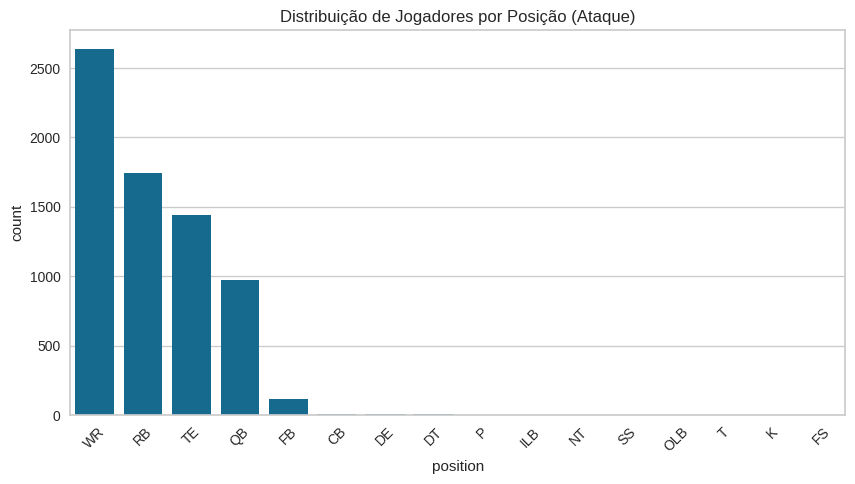

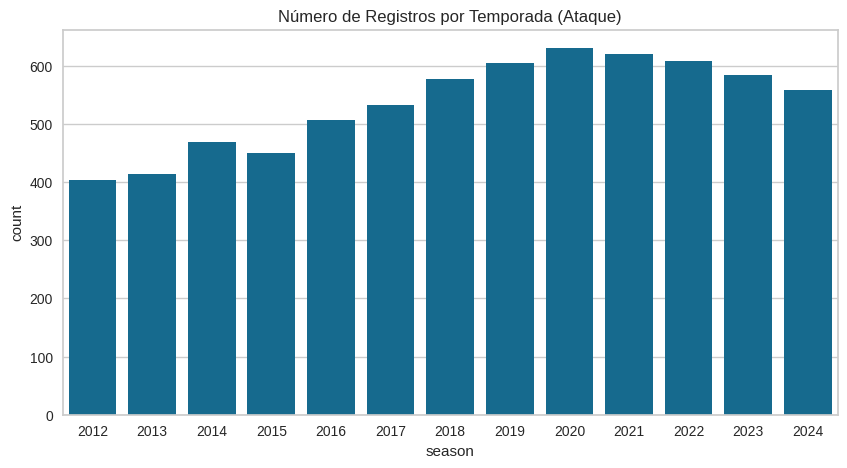

In [20]:
# Gráfico para verificar a distribuição dos jogadores por posição
plt.figure(figsize=(10,5))
sns.countplot(data=df_ataque_limpo, x='position', order=df_ataque_limpo['position'].value_counts().index)
plt.title('Distribuição de Jogadores por Posição (Ataque)')
plt.xticks(rotation=45)
plt.show()

# Número de registros por temporada
plt.figure(figsize=(10,5))
sns.countplot(data=df_ataque_limpo, x='season')
plt.title('Número de Registros por Temporada (Ataque)')
plt.show()


In [21]:
# Estatísticas do ataque
df_ataque_limpo.describe()[['passing_yards', 'rushing_yards', 'receiving_yards', 'total_touchdown', 'fantasy_points_ppr']]

passing_yards  rushing_yards  receiving_yards  total_touchdown  \
count    6954.000000    6954.000000      6954.000000      6954.000000   
mean      234.644953     102.130860       221.098504         3.616192   
std       842.062334     239.783109       306.600714         6.347103   
min        -7.000000     -31.000000       -15.000000         0.000000   
25%         0.000000       0.000000        11.000000         0.000000   
50%         0.000000       2.000000        85.000000         1.000000   
75%         0.000000      61.000000       310.000000         4.000000   
max      5477.000000    2027.000000      1964.000000        56.000000   

       fantasy_points_ppr  
count         6954.000000  
mean            78.678392  
std             89.907939  
min             -4.720000  
25%             11.200000  
50%             41.400000  
75%            119.700000  
max            513.980000

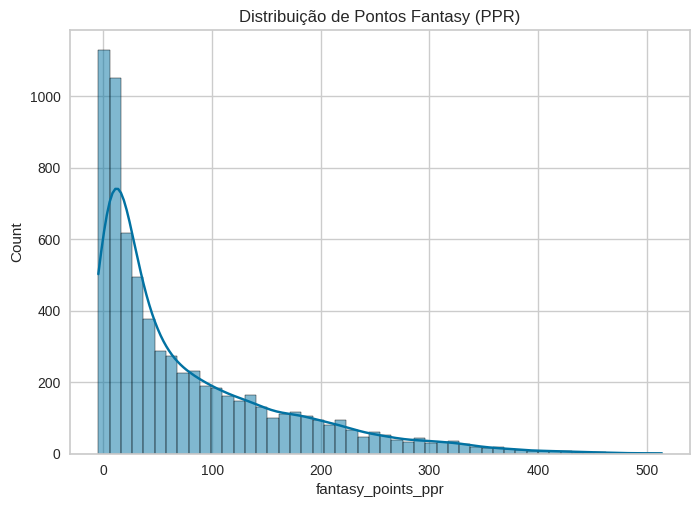

In [22]:
# Distribuição de Pontos do Fantasy
sns.histplot(df_ataque_limpo['fantasy_points_ppr'], bins=50, kde=True)
plt.title('Distribuição de Pontos Fantasy (PPR)')
plt.show()


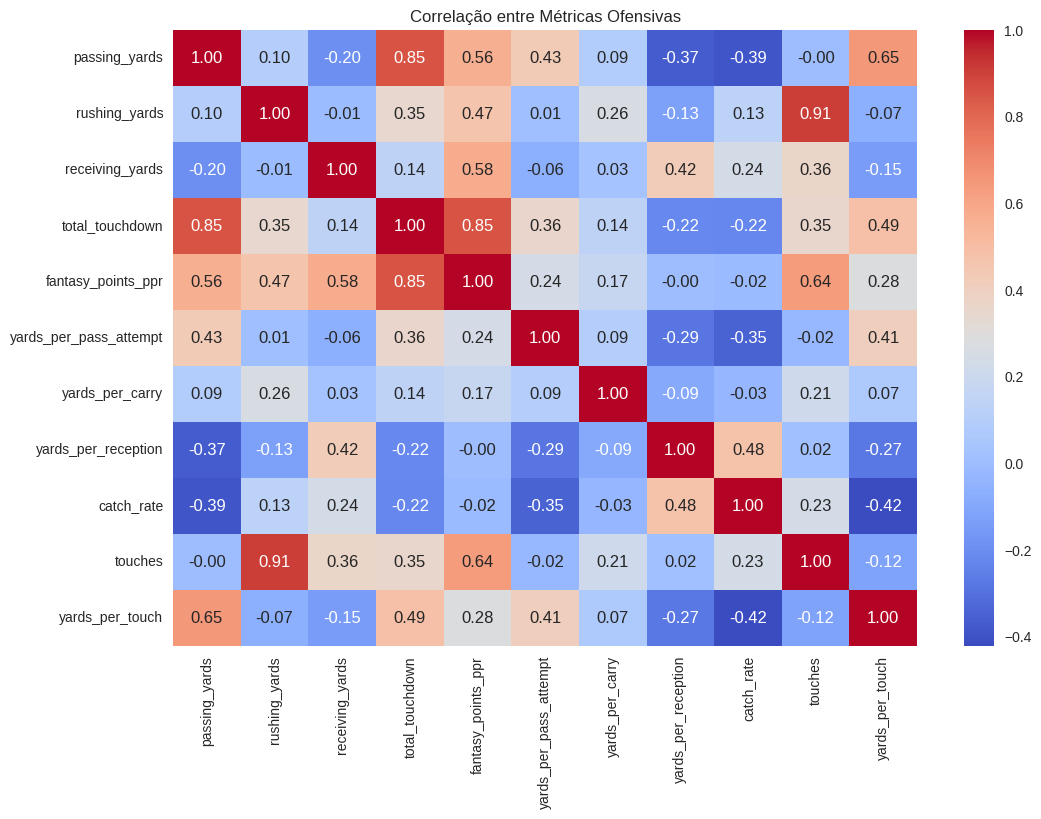

In [23]:
# Correlação entre variáveis
corr_cols = ['passing_yards', 'rushing_yards', 'receiving_yards', 'total_touchdown', 'fantasy_points_ppr', 'yards_per_pass_attempt',
             'yards_per_carry',  'yards_per_reception', 'catch_rate', 'touches', 'yards_per_touch']
plt.figure(figsize=(12, 8))
sns.heatmap(df_ataque_limpo[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Métricas Ofensivas')
plt.show()


#### **QBs**

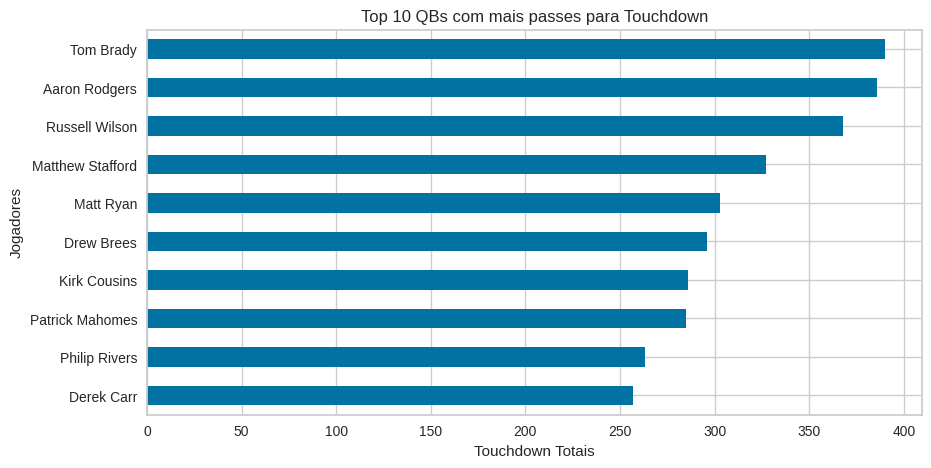

In [24]:
# Top QBs com mais passes para touchdown
qbs= df_ataque_limpo[df_ataque_limpo['position'] == 'QB']
top_qbs_touch = qbs.groupby('player_name')['pass_touchdown'].sum().nlargest(10)
top_qbs_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes para Touchdown')
plt.ylabel('Jogadores')
plt.xlabel('Touchdown Totais')
plt.show()


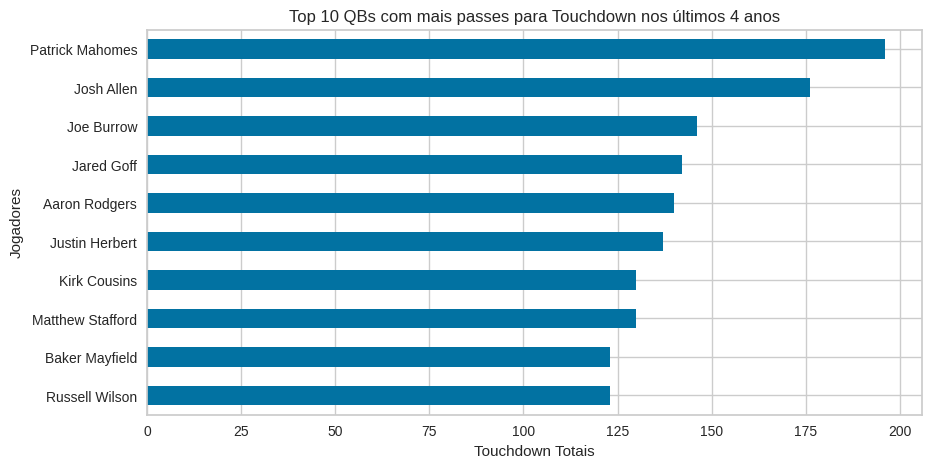

In [25]:
# Top QBs com mais passes para touchdown nos últimos 4 anos
qbs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'QB') & (df_ataque_limpo['season'] >= 2020)]
top_qbs_touch_recente = qbs_recentes.groupby('player_name')['pass_touchdown'].sum().nlargest(10)
top_qbs_touch_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes para Touchdown nos últimos 4 anos')
plt.xlabel('Touchdown Totais')
plt.ylabel('Jogadores')
plt.show()

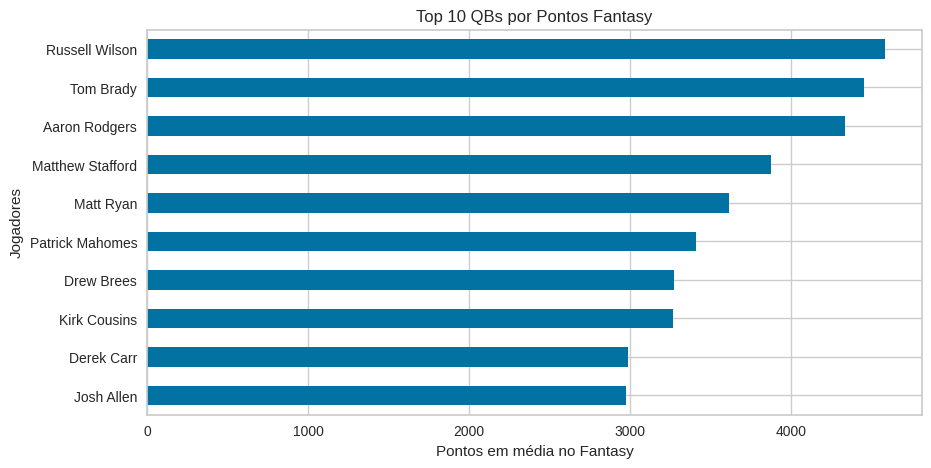

In [26]:
# Top QBs em pontos fantasy
top_qbs_fantasy = qbs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_qbs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs por Pontos Fantasy')
plt.xlabel('Pontos em média no Fantasy')
plt.ylabel('Jogadores')
plt.show()


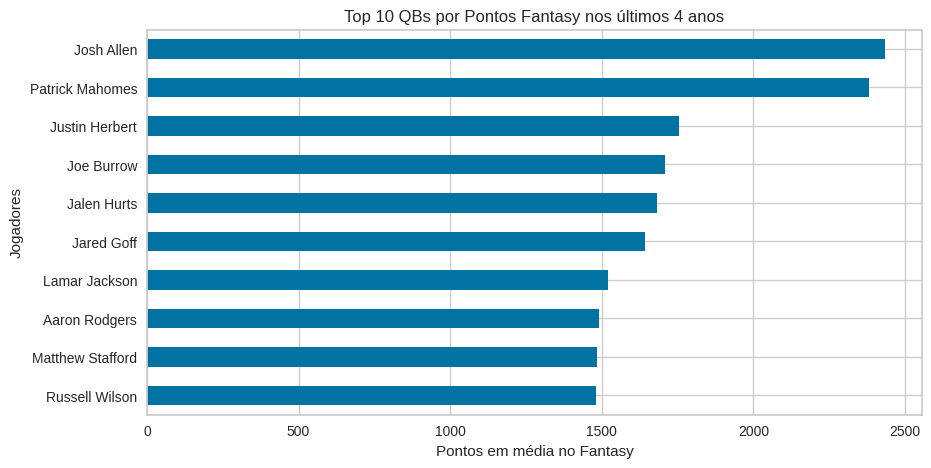

In [27]:
# Top 10 QBs por Pontos Fantasy nos últimos 4 anos
top_qbs_fantasy_recentes = qbs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_qbs_fantasy_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs por Pontos Fantasy nos últimos 4 anos')
plt.xlabel('Pontos em média no Fantasy')
plt.ylabel('Jogadores')
plt.show()

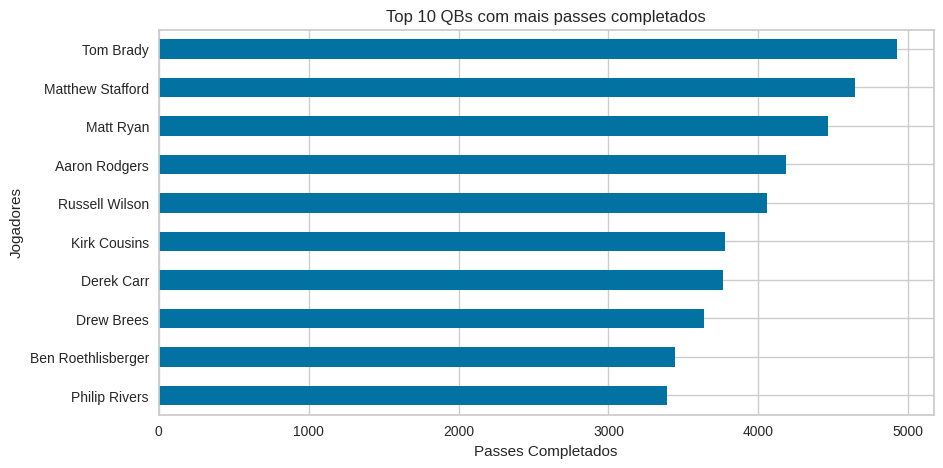

In [28]:
# Top QBs com mais passes completados
top_qbs_compl = qbs.groupby('player_name')['complete_pass'].sum().nlargest(10)
top_qbs_compl.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes completados')
plt.xlabel('Passes Completados')
plt.ylabel('Jogadores')
plt.show()

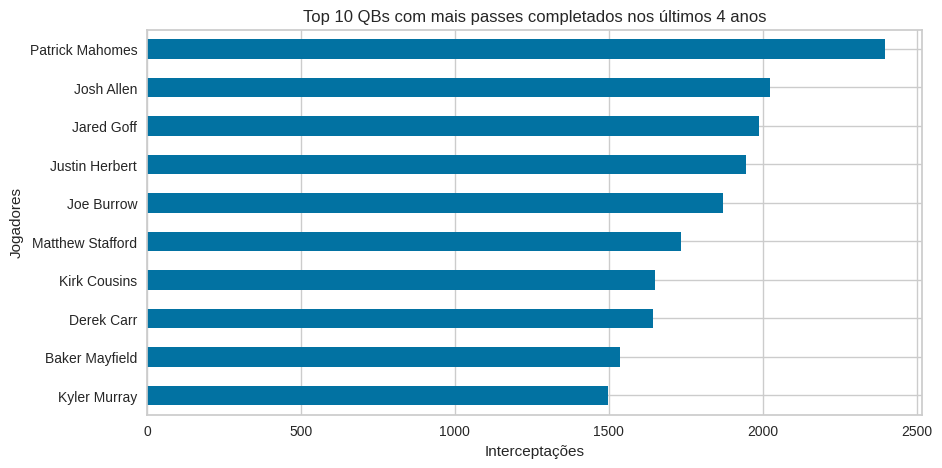

In [29]:
# Top QBs com mais passes completados os últimos 4 anos
top_qbs_compl_recentes = qbs_recentes.groupby('player_name')['complete_pass'].sum().nlargest(10)
top_qbs_compl_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes completados nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

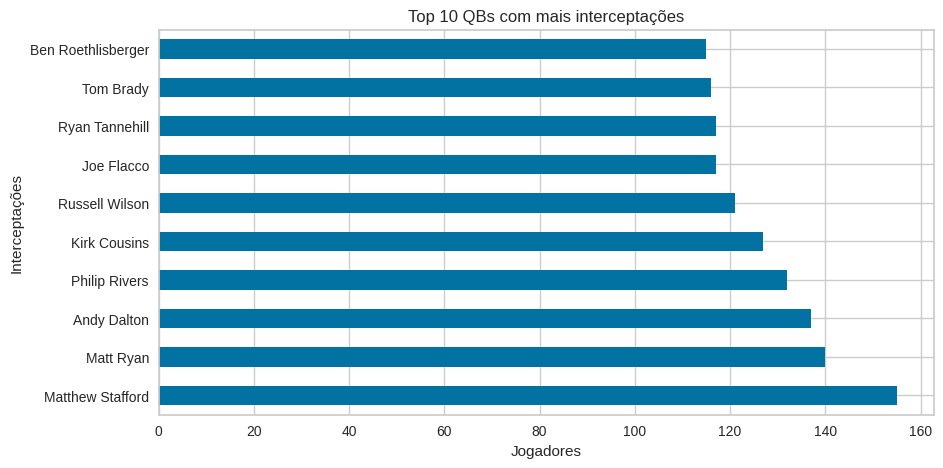

In [30]:
# Top QBs com mais interceptações
top_qbs_int = qbs.groupby('player_name')['interception'].sum().nlargest(10)
top_qbs_int.plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais interceptações')
plt.ylabel('Interceptações')
plt.xlabel('Jogadores')
plt.show()

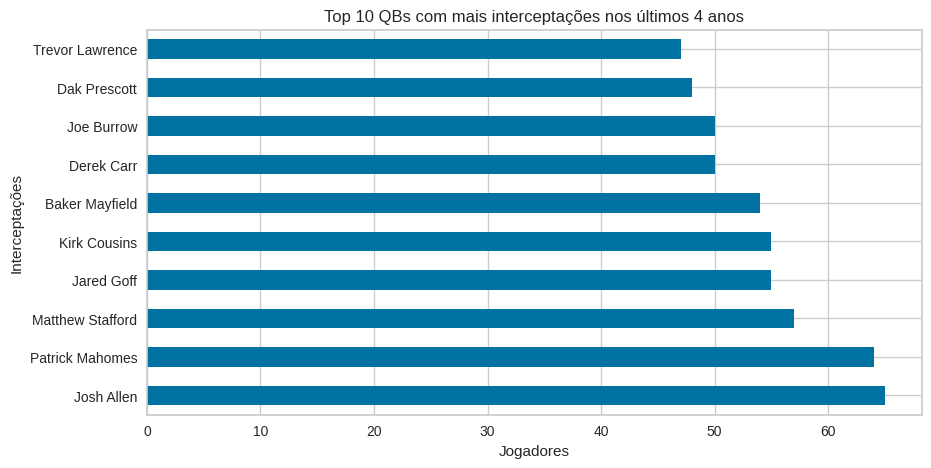

In [31]:
# Top QBs com mais interceptações nos últimos 4 anos
top_qbs_int = qbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_qbs_int.plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais interceptações nos últimos 4 anos')
plt.ylabel('Interceptações')
plt.xlabel('Jogadores')
plt.show()

####**WR**

In [32]:
# Top WRs em jardas recebidas
wrs = df_ataque_limpo[df_ataque_limpo['position'] == 'WR']
top_wrs = wrs.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_wrs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


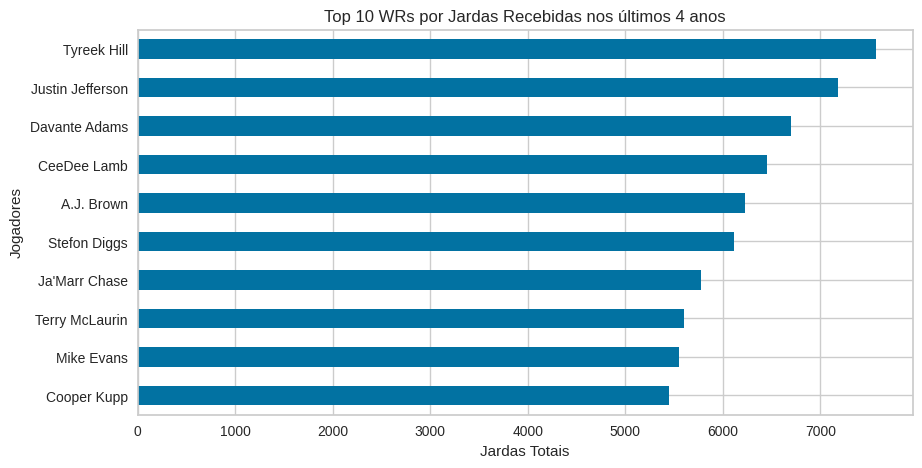

In [33]:
# Top WRs em jardas recebidas nos últimos 4 anos
top_wrs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'WR') & (df_ataque_limpo['season'] >= 2020)]
top_wrs_jardas_recentes = top_wrs_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_wrs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


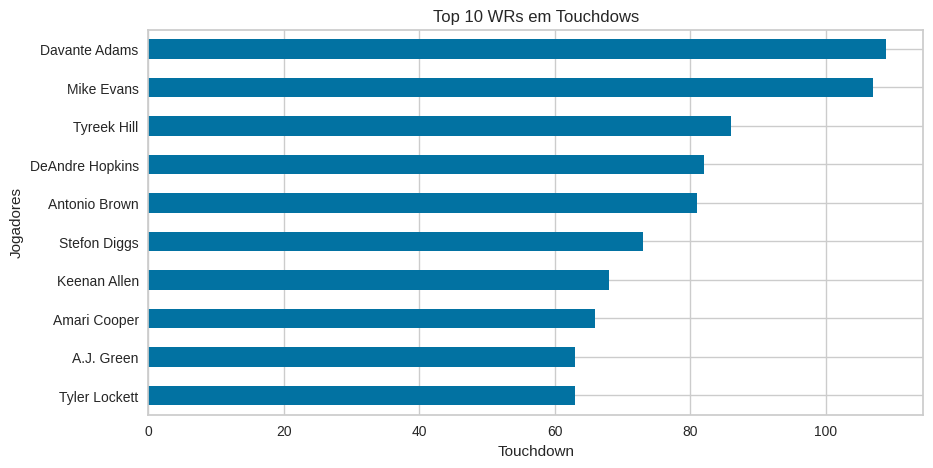

In [34]:
# Top WRs em Tochdowns
top_wrs_touch = wrs.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_wrs_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Touchdows')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

In [35]:
# Top WRs em jardas recebidas nos últimos 4 anos
top_wrs_touch_recentes = top_wrs_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_wrs_touch_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Touchdows nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


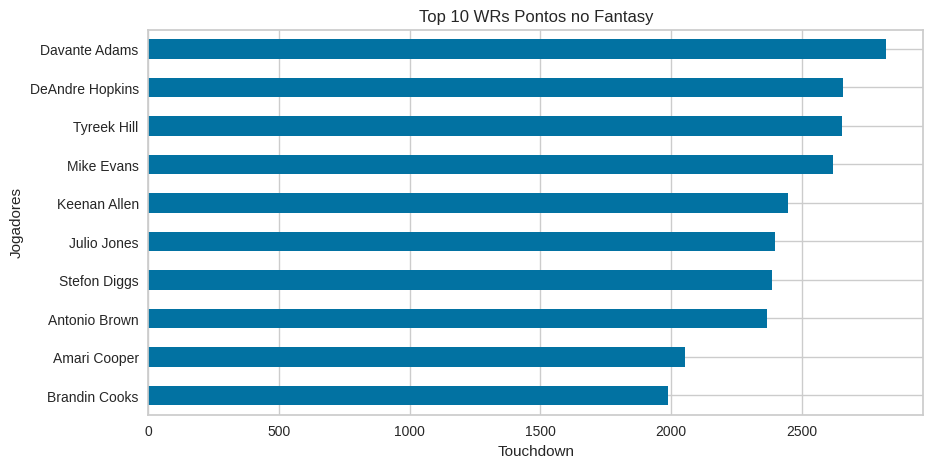

In [36]:
# Top WRs Pontos no Fantasy
top_wrs_fantasy = wrs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_wrs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs Pontos no Fantasy')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

In [37]:
# Top WRs Pontos no Fantasy nos últimos 4 anos
top_wrs_fantasy_recente = top_wrs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_wrs_fantasy_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

In [38]:
# Top WRs em Target
top_wrs_target = wrs.groupby('player_name')['targets'].sum().nlargest(10)
top_wrs_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()


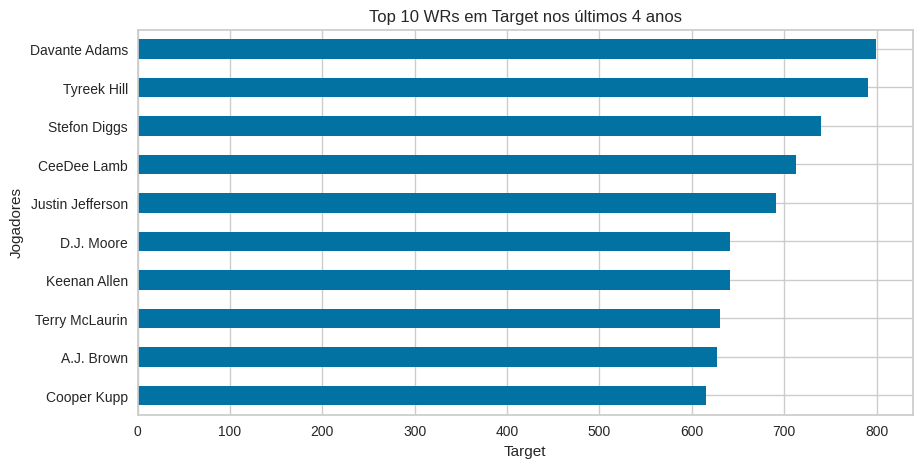

In [39]:
# Top WRs em Target nos últimos 4 anos
top_wrs_target_recentes = top_wrs_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_wrs_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Target nos últimos 4 anos')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()


In [40]:
# Top WRs em Fumble
top_wrs_fumble = wrs.groupby('player_name')['fumble'].sum().nlargest(10)
top_wrs_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

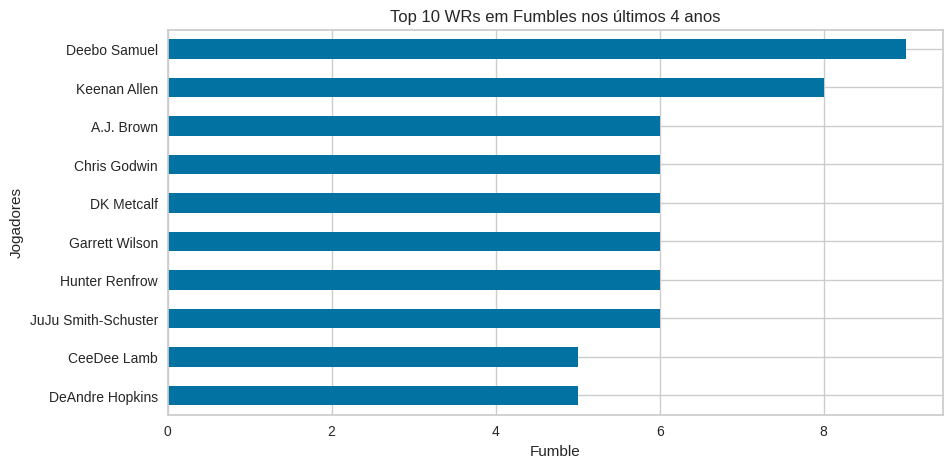

In [41]:
# Top WRs em Fumblee nos últimos 4 anos
top_wrs_fumble_recentes = top_wrs_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_wrs_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

####**TE**

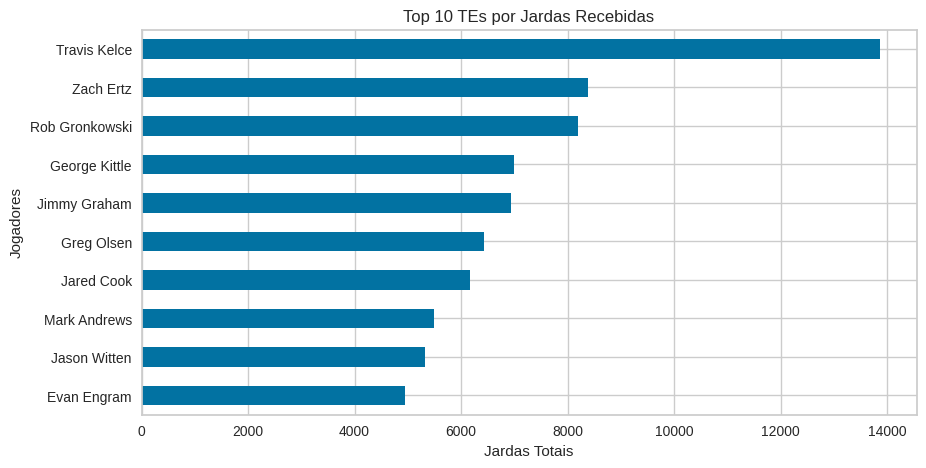

In [42]:
# Top TE em jardas recebidas
tes = df_ataque_limpo[df_ataque_limpo['position'] == 'TE']
top_tes = tes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_tes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

In [43]:
# Top tes em jardas recebidas nos últimos 4 anos
top_tes_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'TE') & (df_ataque_limpo['season'] >= 2020)]
top_tes_jardas_recentes = top_tes_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_tes_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

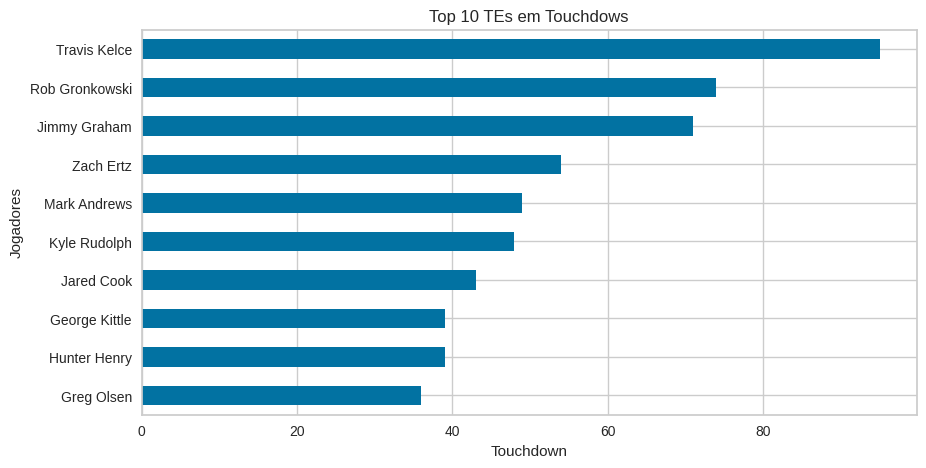

In [44]:
# Top TEs em Tochdowns
top_tes_touch = tes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_tes_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Touchdows')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

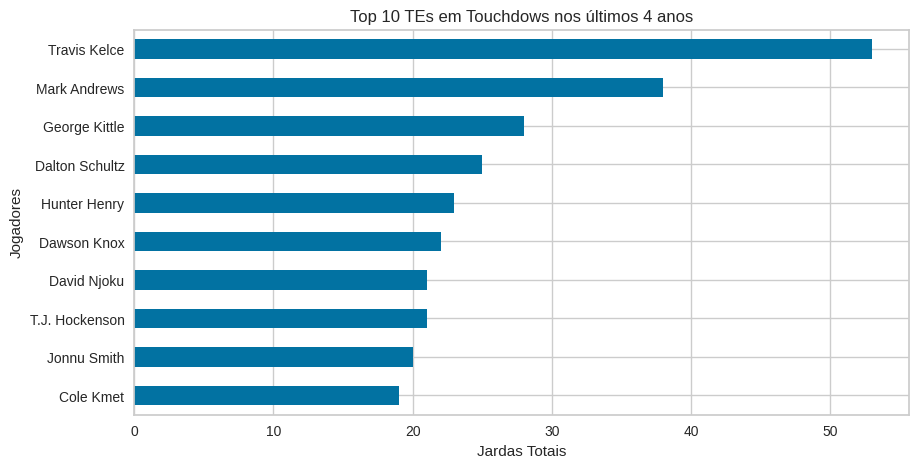

In [45]:
# Top TEs em jardas recebidas nos últimos 4 anos
top_tes_touch_recentes = top_tes_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_tes_touch_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Touchdows nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

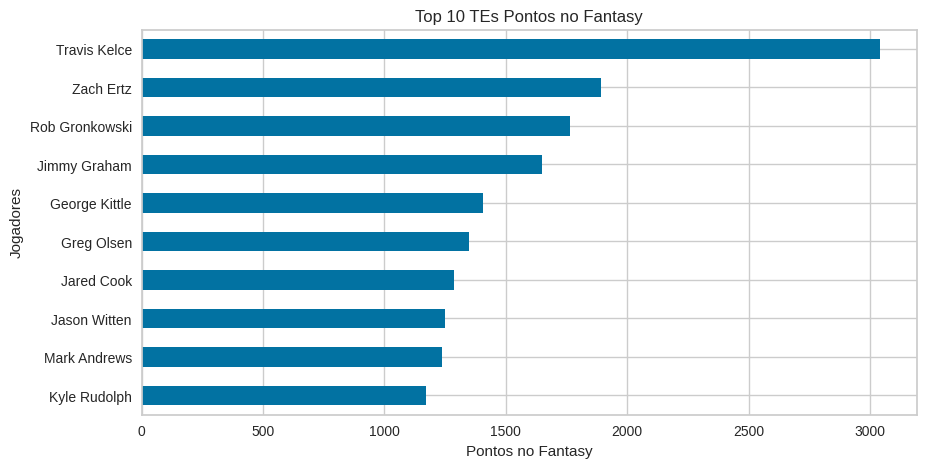

In [46]:
# Top TEs Pontos no Fantasy
top_tes_fantasy = tes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_tes_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs Pontos no Fantasy')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

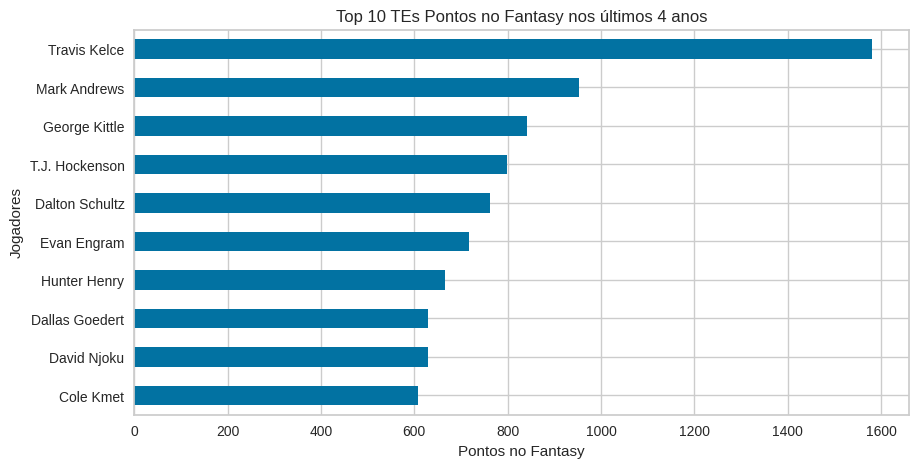

In [47]:
# Top TEs Pontos no Fantasy nos últimos 4 anos
top_tes_fantasy_recente = top_tes_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_tes_fantasy_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

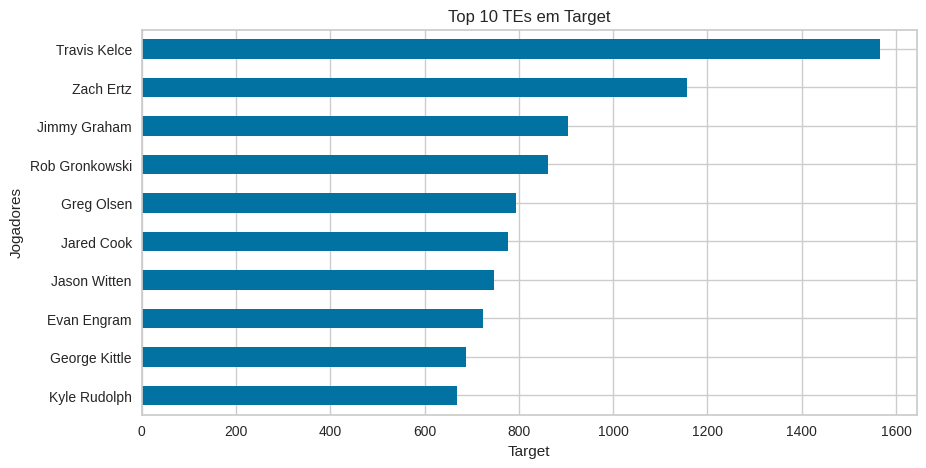

In [48]:
# Top TEs em Target
top_tes_target = tes.groupby('player_name')['targets'].sum().nlargest(10)
top_tes_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

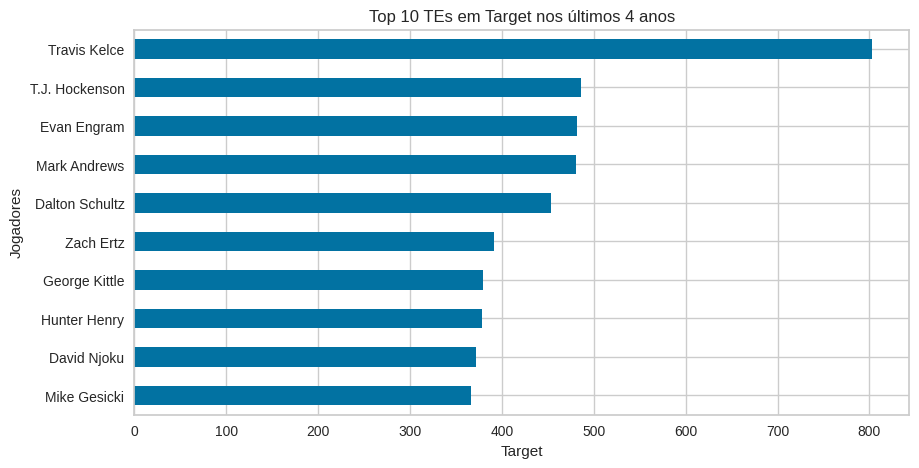

In [49]:
# Top TEs em Target nos últimos 4 anos
top_tes_target_recentes = top_tes_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_tes_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Target nos últimos 4 anos')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

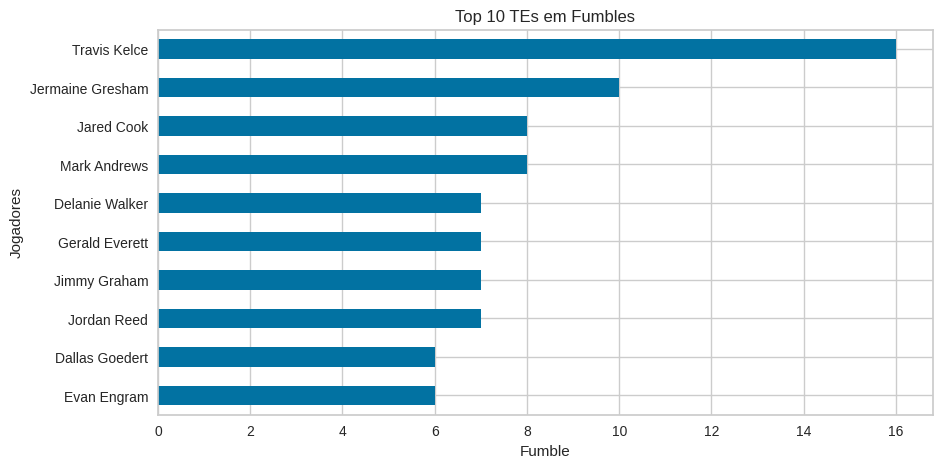

In [50]:
# Top TEs em Fumble
top_tes_fumble = tes.groupby('player_name')['fumble'].sum().nlargest(10)
top_tes_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

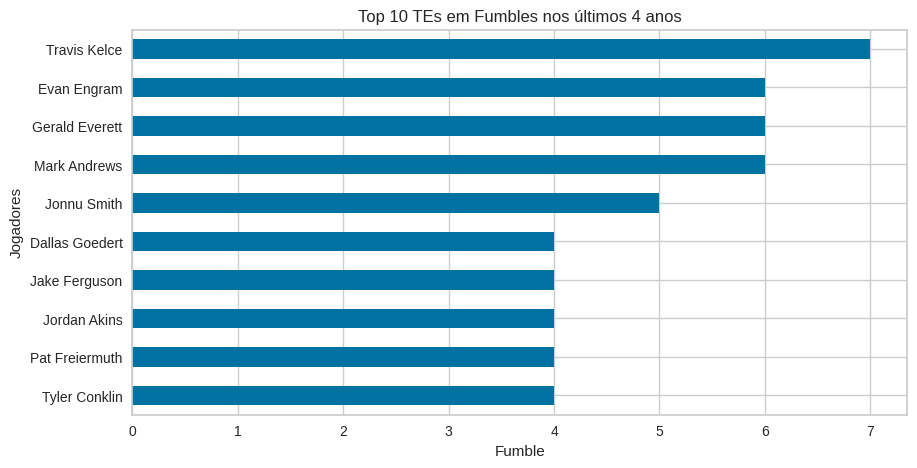

In [51]:
# Top TEs em Fumblee nos últimos 4 anos
top_tes_fumble_recentes = top_tes_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_tes_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

####**RB**

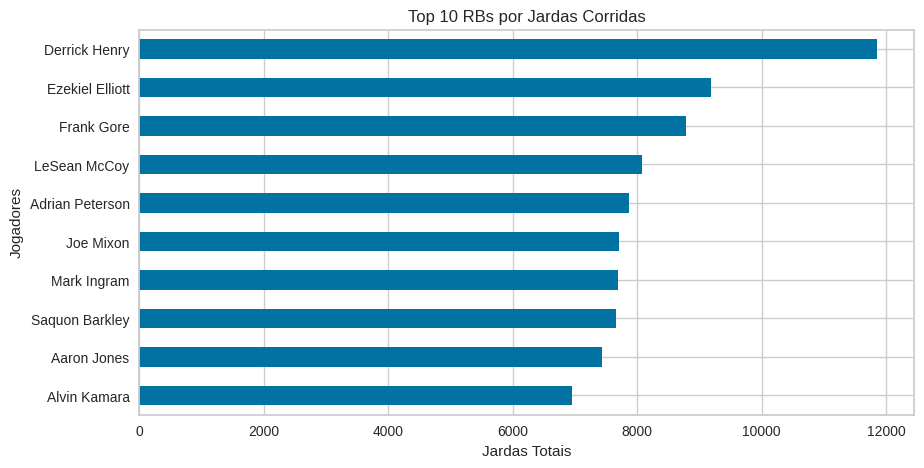

In [52]:
# Top rbs em jardas corridas
rbs = df_ataque_limpo[df_ataque_limpo['position'] == 'RB']
top_rbs = rbs.groupby('player_name')['rushing_yards'].sum().nlargest(10)
top_rbs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Corridas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

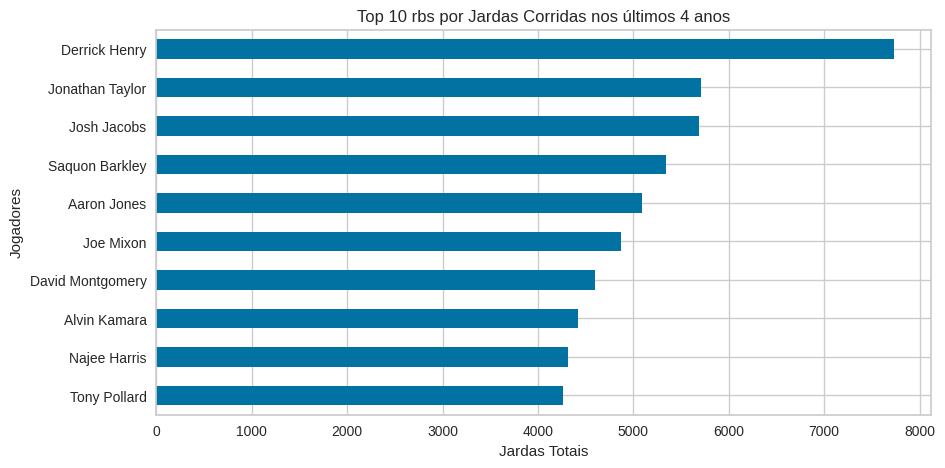

In [53]:
# Top rbs em jardas recebidas nos últimos 4 anos
top_rbs_recenrbs = df_ataque_limpo[(df_ataque_limpo['position'] == 'RB') & (df_ataque_limpo['season'] >= 2020)]
top_rbs_jardas_recentes = top_rbs_recenrbs.groupby('player_name')['rushing_yards'].sum().nlargest(10)
top_rbs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 rbs por Jardas Corridas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

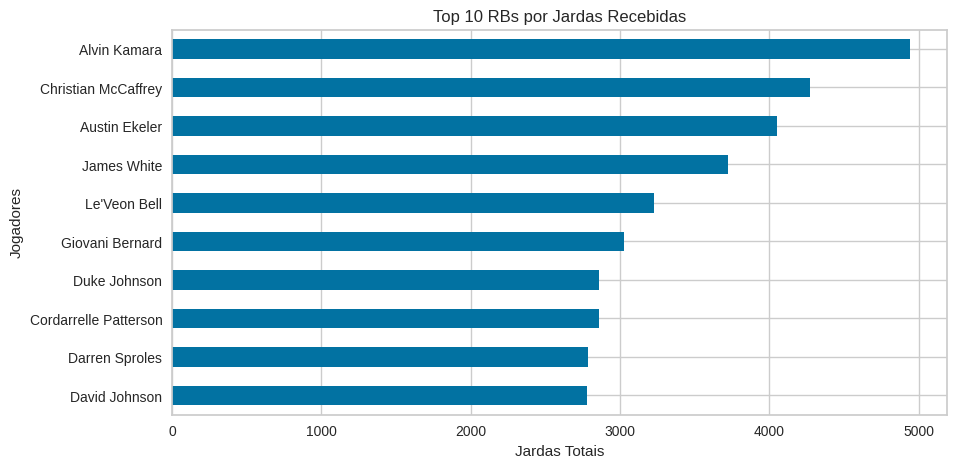

In [54]:
# Top RBs em jardas recebidas
rbs = df_ataque_limpo[df_ataque_limpo['position'] == 'RB']
top_rbs = rbs.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_rbs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

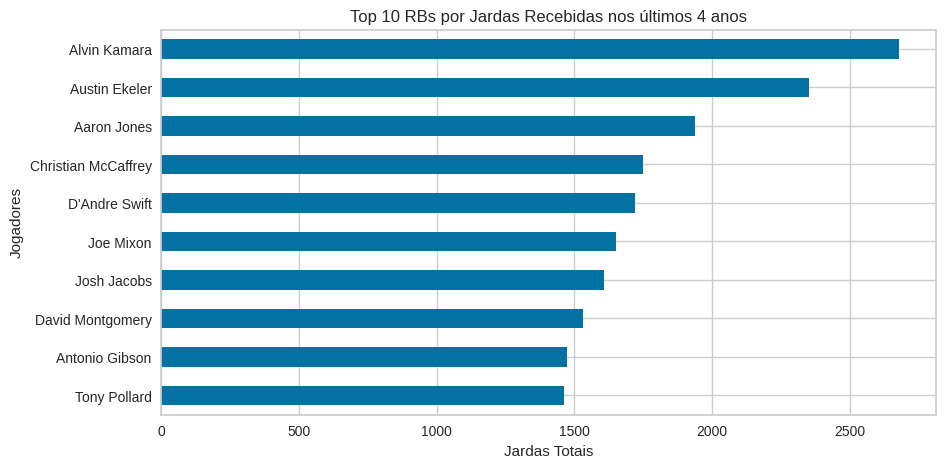

In [55]:
# Top RBs em jardas recebidas nos últimos 4 anos
top_rbs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'RB') & (df_ataque_limpo['season'] >= 2020)]
top_rbs_jardas_recentes = top_rbs_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_rbs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

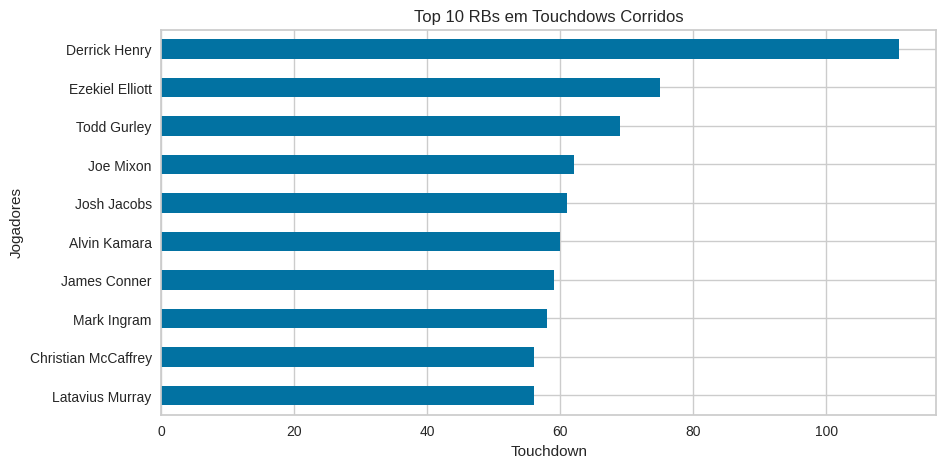

In [56]:
# Top RBs em Tochdowns Corridos
top_rbs_rush_td = rbs.groupby('player_name')['rush_touchdown'].sum().nlargest(10)
top_rbs_rush_td.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows Corridos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

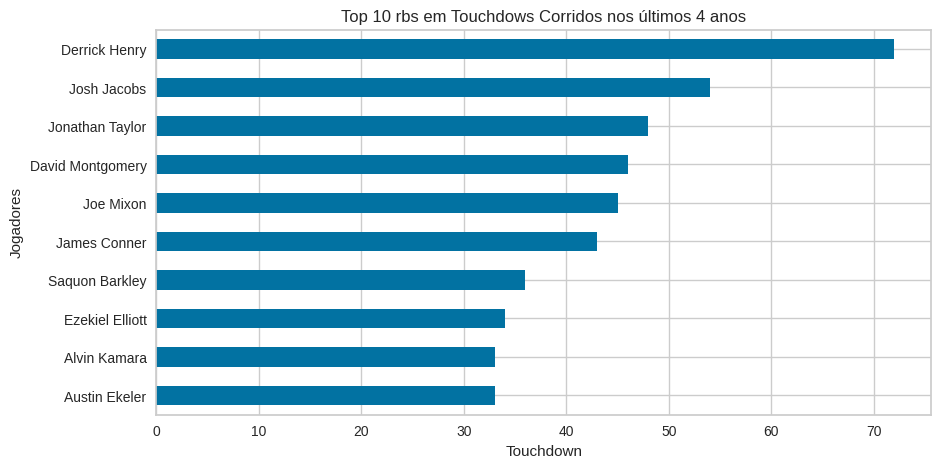

In [57]:
# Top rbs em Touchdown corridos nos últimos 4 anos
top_rbs_rush_td_recentes = top_rbs_recentes.groupby('player_name')['rush_touchdown'].sum().nlargest(10)
top_rbs_rush_td_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 rbs em Touchdows Corridos nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

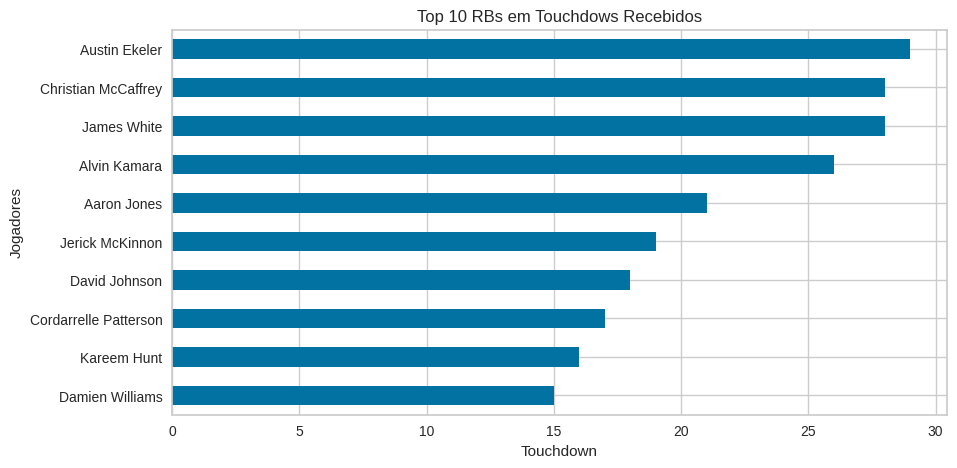

In [58]:
# Top RBs em Tochdowns Recebidos
top_rbs_td_receb = rbs.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_rbs_td_receb.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows Recebidos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

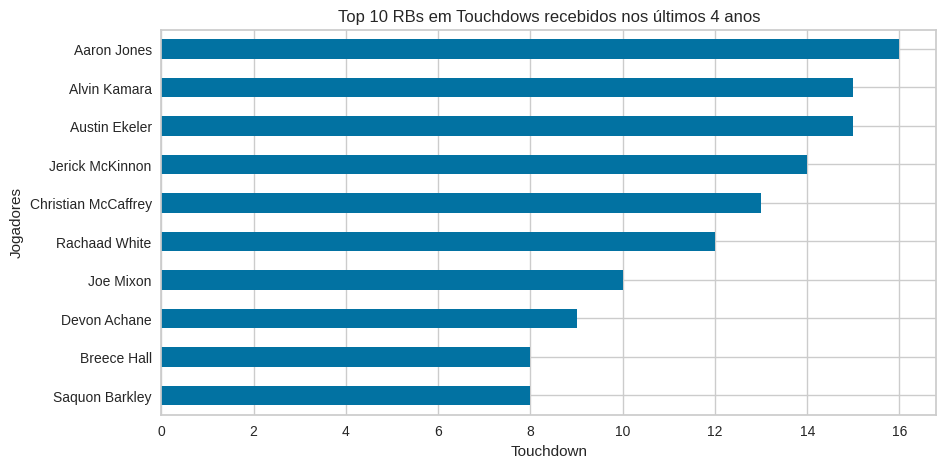

In [59]:
# Top RBs em Tochdowns recebidos nos últimos 4 anos
top_rbs_td_receb_recentes = top_rbs_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_rbs_td_receb_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows recebidos nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

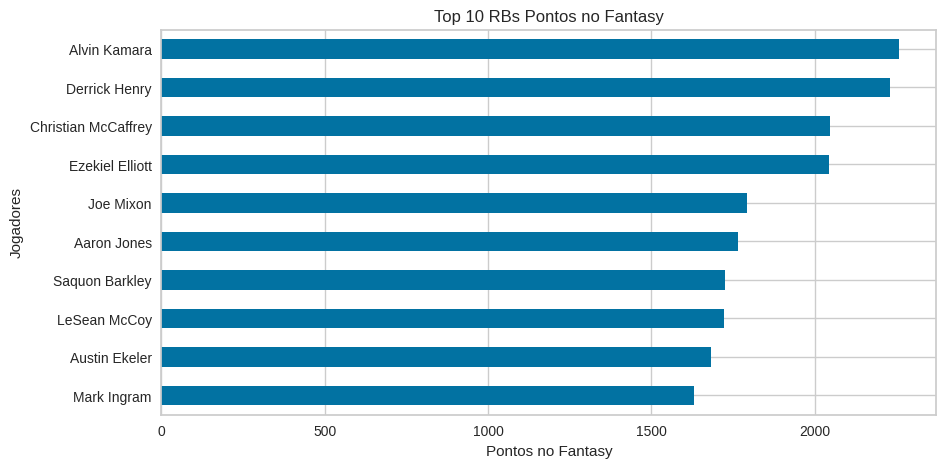

In [60]:
# Top rbs Pontos no Fantasy
top_rbs_fantasy = rbs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_rbs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs Pontos no Fantasy')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

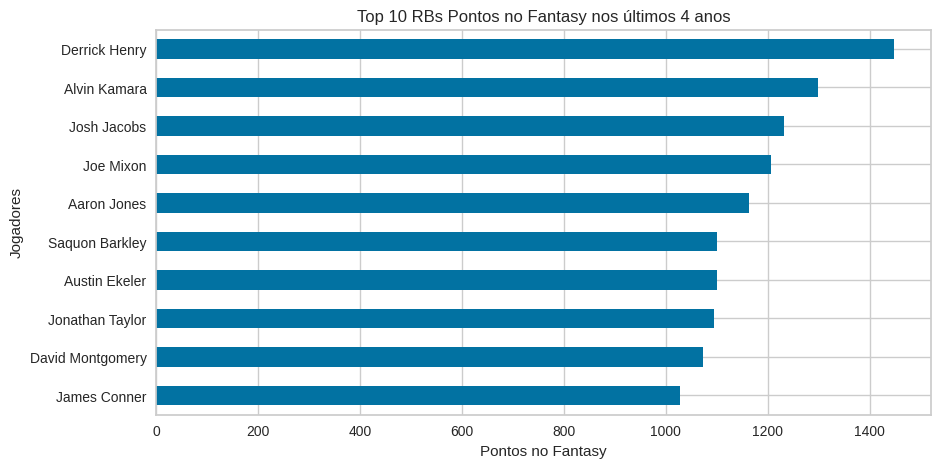

In [61]:
# Top rbs Pontos no Fantasy nos últimos 4 anos
top_rbs_fantasy_recenrb = top_rbs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_rbs_fantasy_recenrb.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

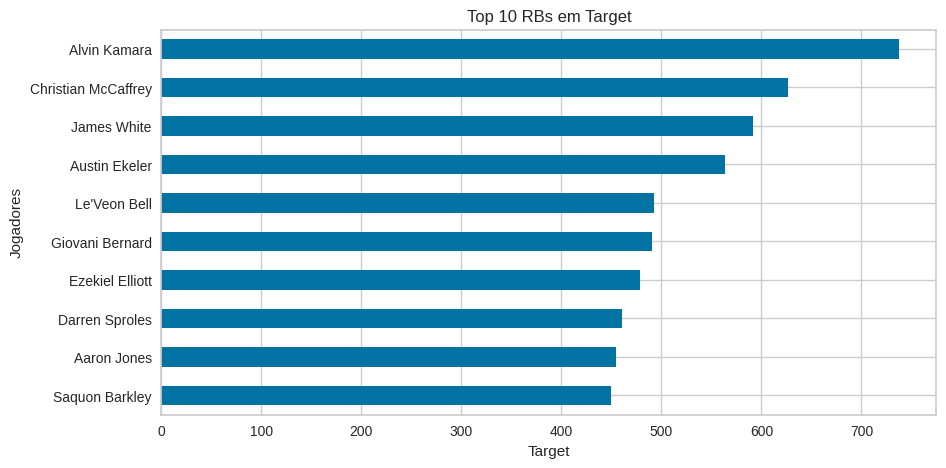

In [62]:
# Top rbs em Target
top_rbs_target = rbs.groupby('player_name')['targets'].sum().nlargest(10)
top_rbs_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

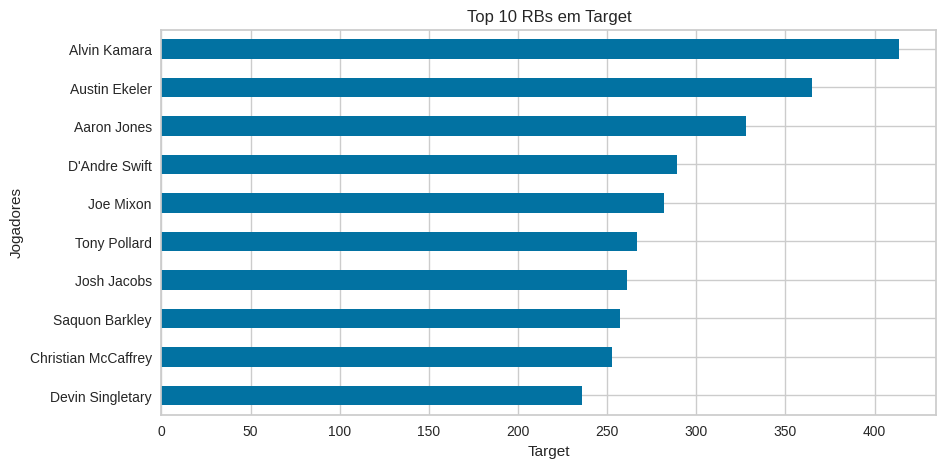

In [63]:
# Top rbs em Target nos últimos 4 anos
top_rbs_target_recentes = top_rbs_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_rbs_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

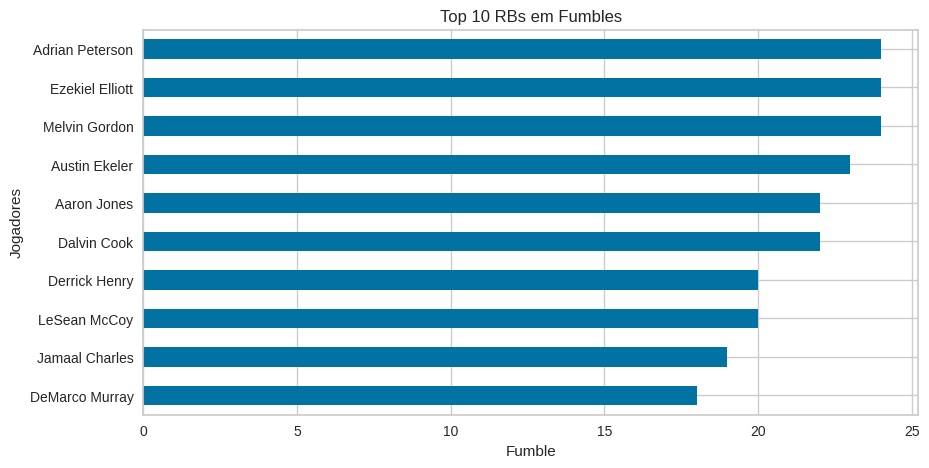

In [64]:
# Top rbs em Fumble
top_rbs_fumble = rbs.groupby('player_name')['fumble'].sum().nlargest(10)
top_rbs_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

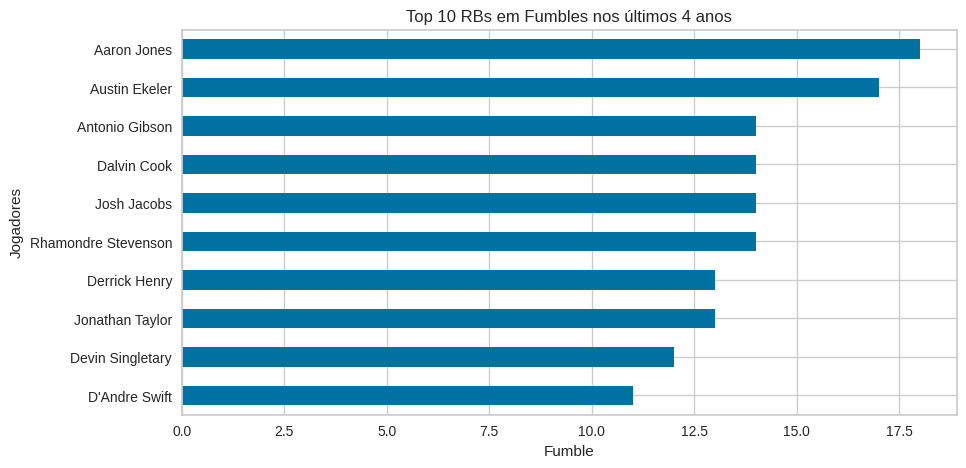

In [65]:
# Top rbs em Fumblee nos últimos 4 anos
top_rbs_fumble_recentes = top_rbs_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_rbs_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

TDs aéreos: 2012 → 2024
Total TDs na primeira temporada: 1364
Total TDs na última temporada: 1592
Variação percentual entre primeira e última: 16.7%


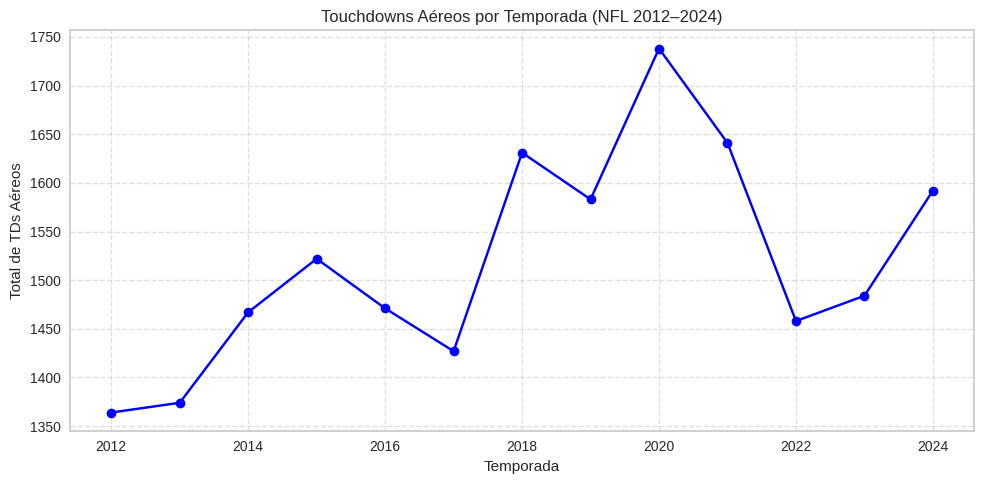

In [66]:
# Agrupando touchdowns de passe por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['pass_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['pass_touchdown'].iloc[0], td_por_temporada['pass_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs aéreos: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['pass_touchdown'], marker='o', color='blue')
plt.title('Touchdowns Aéreos por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs Aéreos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



TDs aéreos: 2012 → 2024
Total TDs na primeira temporada: 347
Total TDs na última temporada: 524
Variação percentual entre primeira e última: 51.0%


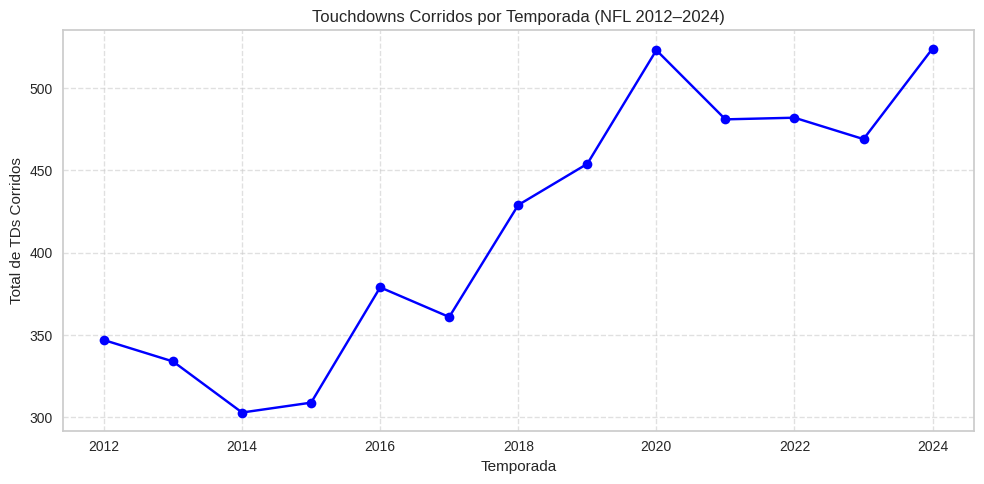

In [67]:
# Agrupando touchdowns de corrida por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['rush_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['rush_touchdown'].iloc[0], td_por_temporada['rush_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs aéreos: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['rush_touchdown'], marker='o', color='blue')
plt.title('Touchdowns Corridos por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs Corridos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

TDs totais: 2012 → 2024
Total TDs na primeira temporada: 1711
Total TDs na última temporada: 2116
Variação percentual entre primeira e última: 23.7%


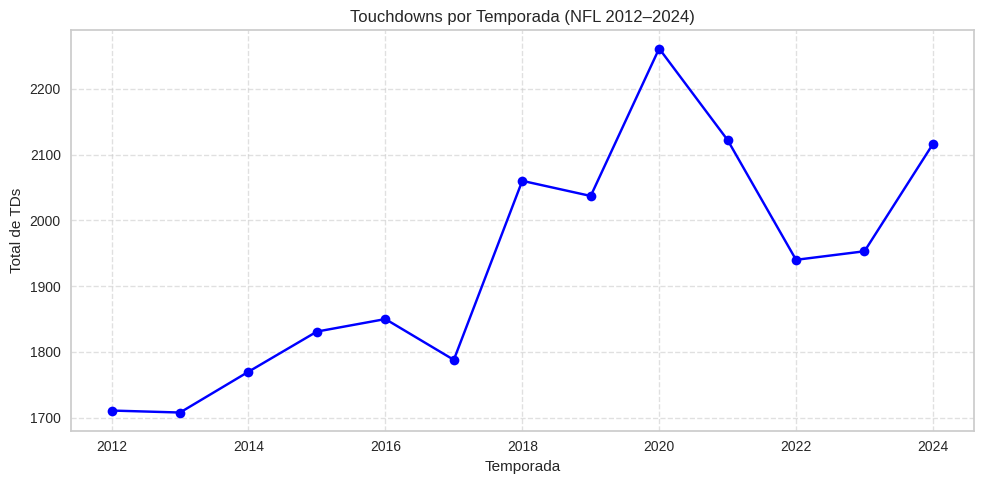

In [68]:
# Agrupando touchdowns por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['total_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['total_touchdown'].iloc[0], td_por_temporada['total_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['total_touchdown'], marker='o', color='blue')
plt.title('Touchdowns por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Passes completados totais: 2012 → 2024
Total de passes completados na primeira temporada: 10286
Total de passes completados na última temporada: 11807
Variação percentual entre primeira e última: 14.8%


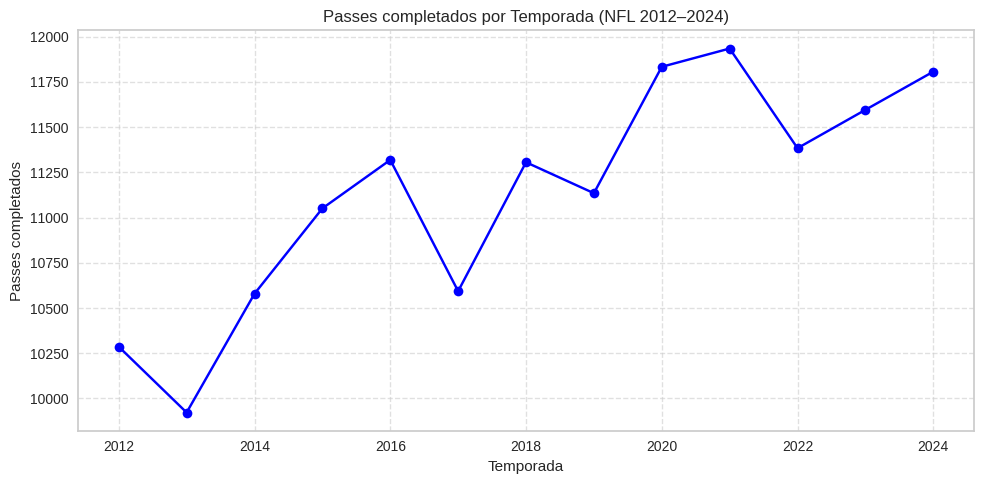

In [69]:
# Agrupando por passes completados por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['complete_pass']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['complete_pass'].iloc[0], td_por_temporada['complete_pass'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Passes completados totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de passes completados na primeira temporada: {primeira:.0f}")
print(f"Total de passes completados na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['complete_pass'], marker='o', color='blue')
plt.title('Passes completados por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Passes completados')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jardas passadas: 2012 → 2024
Jardas passadas na primeira temporada: 119740
Jardas passadas na última temporada: 129298
Variação percentual entre primeira e última: 8.0%


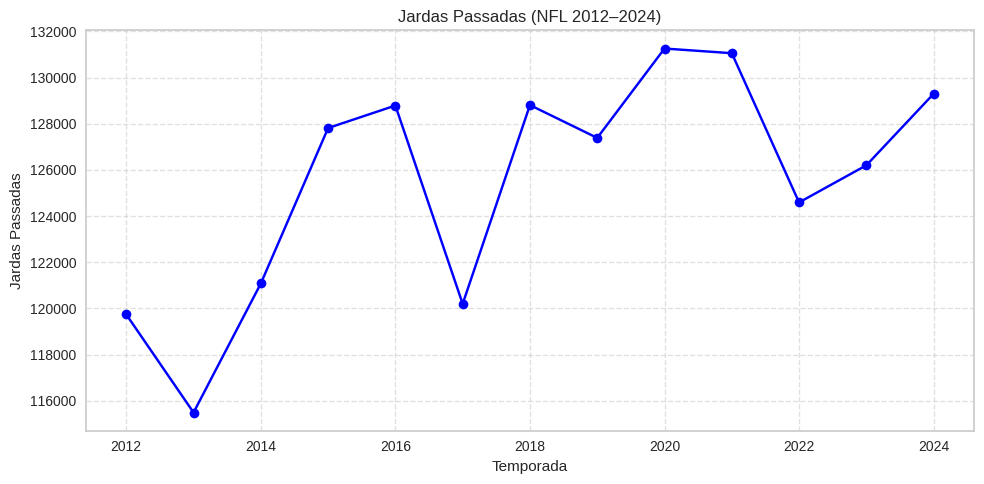

In [70]:
# Agrupando por jardas passads por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['passing_yards']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['passing_yards'].iloc[0], td_por_temporada['passing_yards'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jardas passadas: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Jardas passadas na primeira temporada: {primeira:.0f}")
print(f"Jardas passadas na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['passing_yards'], marker='o', color='blue')
plt.title('Jardas Passadas (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jardas Passadas')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Tentativa de corrida totais: 2012 → 2024
Total de tentativa de corridas na primeira temporada: 11747
Total de tentativa de corridas na última temporada: 14266
Variação percentual entre primeira e última: 21.4%


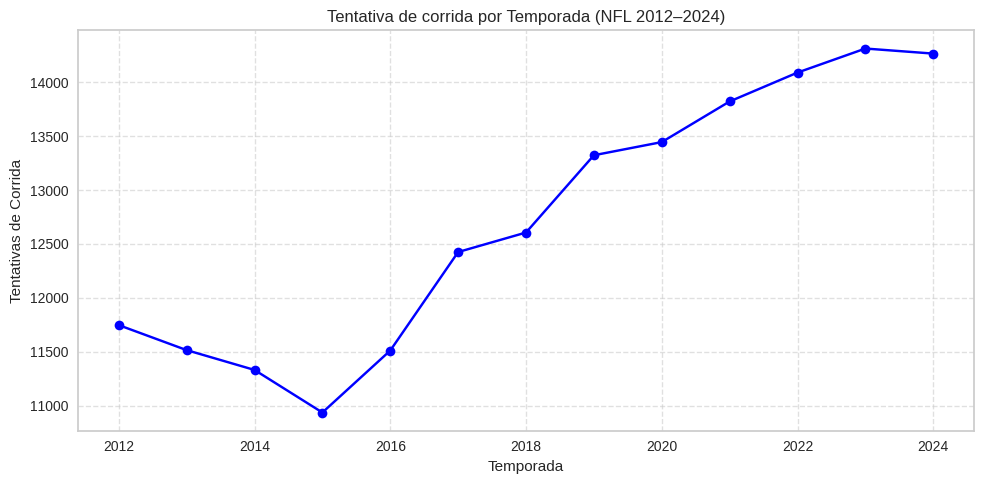

In [71]:
# Agrupando por tentativas de corridas por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['rush_attempts']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['rush_attempts'].iloc[0], td_por_temporada['rush_attempts'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Tentativa de corrida totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de tentativa de corridas na primeira temporada: {primeira:.0f}")
print(f"Total de tentativa de corridas na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['rush_attempts'], marker='o', color='blue')
plt.title('Tentativa de corrida por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Tentativas de Corrida')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jardas por carregada totais: 2012 → 2024
Total de Jardas por carregada na primeira temporada: 1042
Total de Jardas por carregada na última temporada: 1331
Variação percentual entre primeira e última: 27.6%


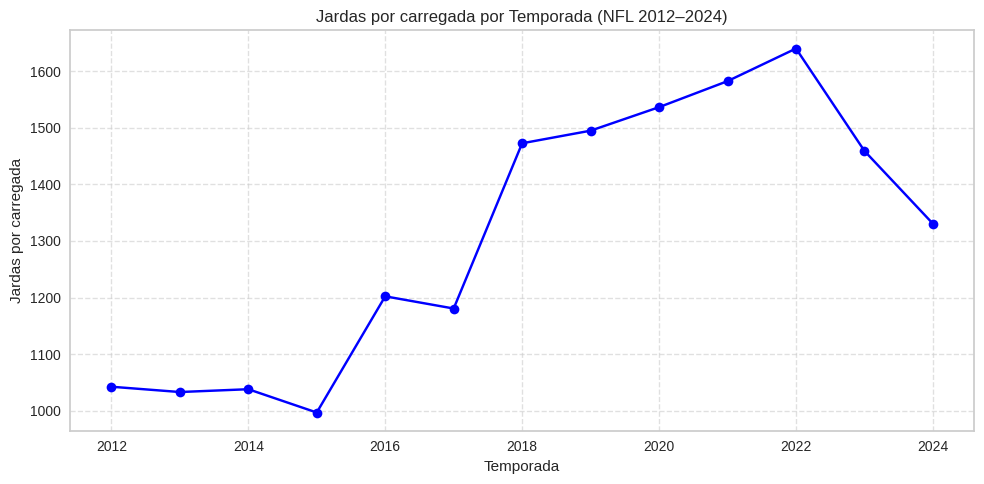

In [72]:
# Agrupando por jardas por carregada por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['yards_per_carry']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['yards_per_carry'].iloc[0], td_por_temporada['yards_per_carry'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jardas por carregada totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de Jardas por carregada na primeira temporada: {primeira:.0f}")
print(f"Total de Jardas por carregada na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['yards_per_carry'], marker='o', color='blue')
plt.title('Jardas por carregada por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jardas por carregada')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jardas por recepção totais: 2012 → 2024
Total de Jardas por recepção na primeira temporada: 3610
Total de Jardas por recepção na última temporada: 4677
Variação percentual entre primeira e última: 29.6%


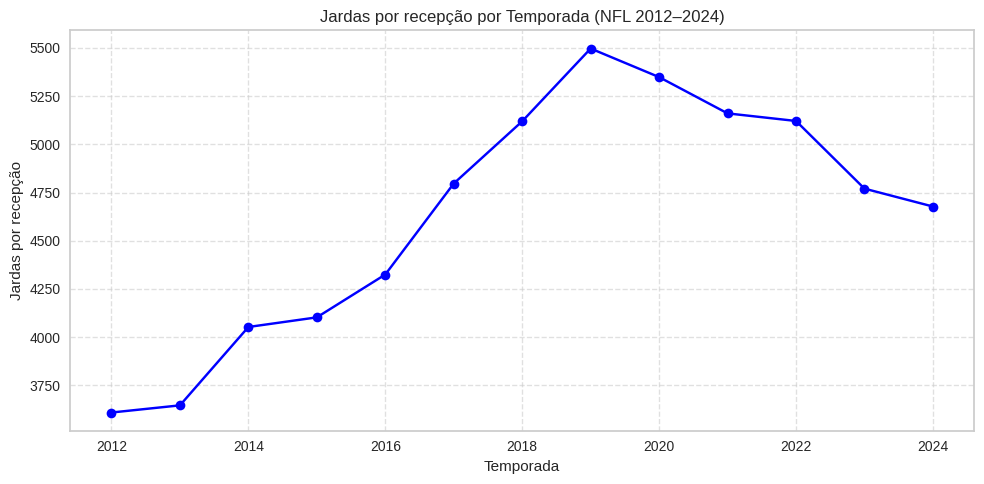

In [73]:
# Agrupando por jardas por recepção por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['yards_per_reception']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['yards_per_reception'].iloc[0], td_por_temporada['yards_per_reception'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jardas por recepção totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de Jardas por recepção na primeira temporada: {primeira:.0f}")
print(f"Total de Jardas por recepção na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['yards_per_reception'], marker='o', color='blue')
plt.title('Jardas por recepção por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jardas por recepção')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Taxa de recepção: 2012 → 2024
Total de taxa por recepção na primeira temporada: 224
Total de taxa por recepção na última temporada: 331
Variação percentual entre primeira e última: 48.0%


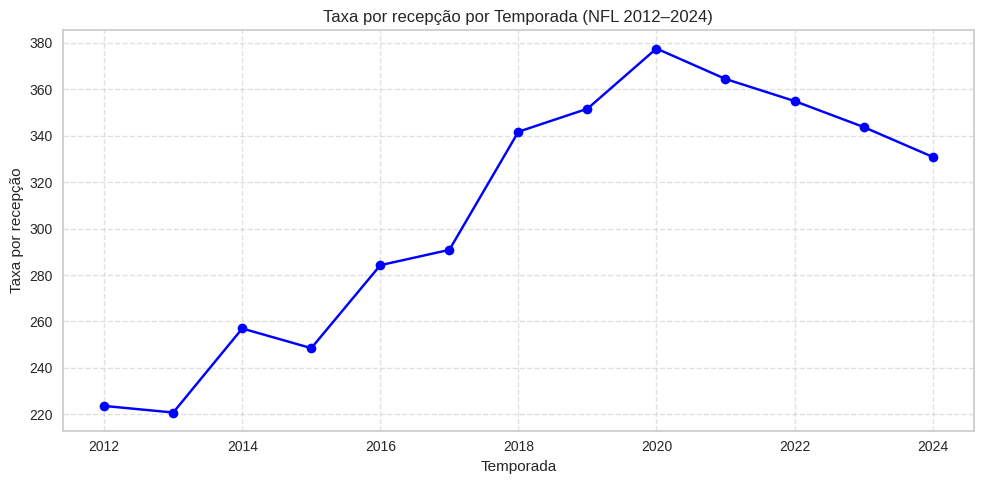

In [74]:
# Agrupando por taxa por recepção por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['catch_rate']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['catch_rate'].iloc[0], td_por_temporada['catch_rate'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Taxa de recepção: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de taxa por recepção na primeira temporada: {primeira:.0f}")
print(f"Total de taxa por recepção na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['catch_rate'], marker='o', color='blue')
plt.title('Taxa por recepção por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Taxa por recepção')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

###**Defesa**

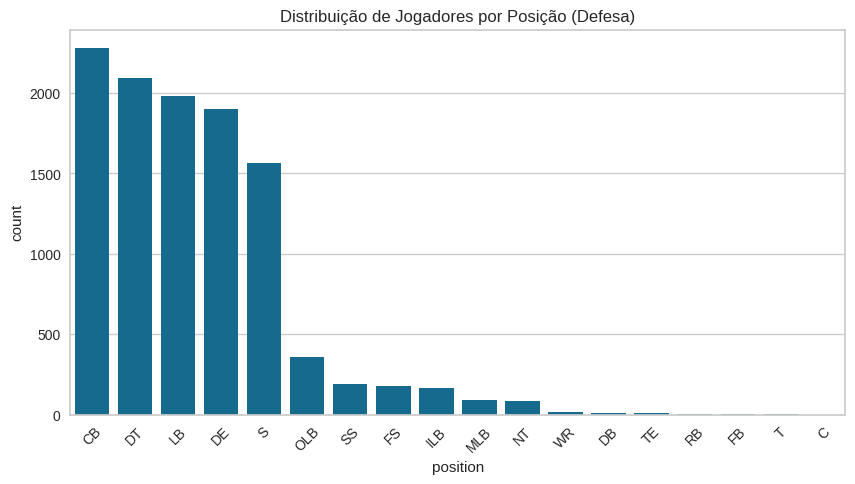

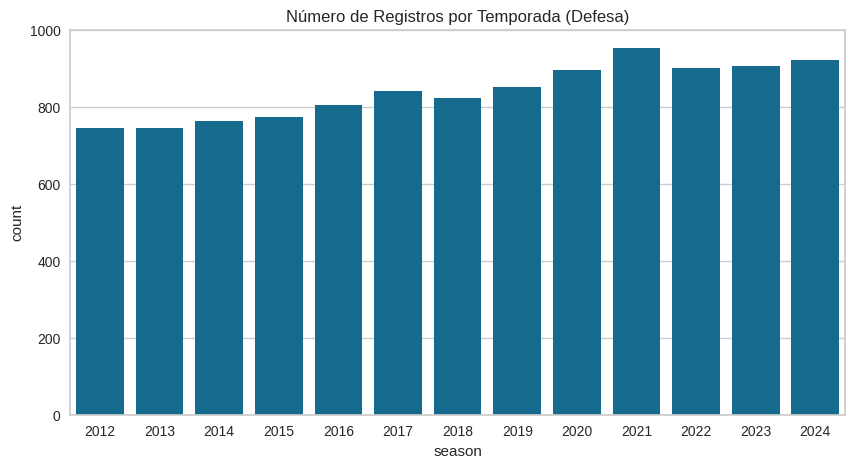

In [75]:
# Gráfico para verificar a distribuição dos jogadores por posição
plt.figure(figsize=(10,5))
sns.countplot(data=df_defesa_limpo, x='position', order=df_defesa_limpo['position'].value_counts().index)
plt.title('Distribuição de Jogadores por Posição (Defesa)')
plt.xticks(rotation=45)
plt.show()

# Número de registros por temporada
plt.figure(figsize=(10,5))
sns.countplot(data=df_defesa_limpo, x='season')
plt.title('Número de Registros por Temporada (Defesa)')
plt.show()

In [76]:
# Estatísticas da defesa
df_defesa_limpo.describe()[['tackles_total', 'sack', 'qb_hit', 'interception', 'fumble_forced', 'def_touchdown', 'impact_plays']]

tackles_total          sack        qb_hit  interception  fumble_forced  \
count   10939.000000  10939.000000  10939.000000  10939.000000   10939.000000   
mean       42.291251      5.756742      8.497669      1.126794       1.401225   
std        37.987574     10.372226     12.726330      2.165175       2.703147   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%        10.000000      0.000000      1.000000      0.000000       0.000000   
50%        33.000000      0.000000      4.000000      0.000000       0.000000   
75%        64.000000      7.000000     10.000000      2.000000       2.000000   
max       231.000000     92.000000    112.000000     22.000000      33.000000   

       def_touchdown  impact_plays  
count   10939.000000  10939.000000  
mean        0.161075      8.493555  
std         0.620856     12.608796  
min         0.000000      0.000000  
25%         0.000000      0.000000  
50%         0.000000      4.000000  
75%         0.000000     11.000000  
max        10.000000    111.000000

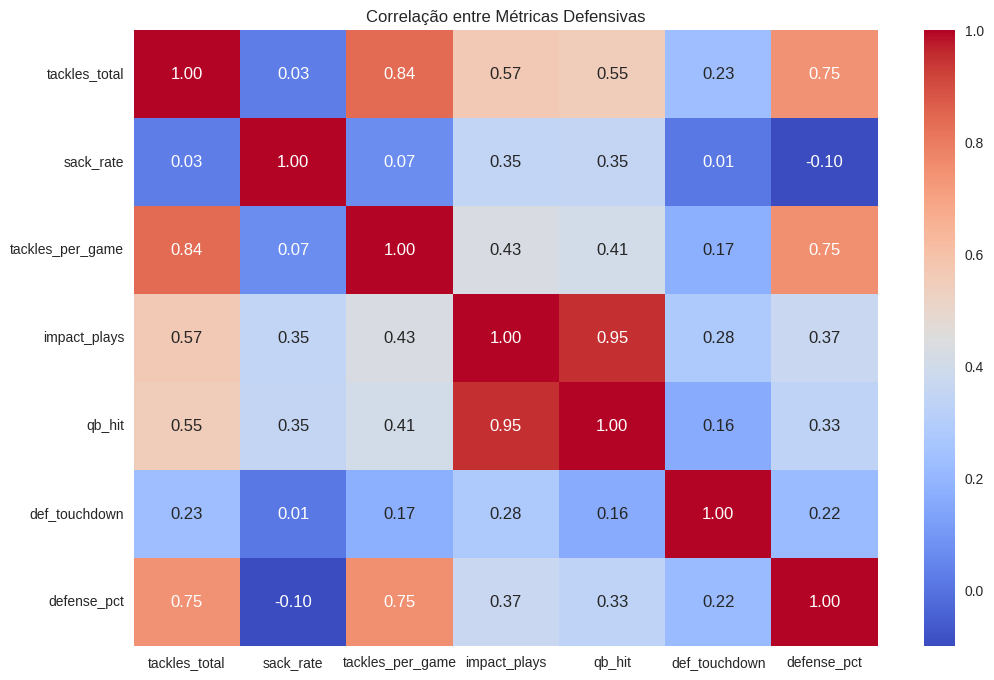

In [77]:
# Correlação entre variáveis
corr_cols = ['tackles_total', 'sack_rate', 'tackles_per_game', 'impact_plays',
             'qb_hit',  'def_touchdown', 'defense_pct']
plt.figure(figsize=(12, 8))
sns.heatmap(df_defesa_limpo[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Métricas Defensivas')
plt.show()

####**CBs (DBs)**

In [78]:
# Top CBs com mais tackles totais
cbs = df_defesa_limpo[(df_defesa_limpo['position'] == 'CB') | (df_defesa_limpo['position'] == 'DB')]
top_cbs_tackles = cbs.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_cbs_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

In [79]:
# Top CBs com mais tackles totais nos últimos 4 anos
cbs_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'CB') | (df_defesa_limpo['position'] == 'DB')) & (df_defesa_limpo['season'] >= 2020)]
top_cbs_tackles_recente = cbs_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_cbs_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

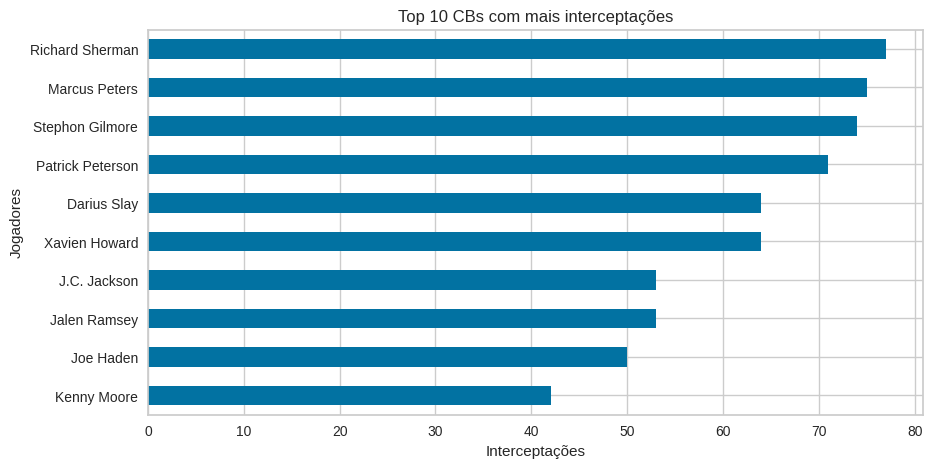

In [80]:
# Top CBs com mais interceptações
top_cbs_int = cbs.groupby('player_name')['interception'].sum().nlargest(10)
top_cbs_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

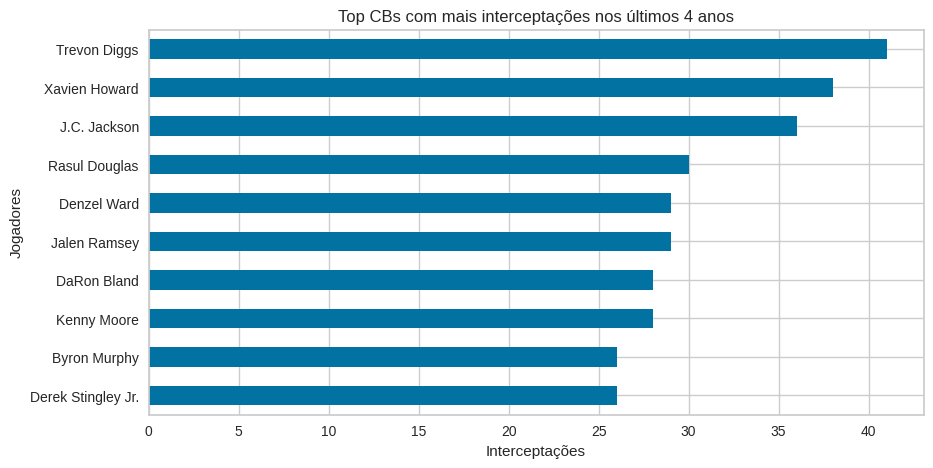

In [81]:
# Top CBs com mais interceptações nos últimos 4 anos
top_cbs_int_recente = cbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_cbs_int_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

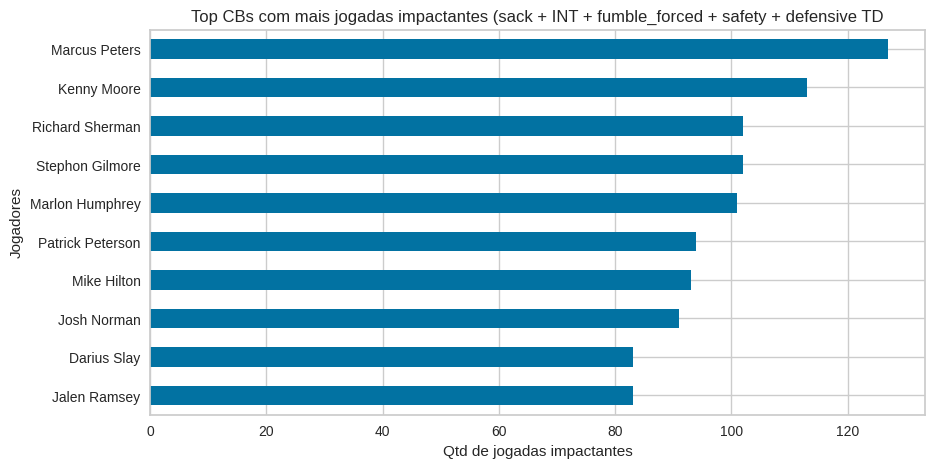

In [82]:
# Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_cbs_impact = cbs.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_cbs_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

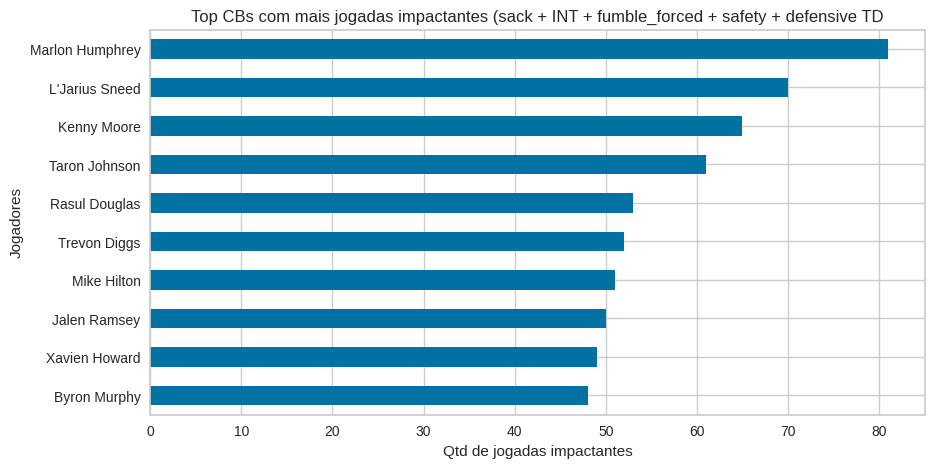

In [83]:
# Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_cbs_impact_recente = cbs_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_cbs_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

####**Safeties(FS, SS, S)**

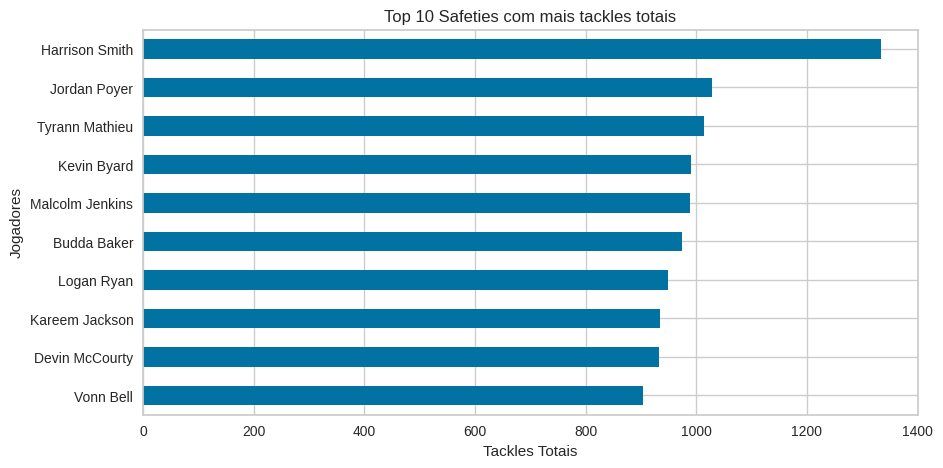

In [84]:
# Top Safeties com mais tackles totais
safeties = df_defesa_limpo[(df_defesa_limpo['position'] == 'FS') | (df_defesa_limpo['position'] == 'SS') | (df_defesa_limpo['position'] == 'S')]
top_safeties_tackles = safeties.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_safeties_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Safeties com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

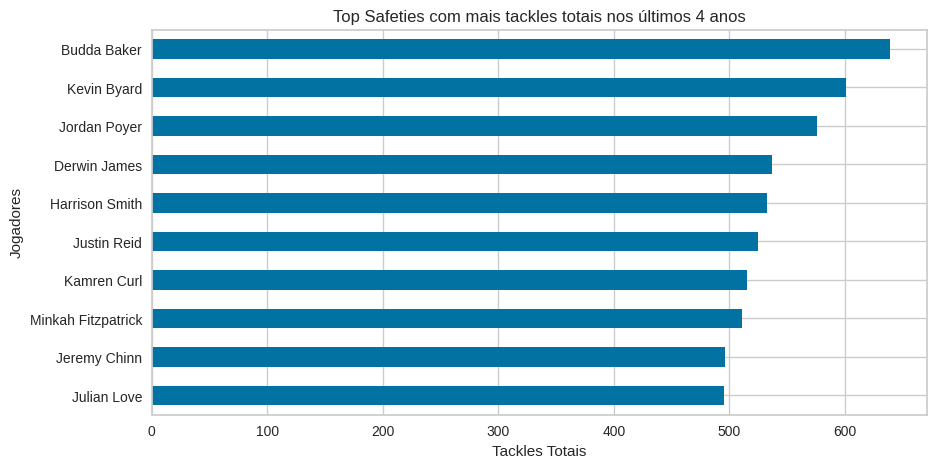

In [85]:
# Top CBs com mais tackles totais nos últimos 4 anos
safeties_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'FS') | (df_defesa_limpo['position'] == 'SS') | (df_defesa_limpo['position'] == 'S'))
& (df_defesa_limpo['season'] >= 2020)]
top_safeties_tackles_recente = safeties_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_safeties_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Safeties com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

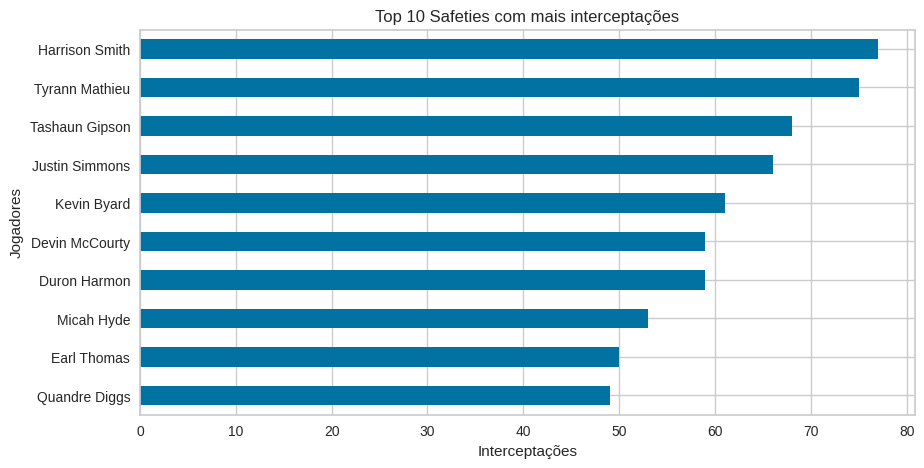

In [86]:
# Top Safeties com mais interceptações
top_safeties_int = safeties.groupby('player_name')['interception'].sum().nlargest(10)
top_safeties_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Safeties com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

In [87]:
# Top Safeties com mais interceptações nos últimos 4 anos
top_safeties_int_recentes = safeties_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_safeties_int_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Safeties com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

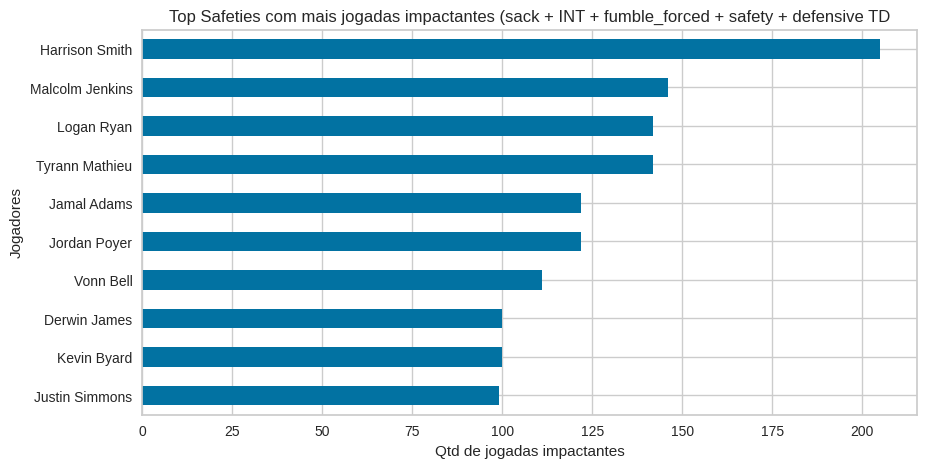

In [88]:
# Top safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_safeties_impact = safeties.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_safeties_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

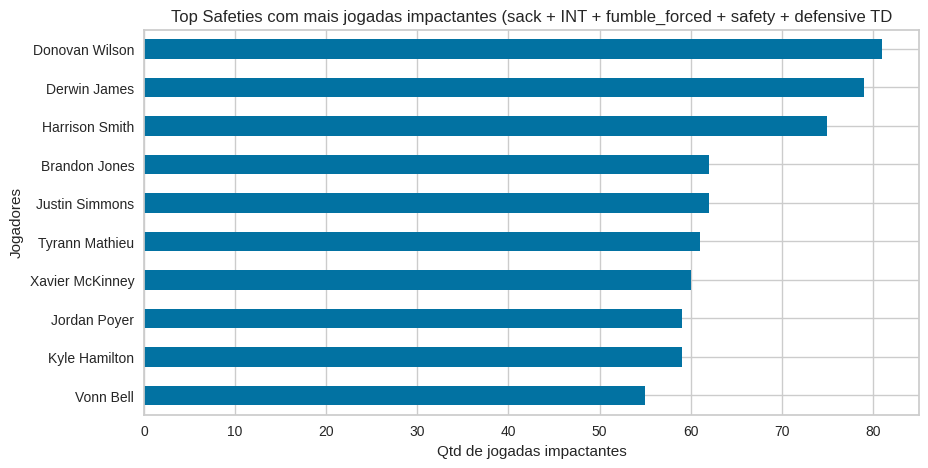

In [89]:
# Top Safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_safeties_impact_recente = safeties_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_safeties_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

####**Linebackers (ILB, OLB, MLB, LB)**

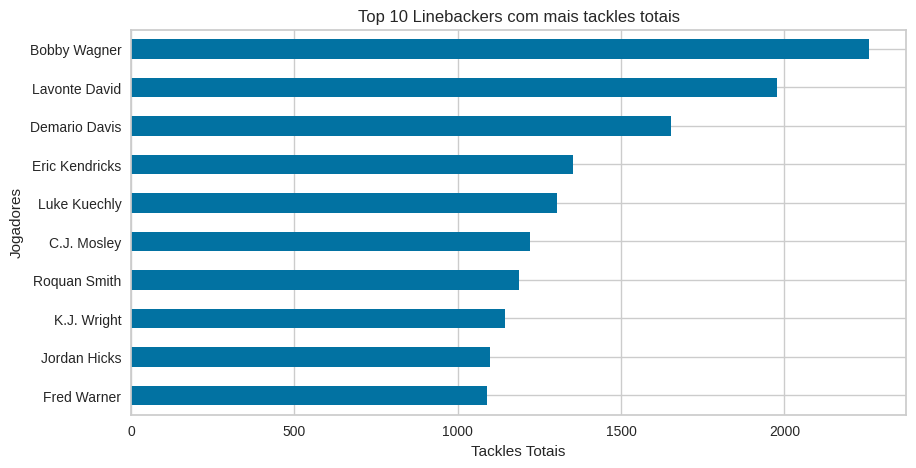

In [90]:
# Top Linebackers com mais tackles totais
lbs = df_defesa_limpo[(df_defesa_limpo['position'] == 'ILB') | (df_defesa_limpo['position'] == 'OLB') | (df_defesa_limpo['position'] == 'MLB') |
                      (df_defesa_limpo['position'] == 'LB')]
top_lbs_tackles = lbs.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_lbs_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

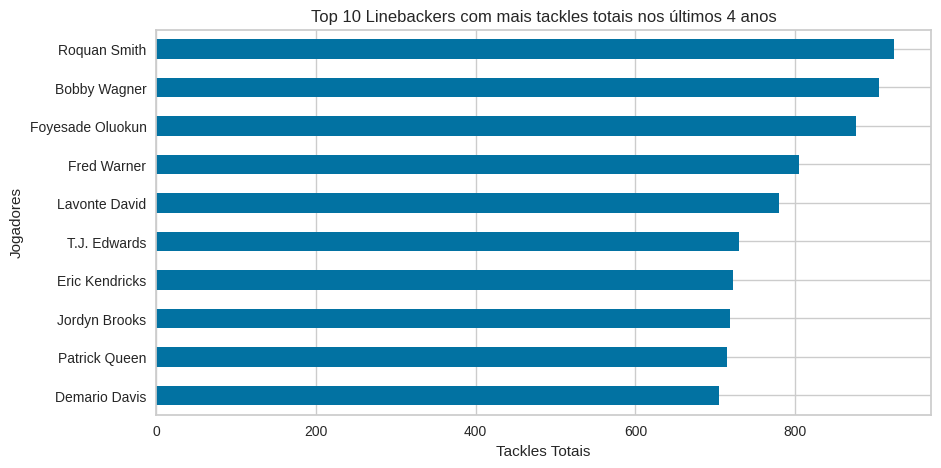

In [91]:
# Top Linebackers com mais tackles totais nos últimos 4 anos
lbs_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'ILB') | (df_defesa_limpo['position'] == 'OLB') | (df_defesa_limpo['position'] == 'MLB') |
                      (df_defesa_limpo['position'] == 'LB'))
& (df_defesa_limpo['season'] >= 2020)]
top_lbs_tackles_recente = lbs_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_lbs_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

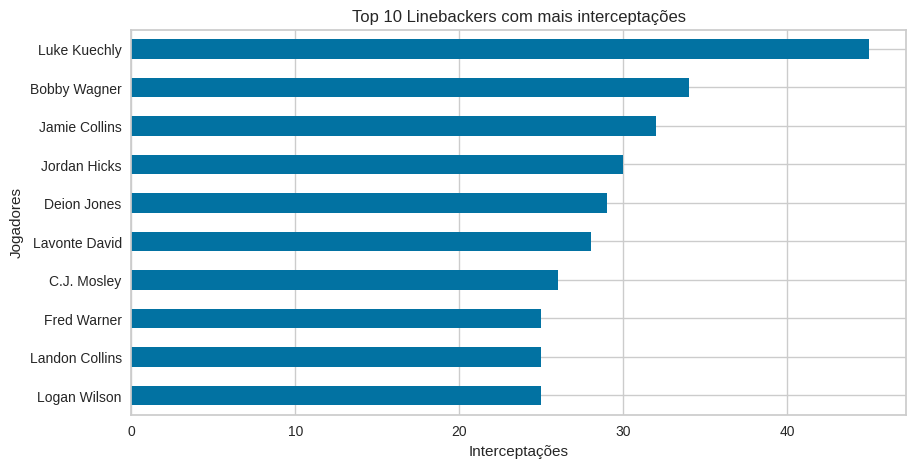

In [92]:
# Top Linebackers com mais interceptações
top_lbs_int = lbs.groupby('player_name')['interception'].sum().nlargest(10)
top_lbs_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

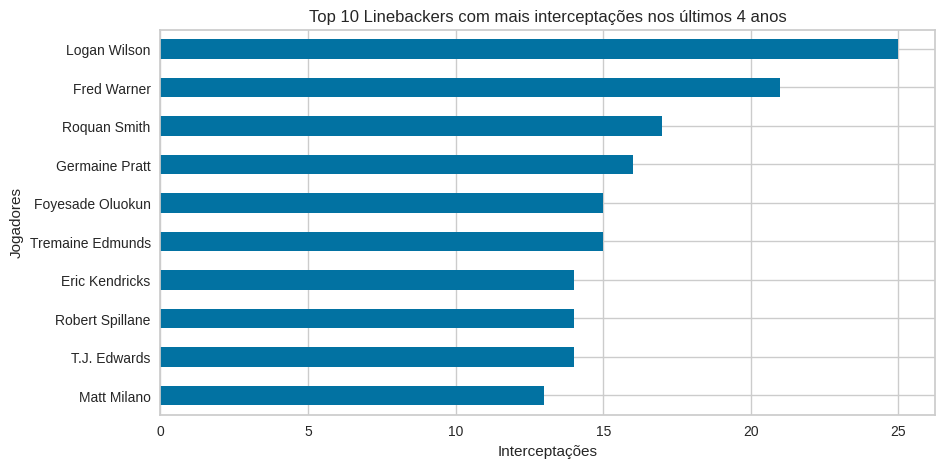

In [93]:
# Top Linebackers com mais interceptações nos últimos 4 anos
top_lbs_int_recentes = lbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_lbs_int_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

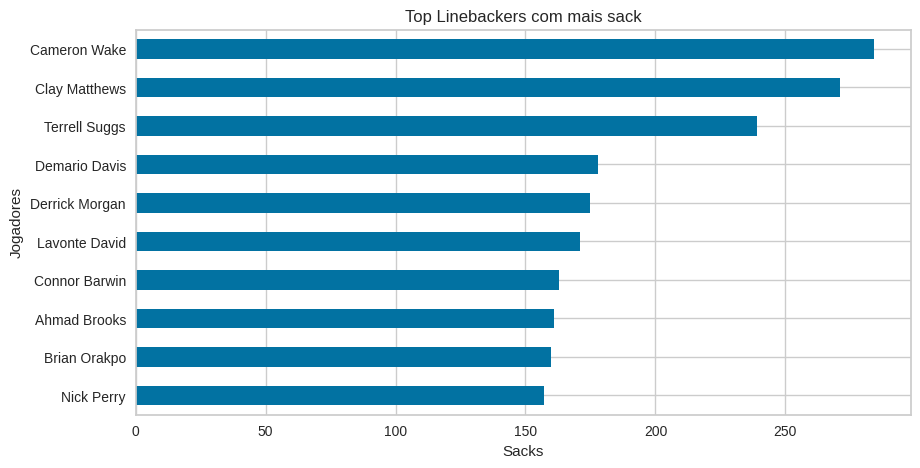

In [94]:
# Top Linebackers com mais sacks
top_lbs_sack = lbs.groupby('player_name')['sack'].sum().nlargest(10)
top_lbs_sack.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais sack')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

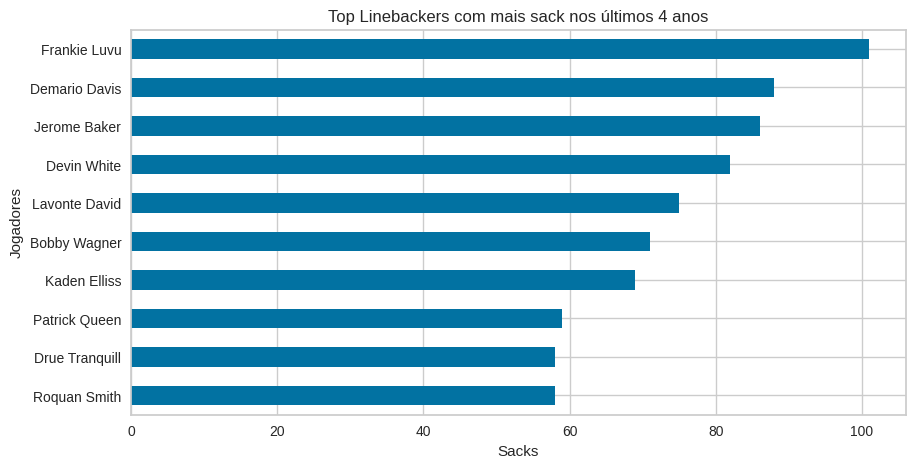

In [95]:
# Top Linebackers com mais sacks nos últimos 4 anos
top_lbs_sack_recente = lbs_recentes.groupby('player_name')['sack'].sum().nlargest(10)
top_lbs_sack_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais sack nos últimos 4 anos')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

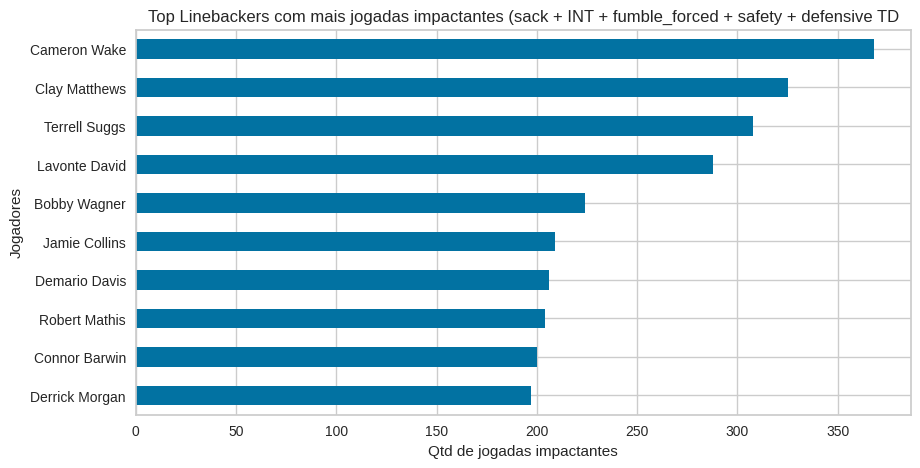

In [96]:
# Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_lbs_impact = lbs.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_lbs_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

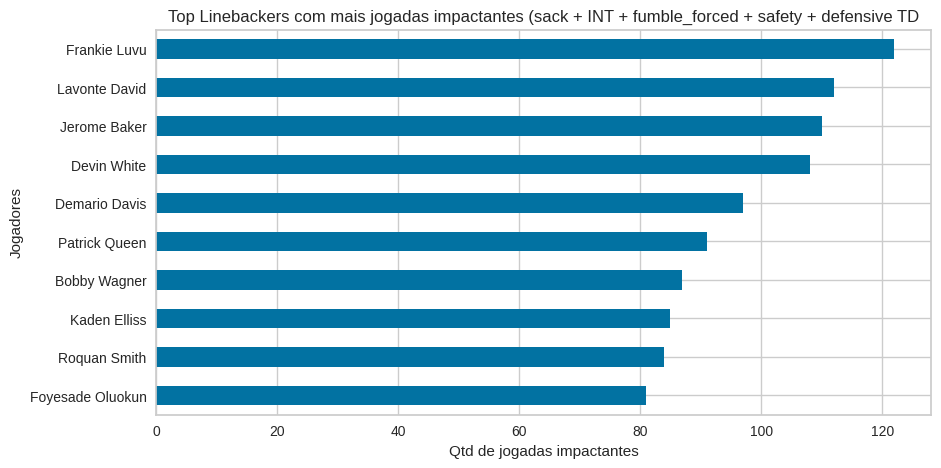

In [97]:
# Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_lbs_impact_recente = lbs_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_lbs_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

####**Defensives Lineman (DE, NT, DT e T)**

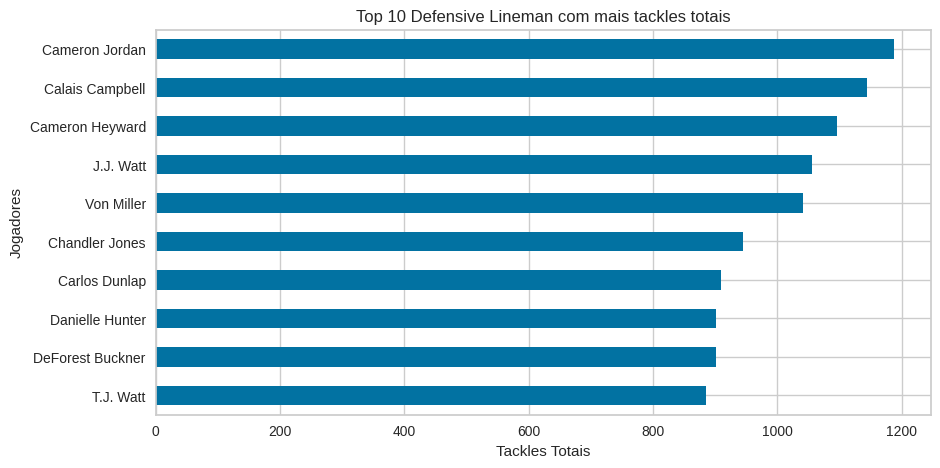

In [98]:
# Top Defensives Lineman com mais tackles totais
dl = df_defesa_limpo[(df_defesa_limpo['position'] == 'DE') | (df_defesa_limpo['position'] == 'NT') | (df_defesa_limpo['position'] == 'DT') |
                      (df_defesa_limpo['position'] == 'T')]
top_dl_tackles = dl.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_dl_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Defensive Lineman com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

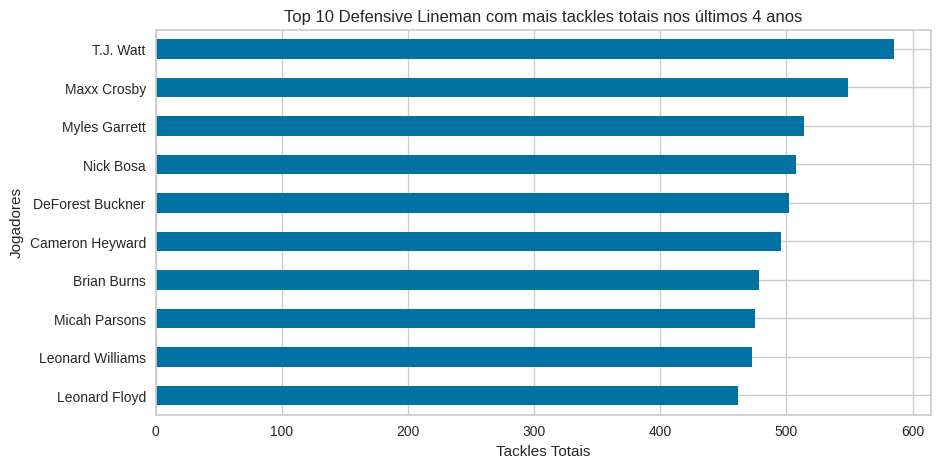

In [99]:
# Top Defensives Lineman com mais tackles totais nos últimos 4 anos
dl_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'DE') | (df_defesa_limpo['position'] == 'NT') | (df_defesa_limpo['position'] == 'DT') |
                      (df_defesa_limpo['position'] == 'T'))
& (df_defesa_limpo['season'] >= 2020)]
top_dl_tackles_recente = dl_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_dl_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Defensive Lineman com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

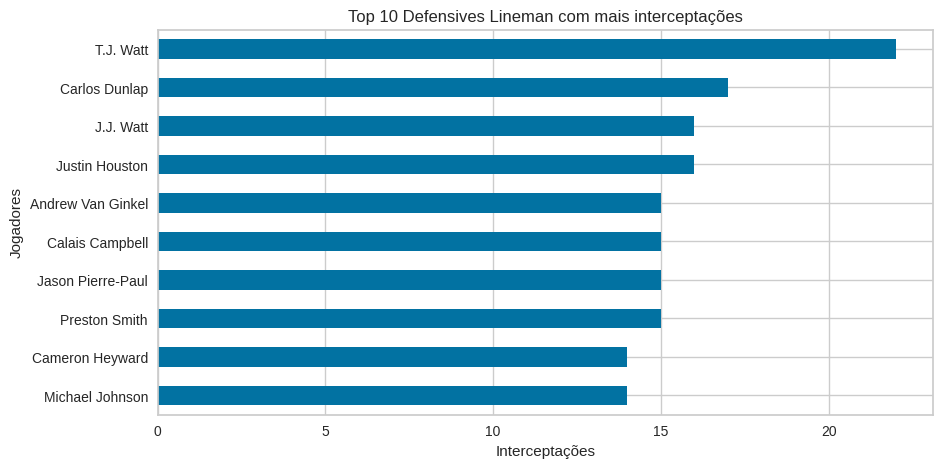

In [100]:
# Top Defensives Lineman com mais interceptações
top_dl_int = dl.groupby('player_name')['interception'].sum().nlargest(10)
top_dl_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Defensives Lineman com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

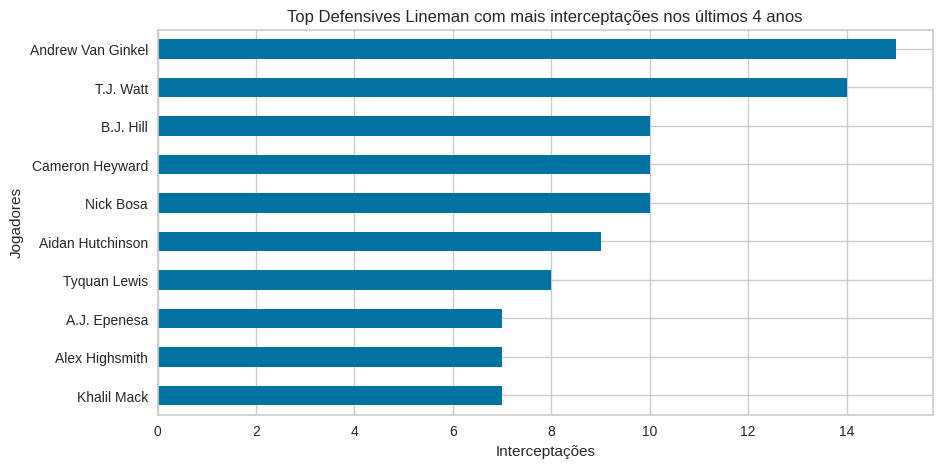

In [101]:
# Top Defensives Lineman com mais interceptações nos últimos 4 anos
top_dl_int_recentes = dl_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_dl_int_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

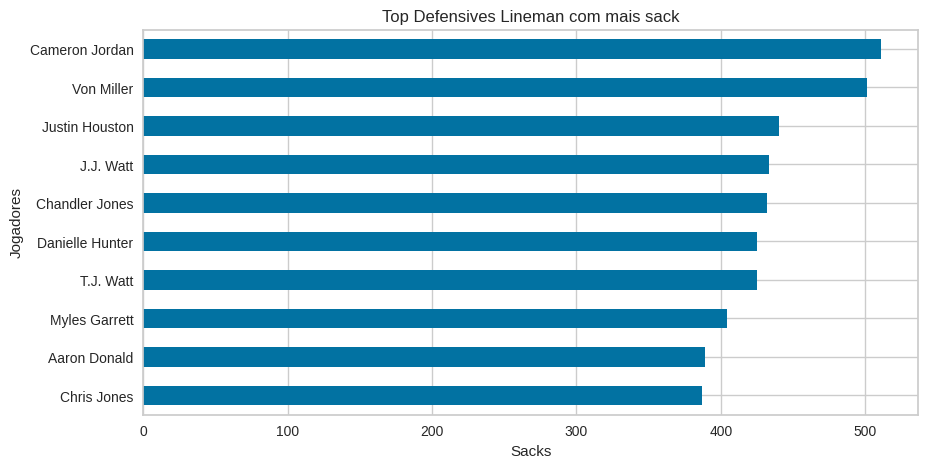

In [102]:
# Top Defensives Lineman com mais sacks
top_dl_sack = dl.groupby('player_name')['sack'].sum().nlargest(10)
top_dl_sack.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais sack')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

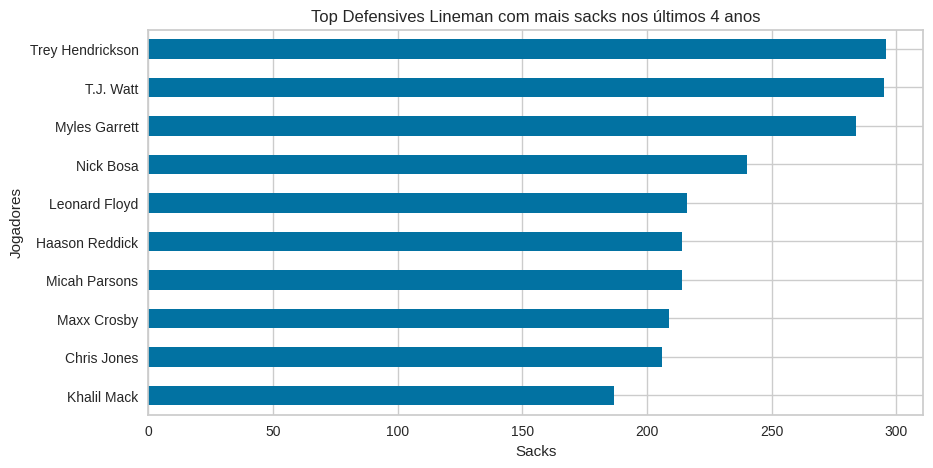

In [103]:
# Top Defensives Lineman com mais sacks nos últimos 4 anos
top_dl_sack_recente = dl_recentes.groupby('player_name')['sack'].sum().nlargest(10)
top_dl_sack_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais sacks nos últimos 4 anos')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

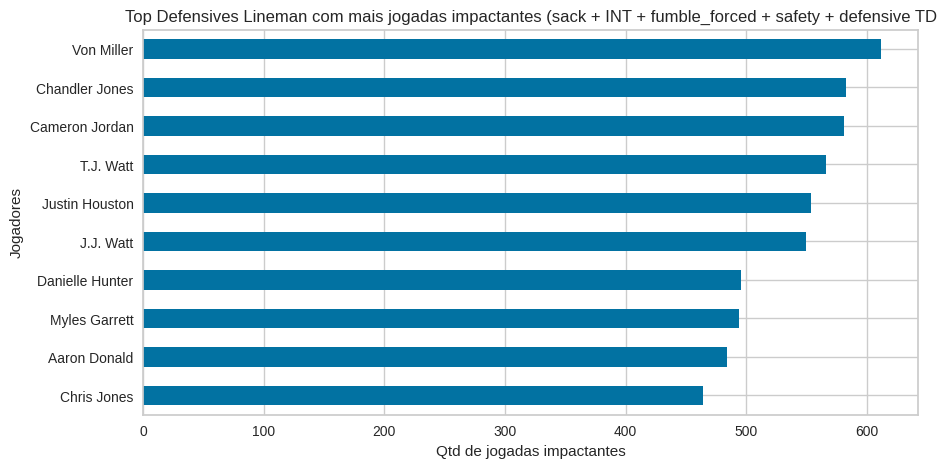

In [104]:
# Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_dl_impact = dl.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_dl_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

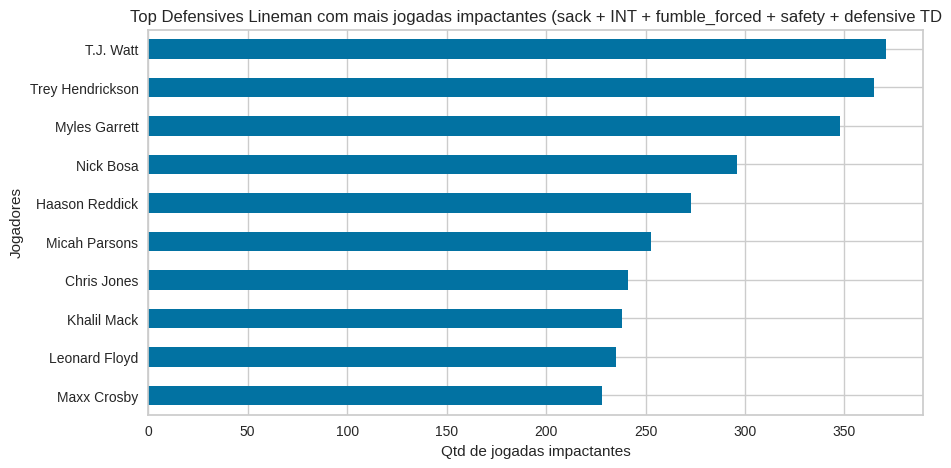

In [105]:
# Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_dl_impact_recente = dl_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_dl_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

Tackles por jogo: 2012 → 2024
Tackles por jogo na primeira temporada: 2790
Tackles por jogo na última temporada: 3512
Variação percentual entre primeira e última: 25.9%


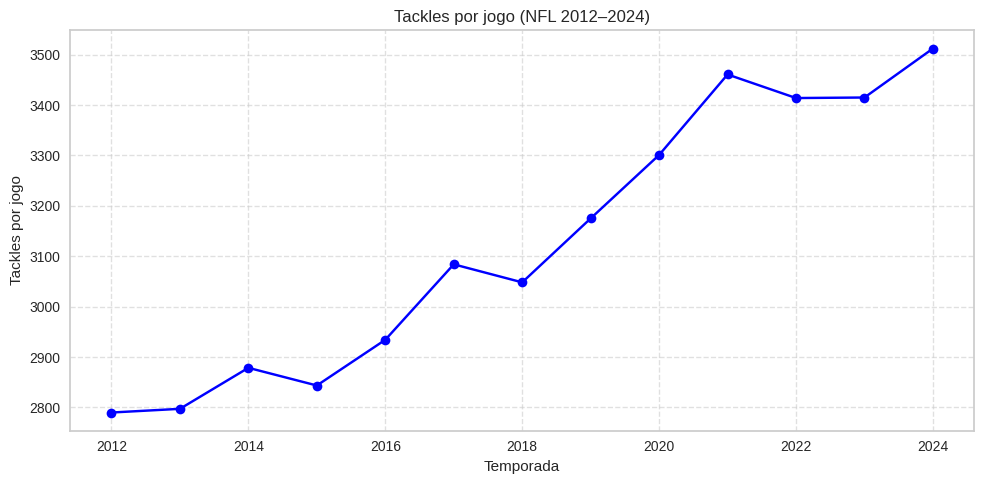

In [106]:
# Agrupando tackles por jogo por temporada
tackle_per_game_por_temporada = (
    df_defesa_limpo
    .groupby('season')['tackles_per_game']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = tackle_per_game_por_temporada['tackles_per_game'].iloc[0], tackle_per_game_por_temporada['tackles_per_game'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Tackles por jogo: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Tackles por jogo na primeira temporada: {primeira:.0f}")
print(f"Tackles por jogo na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(tackle_per_game_por_temporada['season'], tackle_per_game_por_temporada['tackles_per_game'], marker='o', color='blue')
plt.title('Tackles por jogo (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Tackles por jogo')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Sack: 2012 → 2024
Sack na primeira temporada: 4317.00
Sacks na última temporada: 5421.00
Variação percentual entre primeira e última: 25.6%


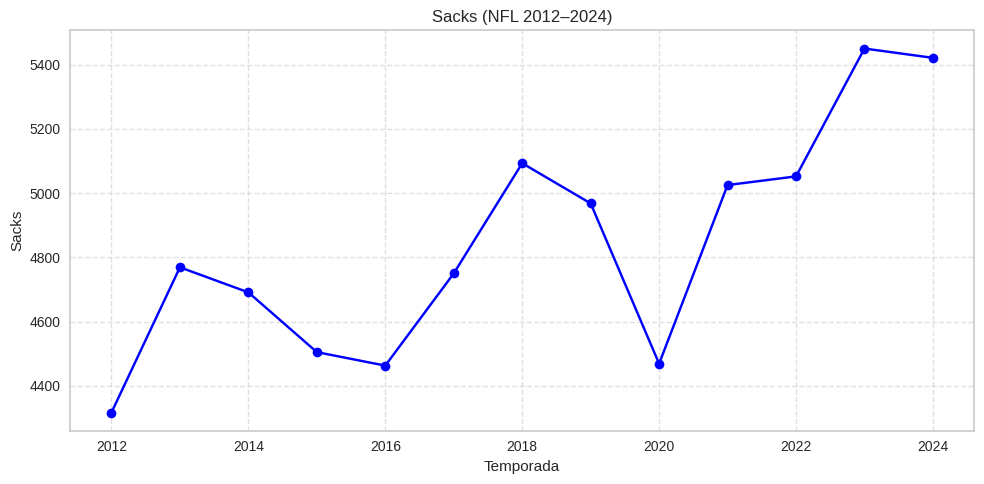

In [107]:
# Agrupando Sacks por temporada
sack_por_temporada = (
    df_defesa_limpo
    .groupby('season')['sack']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = sack_por_temporada['sack'].iloc[0], sack_por_temporada['sack'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Sack: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Sack na primeira temporada: {primeira:.2f}")
print(f"Sacks na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(sack_por_temporada['season'], sack_por_temporada['sack'], marker='o', color='blue')
plt.title('Sacks (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Sacks')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

QB HIT: 2012 → 2024
QB HIT na primeira temporada: 6018.00
QB HIT na última temporada: 7845.00
Variação percentual entre primeira e última: 30.4%


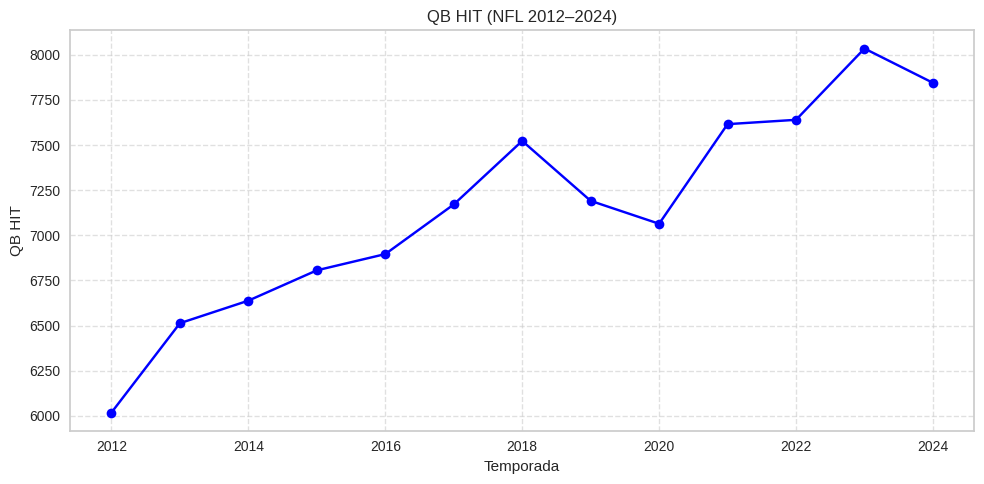

In [108]:
# Agrupando QB hit por temporada
qb_hit_por_temporada = (
    df_defesa_limpo
    .groupby('season')['qb_hit']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = qb_hit_por_temporada['qb_hit'].iloc[0], qb_hit_por_temporada['qb_hit'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"QB HIT: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"QB HIT na primeira temporada: {primeira:.2f}")
print(f"QB HIT na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(qb_hit_por_temporada['season'], qb_hit_por_temporada['qb_hit'], marker='o', color='blue')
plt.title('QB HIT (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('QB HIT')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Interceptações: 2012 → 2024
Interceptações na primeira temporada: 977.00
Interceptações na última temporada: 889.00
Variação percentual entre primeira e última: -9.0%


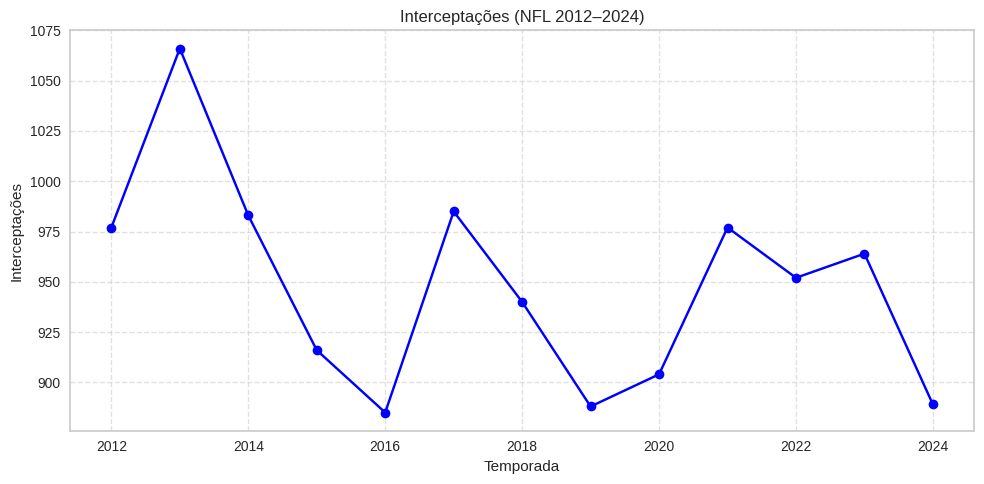

In [109]:
# Agrupando interceptações por temporada
int_por_temporada = (
    df_defesa_limpo
    .groupby('season')['interception']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = int_por_temporada['interception'].iloc[0], int_por_temporada['interception'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Interceptações: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Interceptações na primeira temporada: {primeira:.2f}")
print(f"Interceptações na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(int_por_temporada['season'], int_por_temporada['interception'], marker='o', color='blue')
plt.title('Interceptações (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Interceptações')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Touchdown Defensivos: 2012 → 2024
Touchdown Defensivos na primeira temporada: 157.00
Touchdown Defensivos na última temporada: 114.00
Variação percentual entre primeira e última: -27.4%


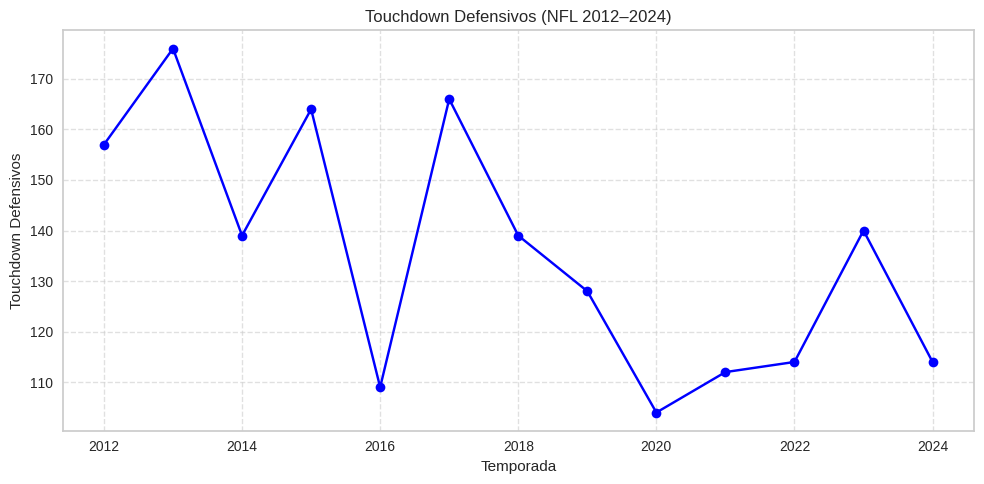

In [110]:
# Agrupando TD defensivos por temporada
td_defensivo_por_temporada = (
    df_defesa_limpo
    .groupby('season')['def_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_defensivo_por_temporada['def_touchdown'].iloc[0], td_defensivo_por_temporada['def_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Touchdown Defensivos: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Touchdown Defensivos na primeira temporada: {primeira:.2f}")
print(f"Touchdown Defensivos na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_defensivo_por_temporada['season'], td_defensivo_por_temporada['def_touchdown'], marker='o', color='blue')
plt.title('Touchdown Defensivos (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Touchdown Defensivos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jogadas Impactantes: 2012 → 2024
Jogadas Impactantes na primeira temporada: 6685.00
Jogadas Impactantes na última temporada: 7792.00
Variação percentual entre primeira e última: 16.6%


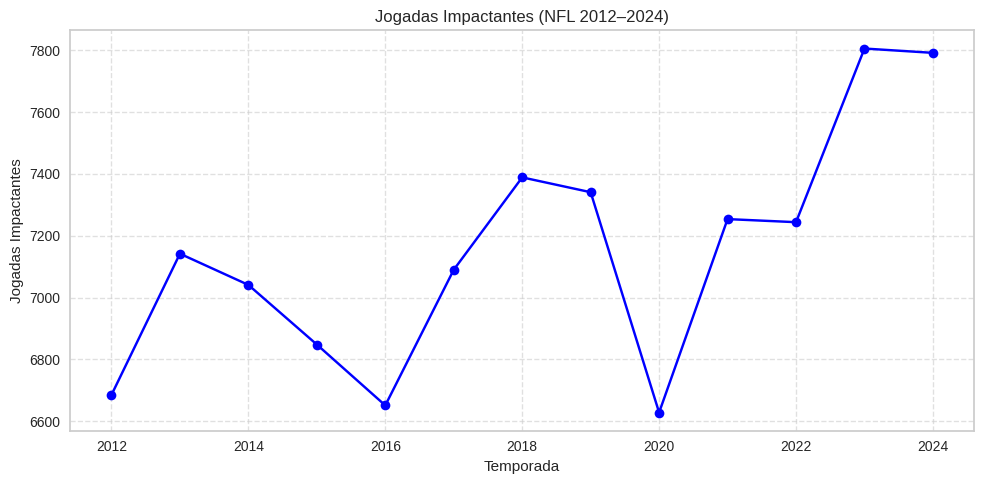

In [111]:
# Agrupando Jogadas Impactantes por temporada
impact_por_temporada = (
    df_defesa_limpo
    .groupby('season')['impact_plays']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = impact_por_temporada['impact_plays'].iloc[0], impact_por_temporada['impact_plays'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jogadas Impactantes: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Jogadas Impactantes na primeira temporada: {primeira:.2f}")
print(f"Jogadas Impactantes na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(impact_por_temporada['season'], impact_por_temporada['impact_plays'], marker='o', color='blue')
plt.title('Jogadas Impactantes (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jogadas Impactantes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

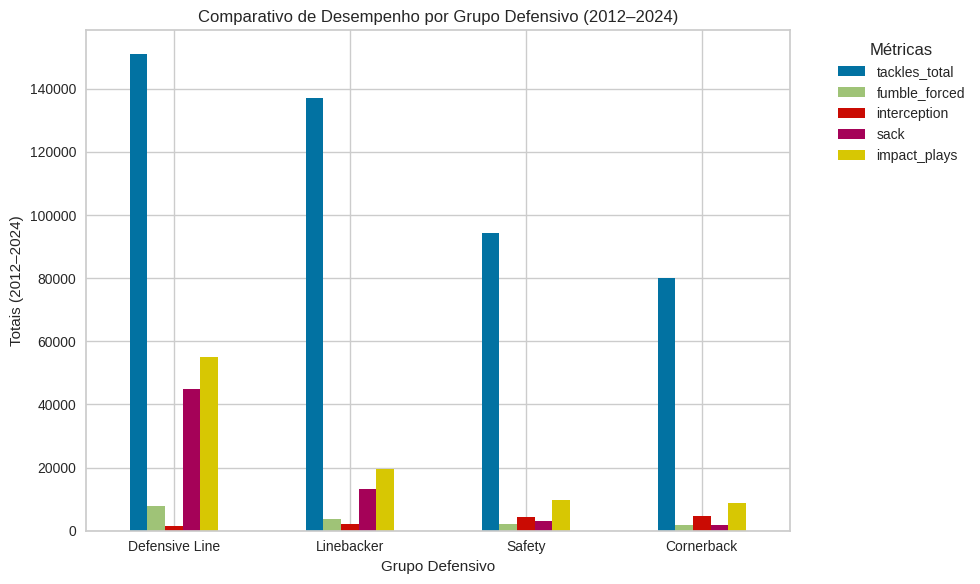

In [112]:
df_defesa_agrupada = df_defesa_limpo.copy()

# Dicionário para agrupar posições semelhantes
map_posicoes = {
    'FS': 'Safety', 'SS': 'Safety', 'S': 'Safety',
    'CB': 'Cornerback', 'DB': 'Cornerback',
    'ILB': 'Linebacker', 'OLB': 'Linebacker', 'MLB': 'Linebacker', 'LB': 'Linebacker',
    'DE': 'Defensive Line', 'NT': 'Defensive Line', 'DT': 'Defensive Line', 'T': 'Defensive Line'
}

# Criar uma nova coluna com o grupo de posição
df_defesa_agrupada['pos_agrupada'] = df_defesa_agrupada['position'].map(map_posicoes)

# Remover linhas com posições não defensivas (sem grupo)
df_defesa_grupos = df_defesa_agrupada.dropna(subset=['pos_agrupada'])

# Agrupar por grupo de posição e somar métricas relevantes
pos_agrupada_status = (
    df_defesa_grupos
    .groupby('pos_agrupada')[['tackles_total', 'fumble_forced', 'interception', 'sack', 'impact_plays']]
    .sum()
    .sort_values('impact_plays', ascending=False)
)

# Plotar gráfico
pos_agrupada_status.plot(
    kind='bar',
    figsize=(10,6),
    title='Comparativo de Desempenho por Grupo Defensivo (2012–2024)',
    rot=0
)

plt.xlabel('Grupo Defensivo')
plt.ylabel('Totais (2012–2024)')
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

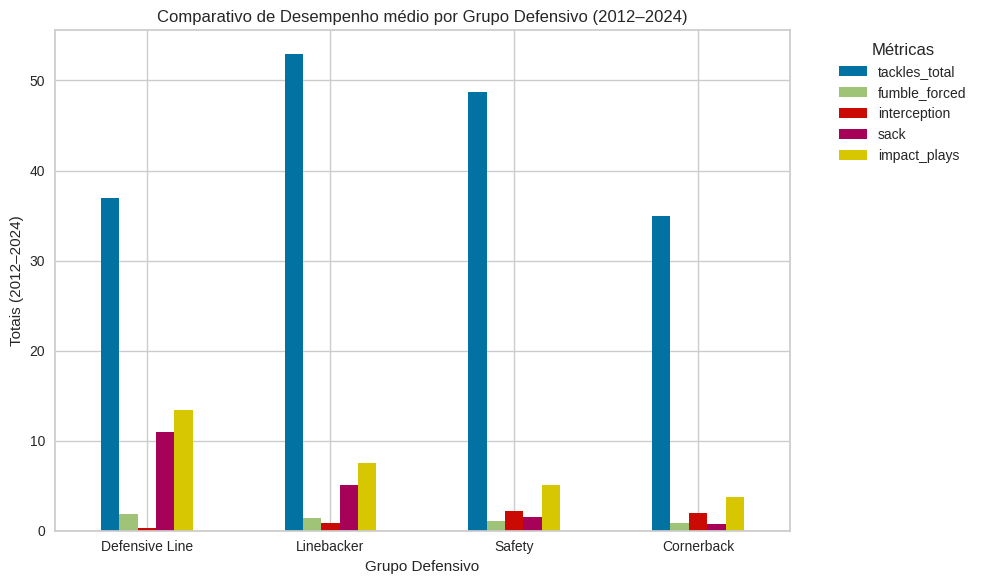

In [113]:
df_defesa_agrupada = df_defesa_limpo.copy()

# Dicionário para agrupar posições semelhantes
map_posicoes = {
    'FS': 'Safety', 'SS': 'Safety', 'S': 'Safety',
    'CB': 'Cornerback', 'DB': 'Cornerback',
    'ILB': 'Linebacker', 'OLB': 'Linebacker', 'MLB': 'Linebacker', 'LB': 'Linebacker',
    'DE': 'Defensive Line', 'NT': 'Defensive Line', 'DT': 'Defensive Line', 'T': 'Defensive Line'
}

# Criar uma nova coluna com o grupo de posição
df_defesa_agrupada['pos_agrupada'] = df_defesa_agrupada['position'].map(map_posicoes)

# Remover linhas com posições não defensivas (sem grupo)
df_defesa_grupos = df_defesa_agrupada.dropna(subset=['pos_agrupada'])

# Agrupar por grupo de posição e somar métricas relevantes
pos_agrupada_status = (
    df_defesa_grupos
    .groupby('pos_agrupada')[['tackles_total', 'fumble_forced', 'interception', 'sack', 'impact_plays']]
    .mean()
    .sort_values('impact_plays', ascending=False)
)

# Plotar gráfico
pos_agrupada_status.plot(
    kind='bar',
    figsize=(10,6),
    title='Comparativo de Desempenho médio por Grupo Defensivo (2012–2024)',
    rot=0
)

plt.xlabel('Grupo Defensivo')
plt.ylabel('Totais (2012–2024)')
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**Ataque**

In [114]:
media_ataque = (
    df_ataque_limpo
    .groupby('season')[['pass_attempts', 'complete_pass', 'passing_yards', 'pass_touchdown', 'interception',
    'passer_rating', 'comp_pct', 'ypa', 'rush_attempts', 'rushing_yards', 'rush_touchdown',
    'fumble', 'fumble_lost', 'ypc', 'targets', 'receptions', 'receiving_yards',
    'receiving_touchdown', 'yards_after_catch', 'yptarget', 'ypr', 'total_yards',
    'total_tds', 'fantasy_points_ppr', 'fantasy_points_standard', 'season_ypg',
    'season_yptouch', 'season_average_ppr_ppg', 'offense_snaps', 'offense_pct',
    'yards_per_pass_attempt', 'yards_per_carry', 'yards_per_reception',
    'catch_rate', 'touches', 'yards_per_touch']]
    .mean()
    .reset_index()
)

# Exibir as 5 primeiras linhas
media_ataque.head()



season  pass_attempts  complete_pass  passing_yards  pass_touchdown  \
0    2012      40.732673      25.460396     296.386139        3.376238   
1    2013      37.924939      24.024213     279.648910        3.326877   
2    2014      35.034115      22.556503     258.172708        3.127932   
3    2015      38.073333      24.557778     284.031111        3.382222   
4    2016      34.562130      22.325444     254.021696        2.901381   

   interception  passer_rating  comp_pct       ypa  rush_attempts  ...  \
0      2.014851      11.419703  0.106094  1.569183      29.076733  ...   
1      2.070218      14.826538  0.106203  1.346780      27.881356  ...   
2      1.727079       8.774606  0.103333  1.292559      24.159915  ...   
3      1.768889      12.624111  0.101573  1.198244      24.302222  ...   
4      1.516765      11.331499  0.094625  1.196469      22.704142  ...   

   season_yptouch  season_average_ppr_ppg  offense_snaps  offense_pct  \
0        9.106411                8.870767     392.925743     0.561184   
1        9.077966                8.415593     383.702179     0.557074   
2        8.955096                8.290341     348.910448     0.547732   
3        9.274733                8.532267     368.315556     0.550887   
4        8.785878                7.998245     334.220907     0.516303   

   yards_per_pass_attempt  yards_per_carry  yards_per_reception  catch_rate  \
0                1.569161         2.580245             8.935442    0.553398   
1                1.346708         2.501310             8.830591    0.534468   
2                1.292635         2.213235             8.642082    0.547873   
3                1.198216         2.215143             9.117864    0.552171   
4                1.196508         2.371203             8.530652    0.560612   

     touches  yards_per_touch  
0  50.754950        24.159017  
1  49.682809        23.582945  
2  44.371002        20.699303  
3  45.671111        21.841072  
4  42.390533        21.679484  

[5 rows x 37 columns]

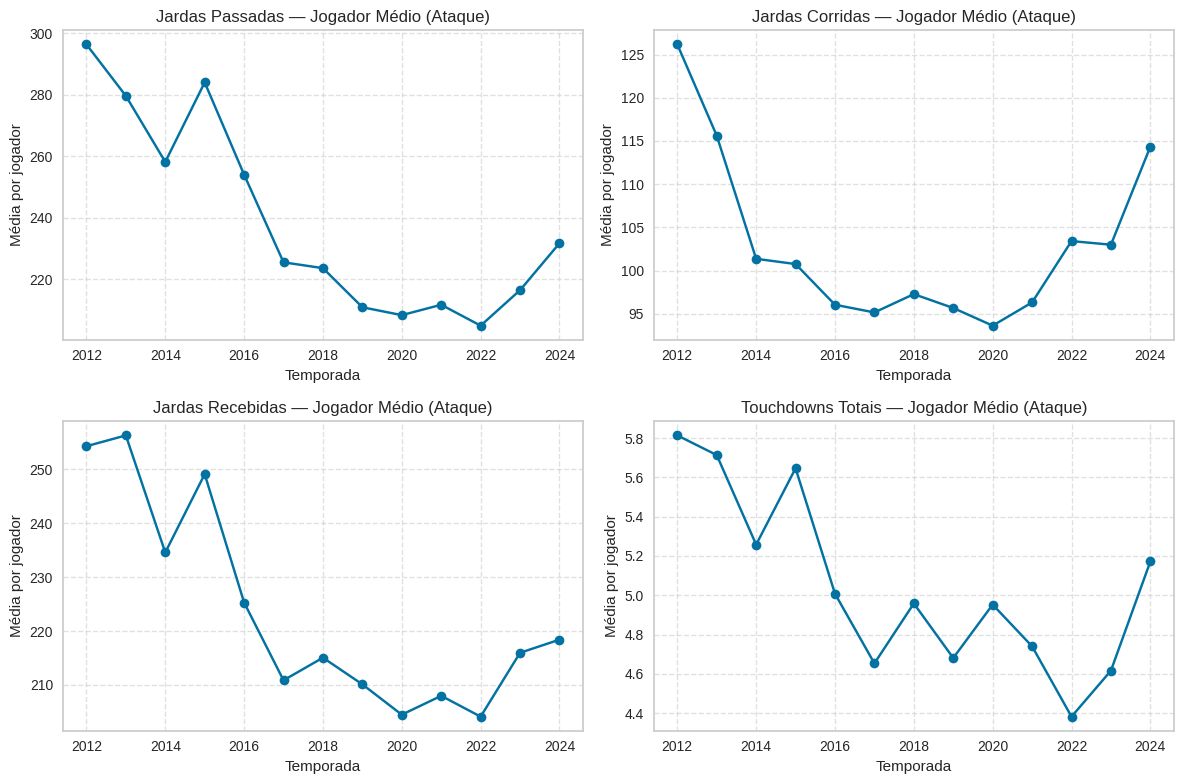

In [115]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

cols = ['passing_yards', 'rushing_yards', 'receiving_yards', 'total_tds']
titles = ['Jardas Passadas', 'Jardas Corridas', 'Jardas Recebidas', 'Touchdowns Totais']

for i, col in enumerate(cols):
    axes[i].plot(media_ataque['season'], media_ataque[col], marker='o')
    axes[i].set_title(f'{titles[i]} — Jogador Médio (Ataque)')
    axes[i].set_xlabel('Temporada')
    axes[i].set_ylabel('Média por jogador')
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()




###**Defesa**

In [116]:
media_defesa = (
    df_defesa_limpo
    .groupby('season')[['solo_tackle',
       'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit', 'interception',
       'fumble_forced', 'safety', 'def_touchdown', 'defense_snaps',
       'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard',
       'tackles_total', 'sack_rate', 'tackles_per_game', 'impact_plays']]
    .mean()
    .reset_index()
)

# Exibir as 5 primeiras linhas
media_defesa.head()

season  solo_tackle  assist_tackle  tackle_with_assist      sack    qb_hit  \
0    2012    30.403485      13.250670            4.608579  5.786863  8.067024   
1    2013    30.535475      13.560910            4.613119  6.384203  8.718876   
2    2014    29.832680      13.232680            4.278431  6.132026  8.677124   
3    2015    29.238710      12.651613            4.122581  5.812903  8.781935   
4    2016    28.762733      12.813665            4.001242  5.544099  8.566460   

   interception  fumble_forced    safety  def_touchdown  defense_snaps  \
0      1.309651       1.605898  0.048257       0.210456     443.071046   
1      1.427041       1.441767  0.072289       0.235609     447.109772   
2      1.284967       1.534641  0.070588       0.181699     433.618301   
3      1.181935       1.588387  0.041290       0.211613     427.332903   
4      1.099379       1.422360  0.060870       0.135404     423.392547   

   defense_pct  fantasy_points_ppr  fantasy_points_standard  tackles_total  \
0     0.571963                 0.0                      0.0      43.654155   
1     0.558312                 0.0                      0.0      44.096386   
2     0.557270                 0.0                      0.0      43.065359   
3     0.550113                 0.0                      0.0      41.890323   
4     0.545732                 0.0                      0.0      41.576398   

   sack_rate  tackles_per_game  impact_plays  
0   0.012735          3.739940      8.961126  
1   0.014100          3.744739      9.560910  
2   0.015206          3.762974      9.203922  
3   0.014767          3.669158      8.836129  
4   0.015085          3.645067      8.262112

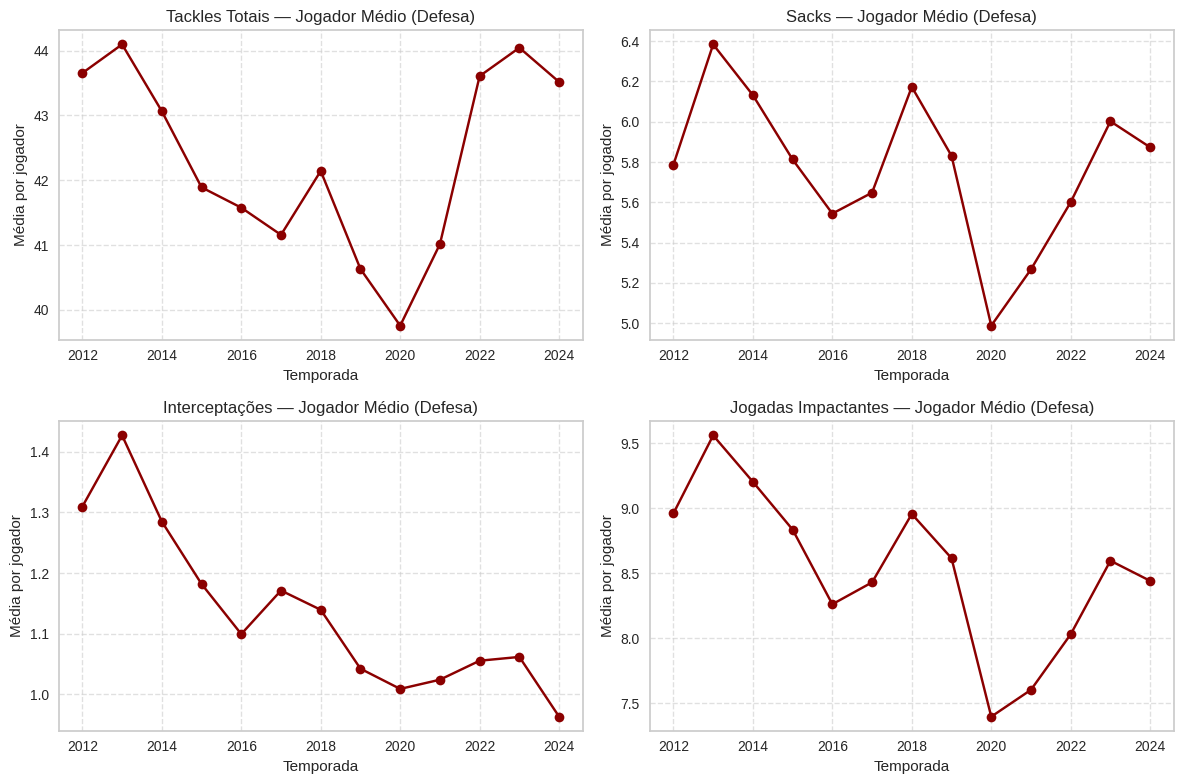

In [117]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

cols = ['tackles_total', 'sack', 'interception', 'impact_plays']
titles = ['Tackles Totais', 'Sacks', 'Interceptações', 'Jogadas Impactantes']

for i, col in enumerate(cols):
    axes[i].plot(media_defesa['season'], media_defesa[col], marker='o', color='darkred')
    axes[i].set_title(f'{titles[i]} — Jogador Médio (Defesa)')
    axes[i].set_xlabel('Temporada')
    axes[i].set_ylabel('Média por jogador')
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


##**Machine Learning**

In [118]:
# Função avaliar o resultado das métricas dos modelos
def avaliar_modelos_clusterizacao(X, modelo_base, k_min=2, k_max=10, metricas=None):
  if metricas is None:
    metricas = [silhouette_score, davies_bouldin_score, calinski_harabasz_score]
    resultados = []
    for k in range(k_min, k_max + 1):
      modelo = clone(modelo_base)
      # Para modelos como KMeans e AgglomerativeClustering que aceitam n_clusters
      if hasattr(modelo, 'n_clusters'):
        modelo.set_params(n_clusters=k)
        labels = modelo.fit_predict(X)
        linha_resultado = {'k': k}
        for metrica in metricas:
          try:
            linha_resultado[metrica.__name__] = metrica(X, labels)
          except:
            linha_resultado[metrica.__name__] = None  # Caso a métrica falhe
        resultados.append(linha_resultado)

    return pd.DataFrame(resultados).set_index('k')

###**Ataque**

In [119]:
def make_df_summary_generic(df_mean, features=None):
    """
    Cria um resumo médio (df_summary) agrupado por cluster,
    para qualquer posição (QB, WR, RB, TE etc.).
    """
    if 'cluster' not in df_mean.columns:
        raise ValueError("O dataframe precisa ter a coluna 'cluster'.")

    # Se features não forem passadas, detecta automaticamente
    if features is None:
        possible_features = [
            # QBs
            'passing_yards', 'rushing_yards', 'pass_touchdown', 'interception',
            # WRs
            'targets', 'receptions', 'receiving_yards', 'receiving_touchdown',
            'yards_after_catch', 'catch_rate', 'yards_per_reception',
            # RBs
            'rush_attempts', 'rush_touchdown', 'yards_per_carry', 'fumbles',
            # Gerais / Fantasy
            'total_yards', 'total_tds', 'fantasy_points_ppr', 'touches', 'yards_per_touch'
        ]
        features = [f for f in possible_features if f in df_mean.columns]

    if len(features) == 0:
        raise ValueError("Nenhuma feature válida encontrada no dataframe.")

    df_summary = df_mean.groupby('cluster')[features].mean().round(2)
    return df_summary


def plot_radar_clusters_generic(df_or_mean, posicao='Jogador', features=None):
    """
    Plota um radar chart comparando o perfil médio dos clusters,
    funcionando automaticamente para qualquer posição.
    """
    # Detecta se o DataFrame é o original (com coluna 'cluster')
    if isinstance(df_or_mean, pd.DataFrame) and 'cluster' in df_or_mean.columns:
        df_summary = make_df_summary_generic(df_or_mean, features)
    else:
        df_summary = df_or_mean.copy()
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Define features caso não tenham sido passadas
    if features is None:
        features = df_summary.columns.tolist()

    if len(features) == 0:
        raise ValueError("Nenhuma feature válida para plotar o radar.")

    # Normaliza os dados 0–1
    df_norm = (df_summary[features] - df_summary[features].min()) / (
        df_summary[features].max() - df_summary[features].min()
    )

    # Ângulos para cada variável
    N = len(features)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    # Plot
    plt.figure(figsize=(7, 7))
    plt.suptitle(f'Perfis Médios dos Clusters — {posicao}', fontsize=16, fontweight='bold')

    for cluster_id, row in df_norm.iterrows():
        values = row.tolist()
        values += values[:1]
        plt.polar(angles, values, label=f'Cluster {cluster_id}', linewidth=2)
        plt.fill(angles, values, alpha=0.1)

    plt.xticks(angles[:-1], features, fontsize=10)
    plt.yticks(np.linspace(0, 1, 5), [], color='gray', size=8)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

####**QB**

In [120]:
# Features importantes para o ataque
features_cluster_qb = [
    'pass_attempts', 'complete_pass', 'passing_yards', 'pass_touchdown',
    'interception', 'passer_rating', 'rush_attempts', 'rushing_yards',
    'rush_touchdown', 'fumble', 'total_yards', 'total_tds', 'offense_snaps',
    'fantasy_points_ppr'
]

In [121]:
# Agrupar por jogador e calcular a média de suas estatísticas ao longo dos anos
qbs_mean = (
    qbs.groupby(['player_id', 'player_name', 'position'])
    [features_cluster_qb]
    .mean()
    .reset_index()
)

# Preencher valores nulos com 0
X_qbs = qbs_mean[features_cluster_qb].fillna(0)

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_qbs)

# Rodar o KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
qbs_mean["cluster"] = kmeans.fit_predict(X_scaled)


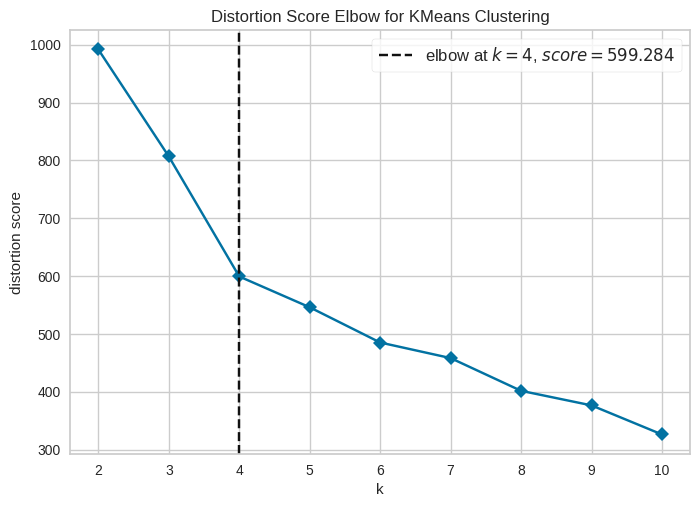

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [122]:
# Plotando o gráfico do Cotovelo pra descobrir o K
kelbow_visualizer(KMeans(), X_scaled, k=10, timings=False)

In [124]:
# Chamando a função para avaliar as métricas do Kmeans
resultados_kmeans = avaliar_modelos_clusterizacao(X_scaled, KMeans(random_state=42))
resultados_kmeans.style.background_gradient()

In [125]:
# Calcula médias das principais features por cluster
cluster = qbs_mean.groupby('cluster')[features_cluster_qb].mean().round(2)

# Mostra o resumo
cluster

pass_attempts  complete_pass  passing_yards  pass_touchdown  \
cluster                                                                
0                49.48          29.93         313.00            1.28   
1               371.36         244.01        2730.27           17.31   
2               176.79         110.90        1215.28            6.23   
3               310.58         201.95        2275.46           15.06   

         interception  passer_rating  rush_attempts  rushing_yards  \
cluster                                                              
0                1.71          61.22           6.32          21.36   
1                8.54          91.74          33.32         142.07   
2                5.26          75.88          19.48          83.31   
3                7.15          91.38          82.46         454.67   

         rush_touchdown  fumble  total_yards  total_tds  offense_snaps  \
cluster                                                                  
0                  0.17    1.10       334.55       1.45         102.93   
1                  1.28    5.70      2872.70      18.61         717.87   
2                  0.86    3.25      1300.93       7.13         361.98   
3                  4.74    5.93      2730.69      19.91         674.39   

         fantasy_points_ppr  
cluster                      
0                     18.48  
1                    210.41  
2                     85.07  
3                    235.84

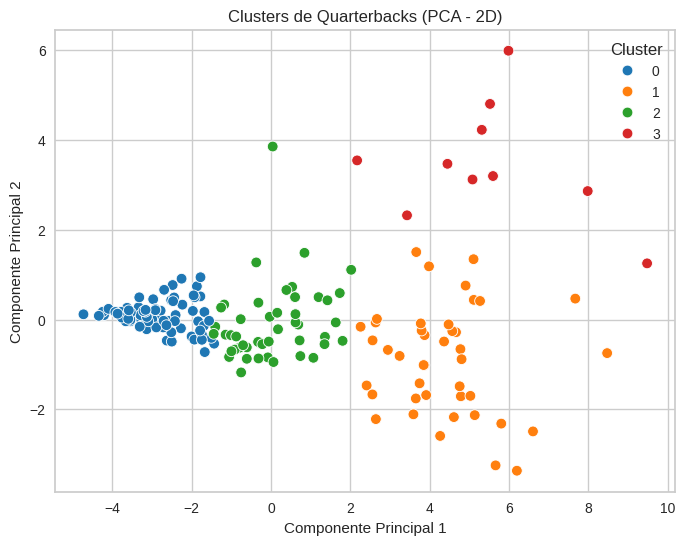

In [126]:
# Rodar o modelo final com k=4
kmeans_qb = KMeans(n_clusters=4, random_state=42)
qbs_mean['cluster'] = kmeans_qb.fit_predict(X_scaled)

# Criar o resumo médio por cluster
df_summary = qbs_mean.groupby('cluster')[[
    'passing_yards', 'rushing_yards', 'pass_touchdown',
    'interception', 'fantasy_points_ppr'
]].mean()


# Reduzindo para 2 dimensões com PCA
pca = PCA(n_components=2)
qbs_pca = pca.fit_transform(X_scaled)

# Adicionando os componentes principais ao dataframe
qbs_mean['pca1'] = qbs_pca[:, 0]
qbs_mean['pca2'] = qbs_pca[:, 1]

# Plotando os clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=qbs_mean, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters de Quarterbacks (PCA - 2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()


In [127]:
qbs_mean['cluster'].value_counts()


cluster
0    84
2    46
1    42
3    10
Name: count, dtype: int64

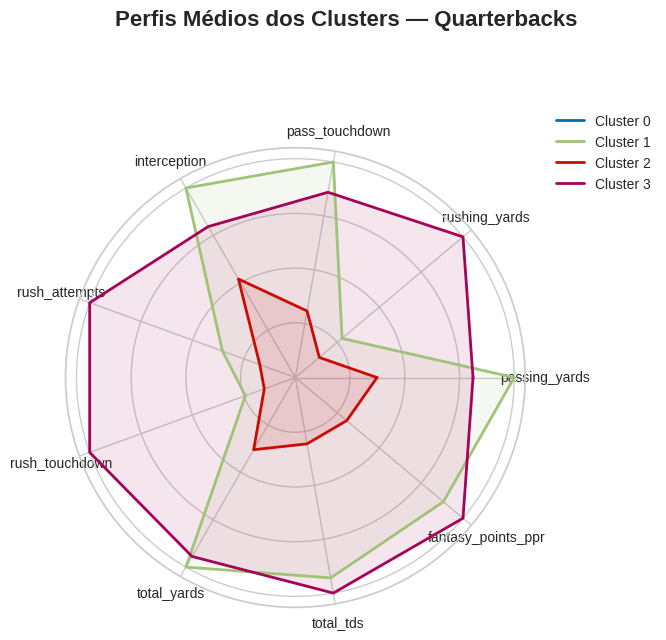

In [128]:
plot_radar_clusters_generic(qbs_mean, posicao='Quarterbacks')

In [129]:
def interpretar_clusters(df_or_qbs_mean, posicao='QB', features=None):
    """
    Interpreta clusters automaticamente.
    Aceita:
      - df_summary: index = cluster, colunas = features médias
      - qbs_mean: dataframe por jogador com coluna 'cluster' (então cria df_summary)
    Retorna string com interpretações.
    """
    # Detectar se foi passado o qbs_mean (com coluna 'cluster') ou um df_summary
    df_summary = None
    if isinstance(df_or_qbs_mean, pd.DataFrame) and 'cluster' in df_or_qbs_mean.columns:
        # Recebeu qbs_mean
        df_summary = make_df_summary_generic(df_or_qbs_mean, features)
    else:
        # Assume que recebeu df_summary (index = cluster)
        df_summary = df_or_qbs_mean.copy()
        # se 'cluster' for coluna, transformar para índice
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Features padrão se não passadas
    if features is None:
        features = ['passing_yards', 'rushing_yards', 'pass_touchdown',
                    'interception', 'fantasy_points_ppr']
    # Filtra somente as que existem
    features = [f for f in features if f in df_summary.columns]

    # Proteção contra df_summary vazio
    if df_summary.shape[0] == 0:
        return "df_summary vazio. Verifique a entrada."

    # Calcular percentis globais por feature para comparação
    percentis = {f: {
                    'p25': np.percentile(df_summary[f].dropna(), 25),
                    'p75': np.percentile(df_summary[f].dropna(), 75)
                   } for f in features}

    interpretacoes = []
    clusters_sorted = sorted(df_summary.index.tolist())

    for cluster_id in clusters_sorted:
        row = df_summary.loc[cluster_id]
        texto = f"### Cluster {cluster_id} — {posicao}\n"

        # 1️⃣ Força aérea vs terrestre (exemplo simples)
        if 'passing_yards' in features:
            if row['passing_yards'] > percentis['passing_yards']['p75']:
                texto += "- Perfil **passador dominante**: alto volume de jardas aéreas.\n"
            elif row['passing_yards'] < percentis['passing_yards']['p25']:
                texto += "- Menor produção aérea (pode ser QB móvel ou reserva).\n"

        if 'rushing_yards' in features:
            if row['rushing_yards'] > percentis['rushing_yards']['p75']:
                texto += "- Forte contribuição terrestre — **QB móvel / dual-threat**.\n"
            elif row['rushing_yards'] < percentis['rushing_yards']['p25']:
                texto += "- Pouca produção terrestre → **pocket QB** típico.\n"

        # 2️⃣ Eficiência (TD / INT)
        if 'pass_touchdown' in features and 'interception' in features:
            ratio = row['pass_touchdown'] / (row['interception'] + 1e-9)
            if ratio > 3:
                texto += "- **Excelente relação TD/INT** — baixa propensão a turnovers.\n"
            elif ratio < 1.5:
                texto += "- **Risco maior**: baixa relação TD/INT.\n"
            else:
                texto += "- Relação TD/INT **moderada**.\n"

        # 3️⃣ Fantasy as proxy
        if 'fantasy_points_ppr' in features:
            if row['fantasy_points_ppr'] > percentis['fantasy_points_ppr']['p75']:
                texto += "- Produção em fantasy alta → provável jogador de destaque.\n"
            elif row['fantasy_points_ppr'] < percentis['fantasy_points_ppr']['p25']:
                texto += "- Baixa produção média em fantasy → provável reserva ou especialista.\n"

        # 4️⃣ Estatísticas médias resumidas
        resumo_stats = ", ".join([f"{f}: {row[f]:.1f}" for f in features])
        texto += f"\n📊 Estatísticas médias (por cluster): {resumo_stats}\n\n---\n"
        interpretacoes.append(texto)

    return "\n".join(interpretacoes)

In [130]:


# 1) Criar df_summary automaticamente
df_summary = make_df_summary_generic(qbs_mean)

# 2) Interpretar clusters
texto = interpretar_clusters(qbs_mean, posicao='Quarterbacks')
print(texto)


### Cluster 0 — Quarterbacks
- Menor produção aérea (pode ser QB móvel ou reserva).
- Pouca produção terrestre → **pocket QB** típico.
- **Risco maior**: baixa relação TD/INT.
- Baixa produção média em fantasy → provável reserva ou especialista.

📊 Estatísticas médias (por cluster): passing_yards: 313.0, rushing_yards: 21.4, pass_touchdown: 1.3, interception: 1.7, fantasy_points_ppr: 18.5

---

### Cluster 1 — Quarterbacks
- Perfil **passador dominante**: alto volume de jardas aéreas.
- Relação TD/INT **moderada**.

📊 Estatísticas médias (por cluster): passing_yards: 2730.3, rushing_yards: 142.1, pass_touchdown: 17.3, interception: 8.5, fantasy_points_ppr: 210.4

---

### Cluster 2 — Quarterbacks
- **Risco maior**: baixa relação TD/INT.

📊 Estatísticas médias (por cluster): passing_yards: 1215.3, rushing_yards: 83.3, pass_touchdown: 6.2, interception: 5.3, fantasy_points_ppr: 85.1

---

### Cluster 3 — Quarterbacks
- Forte contribuição terrestre — **QB móvel / dual-threat**.
- Relação 

In [131]:
# Dicionário com nomes para cada cluster (você pode ajustar depois)
cluster_names = {
    0: "QBs Backup",
    1: "QBS Elite de Pocket",
    2: "QBs medianos",
    3: "QBs Elite de ameaça dupla (área e terrestre)"
}

# Loop mostrando exemplos de cada cluster
for c in sorted(qbs_mean['cluster'].unique()):
    cluster_name = cluster_names.get(c, "Cluster Sem Nome")
    print(f"\n🔹 Cluster {c} — {cluster_name}:")
    display(qbs_mean[qbs_mean['cluster'] == c][['player_name']].head(5))




🔹 Cluster 0 — QBs Backup:


player_name
0    Charlie Batch
1  Matt Hasselbeck
5       David Carr
8   Seneca Wallace
9   Byron Leftwich


🔹 Cluster 1 — QBS Elite de Pocket:


player_name
2   Peyton Manning
3        Tom Brady
4       Drew Brees
7    Carson Palmer
11     Eli Manning


🔹 Cluster 2 — QBs medianos:


player_name
6   Josh McCown
17   Kyle Orton
20  Matt Cassel
28  Brady Quinn
29   Kevin Kolb


🔹 Cluster 3 — QBs Elite de ameaça dupla (área e terrestre):


player_name
44         Cam Newton
49   Colin Kaepernick
117     Lamar Jackson
119        Josh Allen
123      Kyler Murray

####**WR**

In [132]:
# Features importantes para o ataque
features_cluster_wr = [
    'rushing_yards','rush_touchdown', 'fumble',
    'targets','receptions', 'receiving_yards', 'receiving_touchdown',
    'yards_after_catch','total_yards', 'total_tds',
    'fantasy_points_ppr','offense_snaps', 'total_touchdown',
    'yards_per_reception', 'catch_rate', 'touches', 'yards_per_touch'
]

In [133]:
# Agrupar por jogador e calcular a média de suas estatísticas ao longo dos anos
wrs_mean = (
    wrs.groupby(['player_id', 'player_name', 'position'])
    [features_cluster_wr]
    .mean()
    .reset_index()
)

# Preencher valores nulos com 0
X_wrs = wrs_mean[features_cluster_wr].fillna(0)

# Padronizar os dados
X_wrs_scaled = scaler.fit_transform(X_wrs)

kmeans = KMeans(n_clusters=4, random_state=42)
wrs_mean["cluster"] = kmeans.fit_predict(X_wrs_scaled)


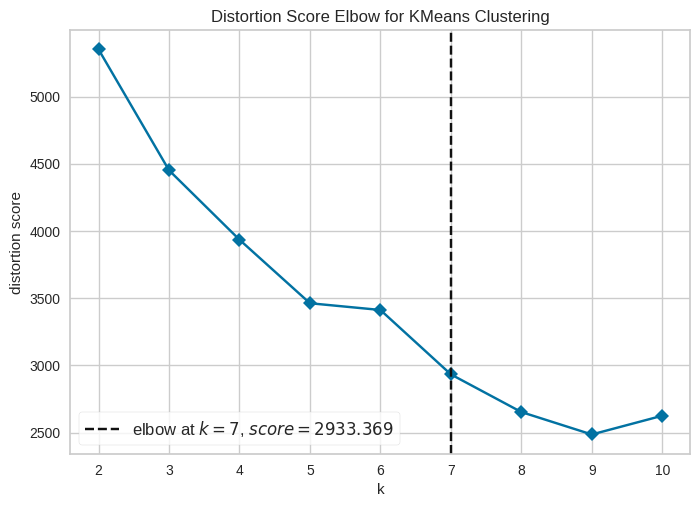

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [134]:
# Plotando o gráfico do Cotovelo pra descobrir o K
kelbow_visualizer(KMeans(), X_wrs_scaled, k=10, timings=False)

In [136]:
# Chamando a função para avaliar as métricas do Kmeans
resultados_kmeans_wrs = avaliar_modelos_clusterizacao(X_wrs_scaled, KMeans(random_state=42))
resultados_kmeans_wrs.style.background_gradient()

In [137]:
# Calcula médias das principais features por cluster
cluster_wrs = wrs_mean.groupby('cluster')[features_cluster_wr].mean().round(2)

# Mostra o resumo
cluster_wrs

rushing_yards  rush_touchdown  fumble  targets  receptions  \
cluster                                                               
0                 7.56            0.04    0.10    12.09        7.32   
1                14.69            0.11    0.64    90.58       58.99   
2                 3.49            0.02    0.12    16.48        9.39   
3                 9.86            0.06    0.37    46.79       28.93   

         receiving_yards  receiving_touchdown  yards_after_catch  total_yards  \
cluster                                                                         
0                  69.23                 0.33              29.13        77.09   
1                 766.51                 4.78             260.67       782.78   
2                 130.70                 0.64              40.36       134.32   
3                 367.17                 2.23             125.19       378.15   

         total_tds  fantasy_points_ppr  offense_snaps  total_touchdown  \
cluster                                                                  
0             0.70               16.34         120.60             0.37   
1             9.69              160.38         656.83             4.91   
2             1.31               25.31         171.45             0.66   
3             4.54               76.97         426.84             2.31   

         yards_per_reception  catch_rate  touches  yards_per_touch  
cluster                                                             
0                       7.47        0.58     8.66             7.42  
1                      13.06        0.65    61.53            12.80  
2                      14.79        0.58     9.94            14.49  
3                      12.43        0.61    30.66            12.18

In [138]:
wrs_mean['cluster'].value_counts()

cluster
2    164
3    164
0    156
1     89
Name: count, dtype: int64

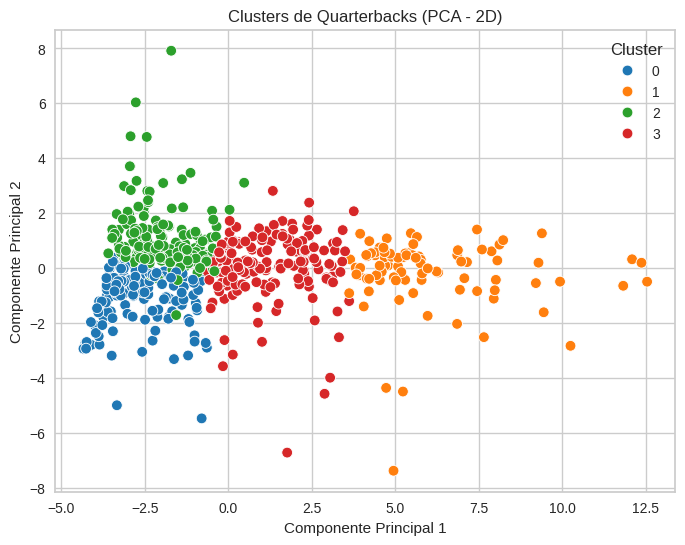

In [139]:
# Rodar o modelo final com k=4
kmeans_wrs = KMeans(n_clusters=4, random_state=42)
wrs_mean['cluster'] = kmeans_wrs.fit_predict(X_wrs_scaled)

# Criar o resumo médio por cluster
df_summary = wrs_mean.groupby('cluster')[[
    'receptions', 'receiving_yards', 'receiving_touchdown',
    'fumble', 'fantasy_points_ppr'
]].mean()


# Reduzindo para 2 dimensões com PCA
pca = PCA(n_components=2)
wrs_pca = pca.fit_transform(X_wrs_scaled)

# Adicionando os componentes principais ao dataframe
wrs_mean['pca1'] = wrs_pca[:, 0]
wrs_mean['pca2'] = wrs_pca[:, 1]

# Plotando os clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=wrs_mean, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters de Quarterbacks (PCA - 2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

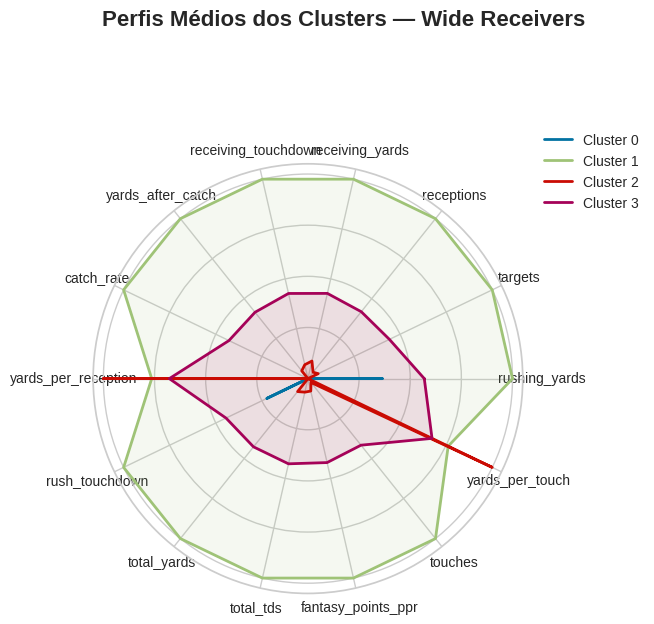

In [140]:
# Para WRs
plot_radar_clusters_generic(wrs_mean, posicao='Wide Receivers')


In [141]:

# 1) Criar df_summary automaticamente
df_summary = make_df_summary_generic(wrs_mean)

def interpretar_clusters_wrs(df_or_wrs_mean, posicao='WR', features=None):
    """
    Interpreta clusters automaticamente para Wide Receivers (WRs).
    Aceita:
      - df_summary: index = cluster, colunas = features médias
      - wrs_mean: dataframe por jogador com coluna 'cluster' (então cria df_summary)
    Retorna string com interpretações detalhadas.
    """
    # Detectar se foi passado o wrs_mean (com coluna 'cluster') ou um df_summary
    df_summary = None
    if isinstance(df_or_wrs_mean, pd.DataFrame) and 'cluster' in df_or_wrs_mean.columns:
        # Recebeu wrs_mean
        df_summary = make_df_summary_generic(df_or_wrs_mean, features)
    else:
        # Assume que recebeu df_summary (index = cluster)
        df_summary = df_or_wrs_mean.copy()
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Features padrão se não passadas
    if features is None:
        features = [
            'targets', 'receptions', 'receiving_yards', 'receiving_touchdown',
            'yards_after_catch', 'catch_rate', 'yards_per_reception',
            'fantasy_points_ppr'
        ]
    # Filtra somente as que existem
    features = [f for f in features if f in df_summary.columns]

    if df_summary.shape[0] == 0:
        return "df_summary vazio. Verifique a entrada."

    # Calcular percentis para comparação relativa
    percentis = {
        f: {
            'p25': np.percentile(df_summary[f].dropna(), 25),
            'p75': np.percentile(df_summary[f].dropna(), 75)
        }
        for f in features
    }

    interpretacoes = []
    clusters_sorted = sorted(df_summary.index.tolist())

    for cluster_id in clusters_sorted:
        row = df_summary.loc[cluster_id]
        texto = f"### Cluster {cluster_id} — {posicao}\n"

        # 1️⃣ Volume de jogo (uso e oportunidades)
        if 'targets' in features and 'receptions' in features:
            if row['targets'] > percentis['targets']['p75']:
                texto += "- **Alto volume de alvos**: WR principal ou muito acionado no esquema ofensivo.\n"
            elif row['targets'] < percentis['targets']['p25']:
                texto += "- **Baixo volume de alvos**: possivelmente WR reserva ou situacional.\n"

        # 2️⃣ Eficiência aérea
        if 'catch_rate' in features:
            if row['catch_rate'] > percentis['catch_rate']['p75']:
                texto += "- **Excelente taxa de recepção**: mãos seguras e bom entrosamento com o QB.\n"
            elif row['catch_rate'] < percentis['catch_rate']['p25']:
                texto += "- **Baixa taxa de recepção**: pode indicar passes difíceis ou drops frequentes.\n"

        # 3️⃣ Profundidade das rotas
        if 'yards_per_reception' in features:
            if row['yards_per_reception'] > percentis['yards_per_reception']['p75']:
                texto += "- **Ameaça em profundidade**: rotas longas e ganho explosivo por recepção.\n"
            elif row['yards_per_reception'] < percentis['yards_per_reception']['p25']:
                texto += "- **WR de slot ou curta distância**, rotas rápidas e seguras.\n"

        # 4️⃣ Produção pós-recepção
        if 'yards_after_catch' in features:
            if row['yards_after_catch'] > percentis['yards_after_catch']['p75']:
                texto += "- **Excelente após a recepção (YAC)**: cria jardas extras com agilidade e força.\n"
            elif row['yards_after_catch'] < percentis['yards_after_catch']['p25']:
                texto += "- **Baixo YAC**: WR mais estático, focado em rotas e posicionamento.\n"

        # 5️⃣ Impacto ofensivo
        if 'receiving_touchdown' in features:
            if row['receiving_touchdown'] > percentis['receiving_touchdown']['p75']:
                texto += "- **Alta produção de TDs**: alvo frequente na red zone.\n"
            elif row['receiving_touchdown'] < percentis['receiving_touchdown']['p25']:
                texto += "- Poucos TDs: menos envolvido em jogadas decisivas.\n"

        # 6️⃣ Desempenho geral (fantasy)
        if 'fantasy_points_ppr' in features:
            if row['fantasy_points_ppr'] > percentis['fantasy_points_ppr']['p75']:
                texto += "- **Alto desempenho em fantasy**: jogador de elite e consistente.\n"
            elif row['fantasy_points_ppr'] < percentis['fantasy_points_ppr']['p25']:
                texto += "- **Baixa pontuação média em fantasy**: papel secundário no ataque.\n"

        # 7️⃣ Resumo estatístico
        resumo_stats = ", ".join([f"{f}: {row[f]:.1f}" for f in features])
        texto += f"\n📊 Estatísticas médias (por cluster): {resumo_stats}\n\n---\n"
        interpretacoes.append(texto)

    return "\n".join(interpretacoes)


# 🔹 Exemplo de uso:
interpretacao_wrs = interpretar_clusters_wrs(wrs_mean, posicao='Wide Receivers')
print(interpretacao_wrs)

### Cluster 0 — Wide Receivers
- **Baixo volume de alvos**: possivelmente WR reserva ou situacional.
- **WR de slot ou curta distância**, rotas rápidas e seguras.
- **Baixo YAC**: WR mais estático, focado em rotas e posicionamento.
- Poucos TDs: menos envolvido em jogadas decisivas.
- **Baixa pontuação média em fantasy**: papel secundário no ataque.

📊 Estatísticas médias (por cluster): targets: 12.1, receptions: 7.3, receiving_yards: 69.2, receiving_touchdown: 0.3, yards_after_catch: 29.1, catch_rate: 0.6, yards_per_reception: 7.5, fantasy_points_ppr: 16.3

---

### Cluster 1 — Wide Receivers
- **Alto volume de alvos**: WR principal ou muito acionado no esquema ofensivo.
- **Excelente taxa de recepção**: mãos seguras e bom entrosamento com o QB.
- **Excelente após a recepção (YAC)**: cria jardas extras com agilidade e força.
- **Alta produção de TDs**: alvo frequente na red zone.
- **Alto desempenho em fantasy**: jogador de elite e consistente.

📊 Estatísticas médias (por cluster): ta

In [142]:
# Dicionário com nomes para cada cluster (ajuste conforme sua interpretação)
cluster_names_wrs = {
    0: "WRs de Baixo Volume / Reservas",
    1: "WRs Elite / Alvos Principais",
    2: "WRs Verticais / Ameaça em Profundidade",
    3: "WRs Complementares / Consistentes"
}

# Loop mostrando exemplos de cada cluster
for c in sorted(wrs_mean['cluster'].unique()):
    cluster_name = cluster_names_wrs.get(c, "Cluster Sem Nome")
    print(f"\n🔹 Cluster {c} — {cluster_name}:")
    display(wrs_mean[wrs_mean['cluster'] == c][['player_name']].head(5))



🔹 Cluster 0 — WRs de Baixo Volume / Reservas:


player_name
0     Donald Driver
8      Deion Branch
18  Braylon Edwards
24       Brad Smith
29      Ben Obomanu


🔹 Cluster 1 — WRs Elite / Alvos Principais:


player_name
4        Steve Smith
6       Reggie Wayne
11     Andre Johnson
12     Anquan Boldin
16  Larry Fitzgerald


🔹 Cluster 2 — WRs Verticais / Ameaça em Profundidade:


player_name
1         Randy Moss
3    Plaxico Burress
7      Jabar Gaffney
21   Santonio Holmes
28  Devin Aromashodu


🔹 Cluster 3 — WRs Complementares / Consistentes:


player_name
2   Brandon Stokley
5      Santana Moss
9      Kevin Walter
10    Nate Burleson
13    Brandon Lloyd

####**TE**

In [143]:
# Features importantes para o ataque
features_cluster_te = [
    'rushing_yards','rush_touchdown', 'fumble',
    'targets','receptions', 'receiving_yards', 'receiving_touchdown',
    'yards_after_catch','total_yards', 'total_tds',
    'fantasy_points_ppr','offense_snaps', 'total_touchdown',
    'yards_per_reception', 'catch_rate', 'touches', 'yards_per_touch'
]

In [144]:
# Agrupar por jogador e calcular a média de suas estatísticas ao longo dos anos
tes_mean = (
    tes.groupby(['player_id', 'player_name', 'position'])
    [features_cluster_te]
    .mean()
    .reset_index()
)

# Preencher valores nulos com 0
X_tes = tes_mean[features_cluster_te].fillna(0)

# Padronizar os dados
X_tes_scaled = scaler.fit_transform(X_tes)

kmeans = KMeans(n_clusters=4, random_state=42)
tes_mean["cluster"] = kmeans.fit_predict(X_tes_scaled)

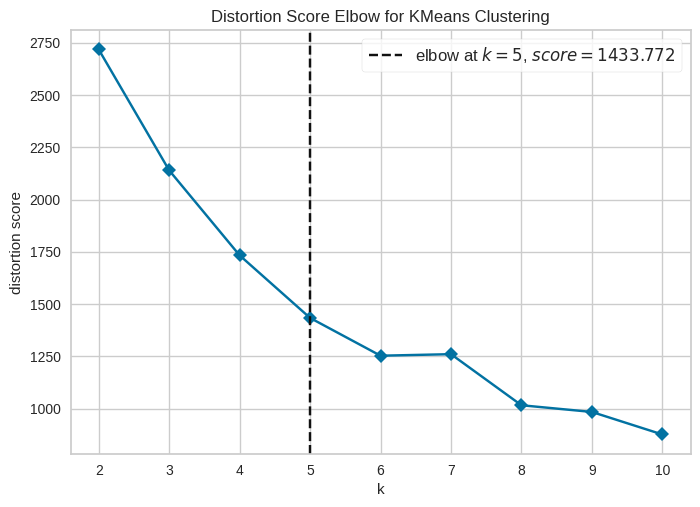

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [145]:
# Plotando o gráfico do Cotovelo pra descobrir o K
kelbow_visualizer(KMeans(), X_tes_scaled, k=10, timings=False)

In [147]:
# Chamando a função para avaliar as métricas do Kmeans
resultados_kmeans_tes = avaliar_modelos_clusterizacao(X_tes_scaled, KMeans(random_state=42))
resultados_kmeans_tes.style.background_gradient()

In [148]:
# Calcula médias das principais features por cluster
cluster_tes = tes_mean.groupby('cluster')[features_cluster_te].mean().round(2)

# Mostra o resumo
cluster_tes

rushing_yards  rush_touchdown  fumble  targets  receptions  \
cluster                                                               
0                 0.32            0.01    0.11    12.85        8.96   
1                 0.53            0.01    0.31    36.88       25.08   
2                 7.30            0.15    0.51    66.36       46.75   
3                 0.00            0.00    0.05     3.39        1.73   

         receiving_yards  receiving_touchdown  yards_after_catch  total_yards  \
cluster                                                                         
0                  90.57                 0.58              43.79        90.89   
1                 271.19                 2.14             116.42       271.93   
2                 511.66                 3.41             216.72       519.44   
3                  15.94                 0.20               7.92        15.94   

         total_tds  fantasy_points_ppr  offense_snaps  total_touchdown  \
cluster                                                                  
0             1.18               20.95         172.24             0.59   
1             4.30               62.94         386.89             2.16   
2             6.97              115.83         579.99             3.56   
3             0.40                4.21          45.19             0.20   

         yards_per_reception  catch_rate  touches  yards_per_touch  
cluster                                                             
0                      10.29        0.72     9.03            10.24  
1                      10.66        0.68    25.23            10.64  
2                      10.83        0.70    47.90            10.81  
3                       4.11        0.31     1.76             4.11

In [149]:
tes_mean['cluster'].value_counts()

cluster
0    144
1     72
2     38
3     31
Name: count, dtype: int64

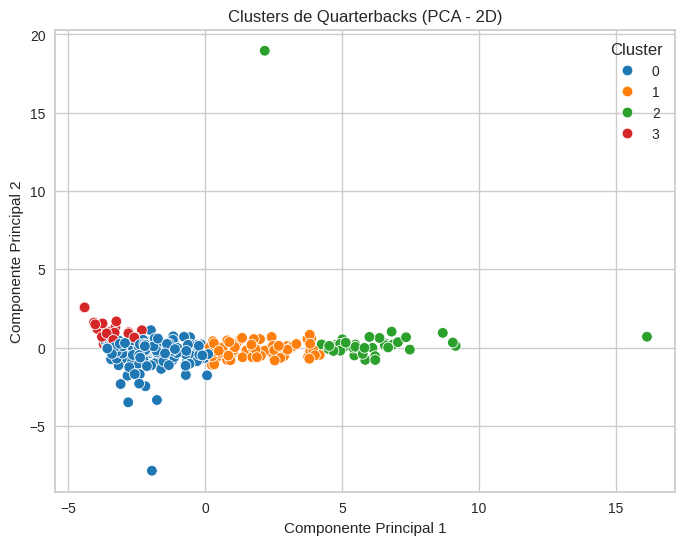

In [150]:
# Rodar o modelo final com k=4
kmeans_tes = KMeans(n_clusters=4, random_state=42)
tes_mean['cluster'] = kmeans_tes.fit_predict(X_tes_scaled)

# Criar o resumo médio por cluster
df_summary = tes_mean.groupby('cluster')[[
    'receptions', 'receiving_yards', 'receiving_touchdown',
    'fumble', 'fantasy_points_ppr'
]].mean()


# Reduzindo para 2 dimensões com PCA
pca = PCA(n_components=2)
tes_pca = pca.fit_transform(X_tes_scaled)

# Adicionando os componentes principais ao dataframe
tes_mean['pca1'] = tes_pca[:, 0]
tes_mean['pca2'] = tes_pca[:, 1]

# Plotando os clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=tes_mean, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters de Quarterbacks (PCA - 2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

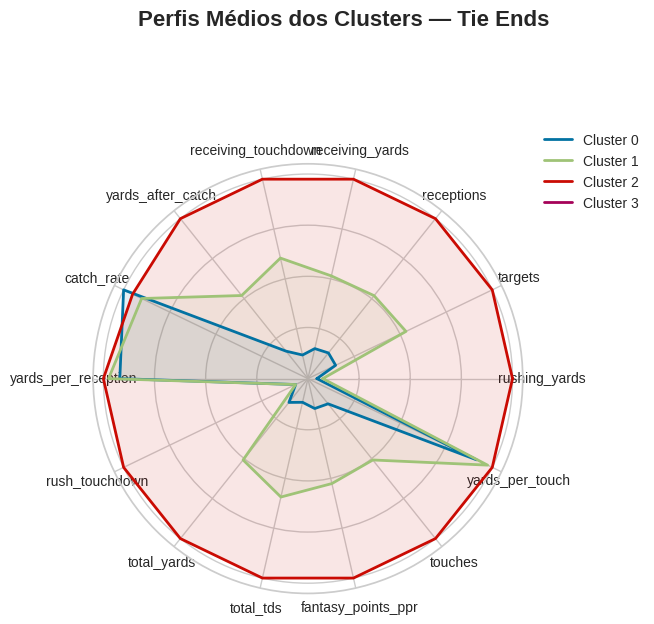

In [151]:
# Para TE
plot_radar_clusters_generic(tes_mean, posicao='Tie Ends')

In [152]:
# 1) Criar df_summary automaticamente
df_summary = make_df_summary_generic(tes_mean)

def interpretar_clusters_tes(df_or_tes_mean, posicao='TE', features=None):
    """
    Interpreta clusters automaticamente para Tight Ends (TEs).
    Aceita:
      - df_summary: index = cluster, colunas = features médias
      - tes_mean: dataframe por jogador com coluna 'cluster' (então cria df_summary)
    Retorna string com interpretações detalhadas.
    """
    # Detectar se foi passado o tes_mean (com coluna 'cluster') ou um df_summary
    df_summary = None
    if isinstance(df_or_tes_mean, pd.DataFrame) and 'cluster' in df_or_tes_mean.columns:
        # Recebeu tes_mean
        df_summary = make_df_summary_generic(df_or_tes_mean, features)
    else:
        # Assume que recebeu df_summary (index = cluster)
        df_summary = df_or_tes_mean.copy()
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Features padrão se não passadas
    if features is None:
        features = [
            'targets', 'receptions', 'receiving_yards', 'receiving_touchdown',
            'yards_after_catch', 'catch_rate', 'yards_per_reception',
            'fantasy_points_ppr'
        ]
    # Filtra somente as que existem
    features = [f for f in features if f in df_summary.columns]

    if df_summary.shape[0] == 0:
        return "df_summary vazio. Verifique a entrada."

    # Calcular percentis para comparação relativa
    percentis = {
        f: {
            'p25': np.percentile(df_summary[f].dropna(), 25),
            'p75': np.percentile(df_summary[f].dropna(), 75)
        }
        for f in features
    }

    interpretacoes = []
    clusters_sorted = sorted(df_summary.index.tolist())

    for cluster_id in clusters_sorted:
        row = df_summary.loc[cluster_id]
        texto = f"### Cluster {cluster_id} — {posicao}\n"

        # 1️⃣ Volume de jogo (uso e oportunidades)
        if 'targets' in features and 'receptions' in features:
            if row['targets'] > percentis['targets']['p75']:
                texto += "- **Alto volume de alvos**: TE principal e peça-chave no jogo aéreo.\n"
            elif row['targets'] < percentis['targets']['p25']:
                texto += "- **Baixo volume de alvos**: possivelmente TE reserva ou usado mais em bloqueios.\n"

        # 2️⃣ Eficiência aérea
        if 'catch_rate' in features:
            if row['catch_rate'] > percentis['catch_rate']['p75']:
                texto += "- **Alta eficiência de recepção**: mãos seguras e rotas bem executadas.\n"
            elif row['catch_rate'] < percentis['catch_rate']['p25']:
                texto += "- **Baixa eficiência de recepção**: possível baixa conexão com o QB ou passes difíceis.\n"

        # 3️⃣ Profundidade das rotas
        if 'yards_per_reception' in features:
            if row['yards_per_reception'] > percentis['yards_per_reception']['p75']:
                texto += "- **TE vertical**: atua em rotas médias/longas, com bom ganho por recepção.\n"
            elif row['yards_per_reception'] < percentis['yards_per_reception']['p25']:
                texto += "- **TE de segurança**: recebe passes curtos, útil em situações de 3ª descida.\n"

        # 4️⃣ Produção pós-recepção
        if 'yards_after_catch' in features:
            if row['yards_after_catch'] > percentis['yards_after_catch']['p75']:
                texto += "- **Bom após a recepção (YAC)**: quebra tackles e ganha jardas extras.\n"
            elif row['yards_after_catch'] < percentis['yards_after_catch']['p25']:
                texto += "- **Baixo YAC**: jogador mais estático, voltado a rotas curtas.\n"

        # 5️⃣ Impacto ofensivo
        if 'receiving_touchdown' in features:
            if row['receiving_touchdown'] > percentis['receiving_touchdown']['p75']:
                texto += "- **Alta produção de TDs**: alvo confiável na red zone.\n"
            elif row['receiving_touchdown'] < percentis['receiving_touchdown']['p25']:
                texto += "- Poucos TDs: papel mais tático do que ofensivo.\n"

        # 6️⃣ Desempenho geral (fantasy)
        if 'fantasy_points_ppr' in features:
            if row['fantasy_points_ppr'] > percentis['fantasy_points_ppr']['p75']:
                texto += "- **Alto desempenho em fantasy**: TE produtivo e consistente.\n"
            elif row['fantasy_points_ppr'] < percentis['fantasy_points_ppr']['p25']:
                texto += "- **Baixa pontuação em fantasy**: usado mais em bloqueios ou pouco acionado.\n"

        # 7️⃣ Resumo estatístico
        resumo_stats = ", ".join([f"{f}: {row[f]:.1f}" for f in features])
        texto += f"\n📊 Estatísticas médias (por cluster): {resumo_stats}\n\n---\n"
        interpretacoes.append(texto)

    return "\n".join(interpretacoes)


# 🔹 Exemplo de uso:
interpretacao_tes = interpretar_clusters_tes(tes_mean, posicao='Tight Ends')
print(interpretacao_tes)


### Cluster 0 — Tight Ends
- **Alta eficiência de recepção**: mãos seguras e rotas bem executadas.

📊 Estatísticas médias (por cluster): targets: 12.8, receptions: 9.0, receiving_yards: 90.6, receiving_touchdown: 0.6, yards_after_catch: 43.8, catch_rate: 0.7, yards_per_reception: 10.3, fantasy_points_ppr: 20.9

---

### Cluster 1 — Tight Ends

📊 Estatísticas médias (por cluster): targets: 36.9, receptions: 25.1, receiving_yards: 271.2, receiving_touchdown: 2.1, yards_after_catch: 116.4, catch_rate: 0.7, yards_per_reception: 10.7, fantasy_points_ppr: 62.9

---

### Cluster 2 — Tight Ends
- **Alto volume de alvos**: TE principal e peça-chave no jogo aéreo.
- **TE vertical**: atua em rotas médias/longas, com bom ganho por recepção.
- **Bom após a recepção (YAC)**: quebra tackles e ganha jardas extras.
- **Alta produção de TDs**: alvo confiável na red zone.
- **Alto desempenho em fantasy**: TE produtivo e consistente.

📊 Estatísticas médias (por cluster): targets: 66.4, receptions: 46.8, r

In [153]:
# Dicionário com nomes para cada cluster (ajuste conforme sua interpretação)
cluster_names_tes = {
    0: "TEs de Alta Eficiência (Hands Team)",
    1: "TEs Produtivos / Boas Armas Aéreas",
    2: "TEs Estrela / Alvo Principal do Ataque",
    3: "TEs de Bloqueio / Baixo Volume"
}

# Loop mostrando exemplos de cada cluster
for c in sorted(tes_mean['cluster'].unique()):
    cluster_name = cluster_names_tes.get(c, "Cluster Sem Nome")
    print(f"\n🔹 Cluster {c} — {cluster_name}:")
    display(tes_mean[tes_mean['cluster'] == c][['player_name']].head(5))



🔹 Cluster 0 — TEs de Alta Eficiência (Hands Team):


player_name
1         Todd Heap
2   Randy McMichael
12   Marcedes Lewis
16        Jeff King
21       Kevin Boss


🔹 Cluster 1 — TEs Produtivos / Boas Armas Aéreas:


player_name
7    Kellen Winslow
8   Benjamin Watson
10    Joel Dreessen
11     Vernon Davis
13   Anthony Fasano


🔹 Cluster 2 — TEs Estrela / Alvo Principal do Ataque:


player_name
0    Tony Gonzalez
4     Jason Witten
5     Dallas Clark
9     Heath Miller
17  Delanie Walker


🔹 Cluster 3 — TEs de Bloqueio / Baixo Volume:


player_name
3   Visanthe Shiancoe
6        Chris Cooley
32       Kellen Davis
55      D.J. Williams
81          Nick Kasa

####**RB**

In [154]:
# Features importantes para o ataque
features_cluster_rb = [
    'rush_attempts', 'rushing_yards','rush_touchdown', 'fumble',
    'targets','receptions', 'receiving_yards', 'receiving_touchdown',
    'yards_after_catch','total_yards', 'total_tds',
    'fantasy_points_ppr','offense_snaps', 'total_touchdown',
    'yards_per_reception', 'catch_rate', 'touches', 'yards_per_touch'
]

In [155]:
# Agrupar por jogador e calcular a média de suas estatísticas ao longo dos anos
rbs_mean = (
    rbs.groupby(['player_id', 'player_name', 'position'])
    [features_cluster_rb]
    .mean()
    .reset_index()
)

# Preencher valores nulos com 0
X_rbs = rbs_mean[features_cluster_rb].fillna(0)

# Padronizar os dados
X_rbs_scaled = scaler.fit_transform(X_rbs)

kmeans = KMeans(n_clusters=4, random_state=42)
rbs_mean["cluster"] = kmeans.fit_predict(X_rbs_scaled)

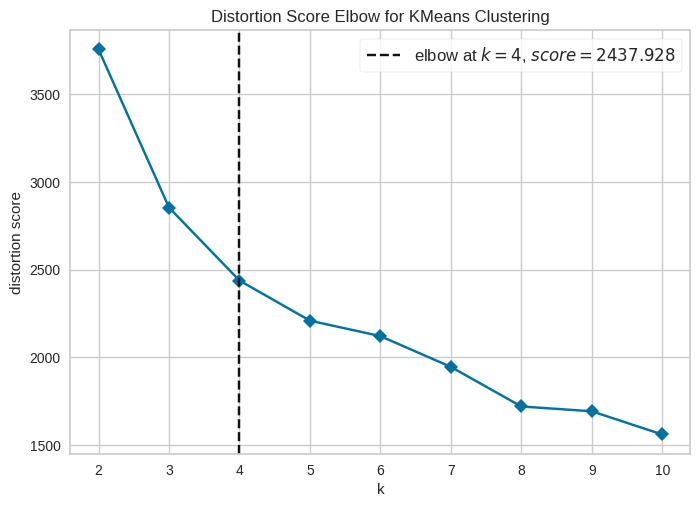

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [156]:
# Plotando o gráfico do Cotovelo pra descobrir o K
kelbow_visualizer(KMeans(), X_rbs_scaled, k=10, timings=False)

In [157]:
# Calcula médias das principais features por cluster
cluster_rbs = rbs_mean.groupby('cluster')[features_cluster_rb].mean().round(2)

# Mostra o resumo
cluster_rbs


rush_attempts  rushing_yards  rush_touchdown  fumble  targets  \
cluster                                                                  
0                36.93         153.95            0.94    0.46     9.81   
1               167.02         735.02            5.47    1.79    46.97   
2                93.94         389.38            2.72    1.05    24.89   
3                18.24          64.22            0.42    0.15     4.31   

         receptions  receiving_yards  receiving_touchdown  yards_after_catch  \
cluster                                                                        
0              7.58            59.14                 0.21              59.01   
1             36.98           282.64                 1.31             301.75   
2             18.83           146.71                 0.75             144.27   
3              2.86            16.07                 0.07              17.13   

         total_yards  total_tds  fantasy_points_ppr  offense_snaps  \
cluster                                                              
0             213.09       1.37               34.87         117.11   
1            1018.10       8.12              175.68         491.23   
2             536.34       4.24               90.92         277.68   
3              80.30       0.56               13.40          54.23   

         total_touchdown  yards_per_reception  catch_rate  touches  \
cluster                                                              
0                   1.16                 7.77        0.75    44.50   
1                   6.81                 7.52        0.77   204.01   
2                   3.48                 7.11        0.71   112.77   
3                   0.49                 3.04        0.47    21.10   

         yards_per_touch  
cluster                   
0                   5.14  
1                   5.06  
2                   4.72  
3                   3.48

In [158]:
rbs_mean['cluster'].value_counts()

cluster
0    145
2    112
3     94
1     46
Name: count, dtype: int64

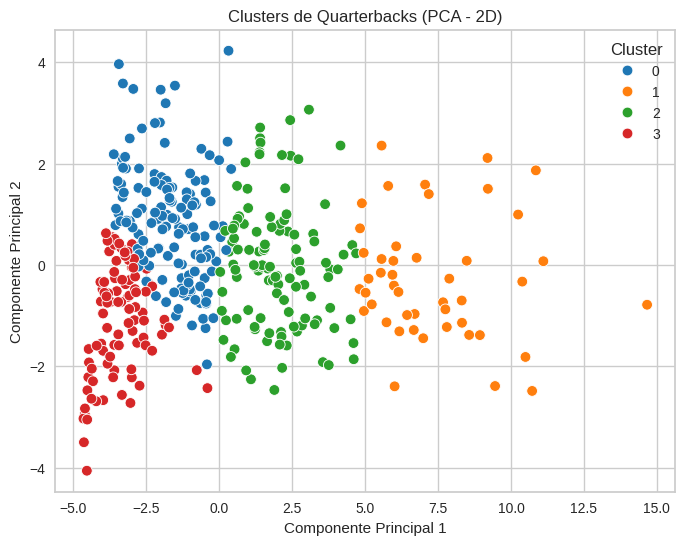

In [159]:
# Rodar o modelo final com k=4
kmeans_rbs = KMeans(n_clusters=4, random_state=42)
rbs_mean['cluster'] = kmeans_rbs.fit_predict(X_rbs_scaled)

# Criar o resumo médio por cluster
df_summary = rbs_mean.groupby('cluster')[[
    'rush_attempts', 'rushing_yards', 'rush_touchdown',
    'fumble', 'fantasy_points_ppr'
]].mean()


# Reduzindo para 2 dimensões com PCA
pca = PCA(n_components=2)
rbs_pca = pca.fit_transform(X_rbs_scaled)

# Adicionando os componentes principais ao dataframe
rbs_mean['pca1'] = rbs_pca[:, 0]
rbs_mean['pca2'] = rbs_pca[:, 1]

# Plotando os clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=rbs_mean, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters de Quarterbacks (PCA - 2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

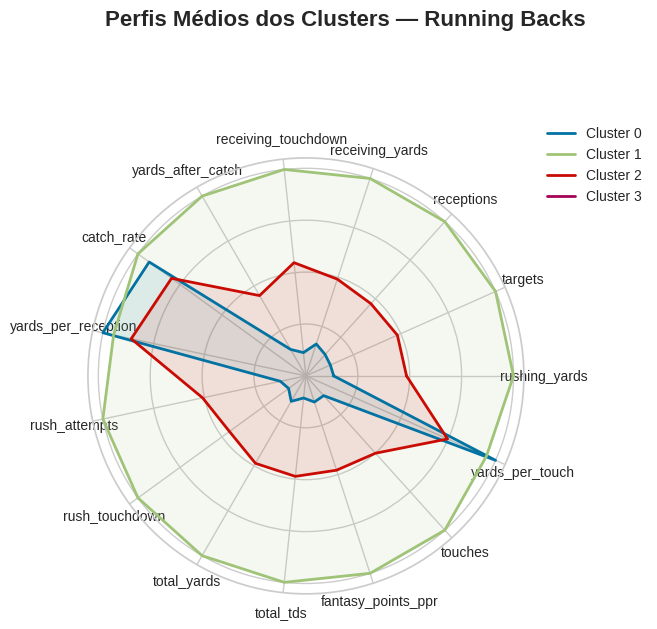

In [160]:
# Para RB
plot_radar_clusters_generic(rbs_mean, posicao='Running Backs')

In [161]:
# 1) Criar df_summary automaticamente
df_summary = make_df_summary_generic(rbs_mean)

def interpretar_clusters_rbs(df_or_rbs_mean, posicao='RB', features=None):
    """
    Interpreta clusters automaticamente para Running Backs (RBs).
    Aceita:
      - df_summary: index = cluster, colunas = features médias
      - rbs_mean: dataframe por jogador com coluna 'cluster' (então cria df_summary)
    Retorna string com interpretações detalhadas.
    """
    # Detectar se foi passado o rbs_mean (com coluna 'cluster') ou um df_summary
    df_summary = None
    if isinstance(df_or_rbs_mean, pd.DataFrame) and 'cluster' in df_or_rbs_mean.columns:
        # Recebeu rbs_mean
        df_summary = make_df_summary_generic(df_or_rbs_mean, features)
    else:
        # Assume que recebeu df_summary (index = cluster)
        df_summary = df_or_rbs_mean.copy()
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Features padrão se não passadas
    if features is None:
        features = [
            'rushing_attempts', 'rushing_yards', 'rushing_touchdown',
            'targets', 'receptions', 'receiving_yards', 'receiving_touchdown',
            'yards_after_contact', 'yards_per_carry', 'fantasy_points_ppr'
        ]

    # Filtra somente as que existem
    features = [f for f in features if f in df_summary.columns]

    if df_summary.shape[0] == 0:
        return "df_summary vazio. Verifique a entrada."

    # Calcular percentis para comparação relativa
    percentis = {
        f: {
            'p25': np.percentile(df_summary[f].dropna(), 25),
            'p75': np.percentile(df_summary[f].dropna(), 75)
        }
        for f in features
    }

    interpretacoes = []
    clusters_sorted = sorted(df_summary.index.tolist())

    for cluster_id in clusters_sorted:
        row = df_summary.loc[cluster_id]
        texto = f"### Cluster {cluster_id} — {posicao}\n"

        # 1️⃣ Volume de carregadas
        if 'rushing_attempts' in features:
            if row['rushing_attempts'] > percentis['rushing_attempts']['p75']:
                texto += "- **Workhorse / Alto volume de corridas**: RB principal do time, recebe muitas tentativas.\n"
            elif row['rushing_attempts'] < percentis['rushing_attempts']['p25']:
                texto += "- **Baixo volume de corridas**: usado de forma situacional ou reserva.\n"

        # 2️⃣ Eficiência terrestre
        if 'yards_per_carry' in features:
            if row['yards_per_carry'] > percentis['yards_per_carry']['p75']:
                texto += "- **Alta eficiência por carregada**: ótimo aproveitamento em cada corrida.\n"
            elif row['yards_per_carry'] < percentis['yards_per_carry']['p25']:
                texto += "- **Baixa eficiência por carregada**: dificuldades em gerar jardas consistentes.\n"

        # 3️⃣ Produção após contato
        if 'yards_after_contact' in features:
            if row['yards_after_contact'] > percentis['yards_after_contact']['p75']:
                texto += "- **Excelente após o contato**: quebra tackles e gera jardas extras.\n"
            elif row['yards_after_contact'] < percentis['yards_after_contact']['p25']:
                texto += "- **Baixo ganho após o contato**: tende a ser derrubado rapidamente.\n"

        # 4️⃣ Participação no jogo aéreo
        if 'targets' in features and 'receptions' in features:
            if row['targets'] > percentis['targets']['p75']:
                texto += "- **RB receptor / Versátil**: participa ativamente do jogo aéreo.\n"
            elif row['targets'] < percentis['targets']['p25']:
                texto += "- **RB mais terrestre**: pouco envolvido em passes.\n"

        # 5️⃣ Produção aérea
        if 'receiving_yards' in features:
            if row['receiving_yards'] > percentis['receiving_yards']['p75']:
                texto += "- **Bom ganho aéreo**: contribui bem recebendo passes curtos e screens.\n"
            elif row['receiving_yards'] < percentis['receiving_yards']['p25']:
                texto += "- **Baixo ganho aéreo**: pouca utilização em rotas de passe.\n"

        # 6️⃣ Produção de touchdowns
        if 'rushing_touchdown' in features:
            if row['rushing_touchdown'] > percentis['rushing_touchdown']['p75']:
                texto += "- **Alta produção de TDs terrestres**: destaque na red zone.\n"
            elif row['rushing_touchdown'] < percentis['rushing_touchdown']['p25']:
                texto += "- Poucos TDs terrestres: não é o principal finalizador da equipe.\n"

        # 7️⃣ Desempenho geral (fantasy)
        if 'fantasy_points_ppr' in features:
            if row['fantasy_points_ppr'] > percentis['fantasy_points_ppr']['p75']:
                texto += "- **RB de elite em fantasy**: muito produtivo e versátil.\n"
            elif row['fantasy_points_ppr'] < percentis['fantasy_points_ppr']['p25']:
                texto += "- **Baixa pontuação em fantasy**: uso limitado ou papel situacional.\n"

        # 8️⃣ Resumo estatístico
        resumo_stats = ", ".join([f"{f}: {row[f]:.1f}" for f in features])
        texto += f"\n📊 Estatísticas médias (por cluster): {resumo_stats}\n\n---\n"
        interpretacoes.append(texto)

    return "\n".join(interpretacoes)


# 🔹 Exemplo de uso:
interpretacao_rbs = interpretar_clusters_rbs(rbs_mean, posicao='Running Backs')
print(interpretacao_rbs)


### Cluster 0 — Running Backs

📊 Estatísticas médias (por cluster): rushing_yards: 153.9, targets: 9.8, receptions: 7.6, receiving_yards: 59.1, receiving_touchdown: 0.2, fantasy_points_ppr: 34.9

---

### Cluster 1 — Running Backs
- **RB receptor / Versátil**: participa ativamente do jogo aéreo.
- **Bom ganho aéreo**: contribui bem recebendo passes curtos e screens.
- **RB de elite em fantasy**: muito produtivo e versátil.

📊 Estatísticas médias (por cluster): rushing_yards: 735.0, targets: 47.0, receptions: 37.0, receiving_yards: 282.6, receiving_touchdown: 1.3, fantasy_points_ppr: 175.7

---

### Cluster 2 — Running Backs

📊 Estatísticas médias (por cluster): rushing_yards: 389.4, targets: 24.9, receptions: 18.8, receiving_yards: 146.7, receiving_touchdown: 0.8, fantasy_points_ppr: 90.9

---

### Cluster 3 — Running Backs
- **RB mais terrestre**: pouco envolvido em passes.
- **Baixo ganho aéreo**: pouca utilização em rotas de passe.
- **Baixa pontuação em fantasy**: uso limitado ou p

In [162]:
# Dicionário com nomes para cada cluster
cluster_names_rbs = {
    0: "RBs de Apoio / Baixo Volume",
    1: "RBs Elite e Versáteis (Dual Threat)",
    2: "RBs Consistentes / Produção Balanceada",
    3: "RBs Situacionais / Uso Limitado"
}

# Loop mostrando exemplos de cada cluster
for c in sorted(rbs_mean['cluster'].unique()):
    cluster_name = cluster_names_rbs.get(c, "Cluster Sem Nome")
    print(f"\n🔹 Cluster {c} — {cluster_name}:")
    display(rbs_mean[rbs_mean['cluster'] == c][['player_name']].head(5))



🔹 Cluster 0 — RBs de Apoio / Baixo Volume:


player_name
1     Mewelde Moore
4      Ronnie Brown
5     Cedric Benson
15    Brian Leonard
16  Brandon Jackson


🔹 Cluster 1 — RBs Elite e Versáteis (Dual Threat):


player_name
6       Frank Gore
25      Matt Forte
26        Ray Rice
28  Jamaal Charles
41    LeSean McCoy


🔹 Cluster 2 — RBs Consistentes / Produção Balanceada:


player_name
0  Willis McGahee
2  Steven Jackson
3  Michael Turner
8  Darren Sproles
9     Reggie Bush


🔹 Cluster 3 — RBs Situacionais / Uso Limitado:


player_name
7    Brandon Jacobs
12  Leon Washington
29   Tashard Choice
35   Cedric Peerman
36    Bernard Scott

###**Defesa**

In [163]:
def make_df_summary_defense(df_mean, features=None):
    """
    Cria um resumo médio (df_summary) agrupado por cluster
    para posições defensivas (DL, LB, CB, Safeties).

    - DL: Defensive Line (DE, DT, NT, T)
    - LB: Linebackers (ILB, OLB, MLB)
    - CB: Cornerbacks
    - Safeties: SS, FS, S
    """

    if 'cluster' not in df_mean.columns:
        raise ValueError("O dataframe precisa ter a coluna 'cluster'.")

    # Detecta automaticamente features defensivas (nomes reais do seu dataset)
    if features is None:
        possible_features = [
            # Tackles
            'tackles_total', 'solo_tackle', 'assist_tackle', 'tackle_with_assist',
            # Pressão e sacks
            'sack', 'sack_rate', 'qb_hit', 'impact_plays', 'fumble_forced',
            # Defesa de passe
            'interception', 'def_touchdown', 'safety',
            # Eficiência / volume
            'defense_snaps', 'defense_pct', 'tackles_per_game',
            'fantasy_points_ppr'
        ]
        # Garante que só use colunas realmente existentes no DataFrame
        features = [f for f in possible_features if f in df_mean.columns]

    if len(features) == 0:
        raise ValueError("Nenhuma feature defensiva válida encontrada no dataframe.")

    # Calcula a média das features por cluster
    df_summary = df_mean.groupby('cluster')[features].mean().round(2)
    return df_summary


def plot_radar_clusters_defense(df_or_mean, posicao='Defesa', features=None):
    """
    Plota um gráfico radar comparando o perfil médio dos clusters
    para posições defensivas (DL, LB, CB, Safeties).
    """

    # Detecta se recebeu df original com 'cluster' ou um df_summary já pronto
    if isinstance(df_or_mean, pd.DataFrame) and 'cluster' in df_or_mean.columns:
        df_summary = make_df_summary_defense(df_or_mean, features)
    else:
        df_summary = df_or_mean.copy()
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    if features is None:
        features = df_summary.columns.tolist()

    if len(features) == 0:
        raise ValueError("Nenhuma feature válida para plotar o radar.")

    # Normaliza 0–1 para visualização equilibrada
    df_norm = (df_summary[features] - df_summary[features].min()) / (
        df_summary[features].max() - df_summary[features].min()
    )

    # Ângulos para o radar
    N = len(features)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    # Plotagem
    plt.figure(figsize=(8, 8))
    plt.suptitle(f'Perfis Médios dos Clusters — {posicao}', fontsize=16, fontweight='bold')

    for cluster_id, row in df_norm.iterrows():
        values = row.tolist() + [row.tolist()[0]]
        plt.polar(angles, values, label=f'Cluster {cluster_id}', linewidth=2)
        plt.fill(angles, values, alpha=0.1)

    plt.xticks(angles[:-1], features, fontsize=10)
    plt.yticks(np.linspace(0, 1, 5), [], color='gray', size=8)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

In [164]:
# Features importantes para a defesa
features_cluster_defesa = [
    'solo_tackle', 'assist_tackle', 'tackle_with_assist', 'sack',
    'qb_hit', 'interception', 'fumble_forced', 'safety',
    'def_touchdown', 'defense_snaps', 'tackles_total', 'sack_rate', 'tackles_per_game',
    'fantasy_points_ppr', 'defense_pct','impact_plays'
]

####**DL**

In [165]:
# Agrupar por jogador e calcular a média de suas estatísticas ao longo dos anos
dl_mean = (
    dl.groupby(['player_id', 'player_name', 'position'])
    [features_cluster_defesa]
    .mean()
    .reset_index()
)

# Preencher valores nulos com 0
X_dl = dl_mean[features_cluster_defesa].fillna(0)

# Padronizar os dados
X_scaled_dl = scaler.fit_transform(X_dl)

# Rodar o KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
dl_mean["cluster"] = kmeans.fit_predict(X_scaled_dl)

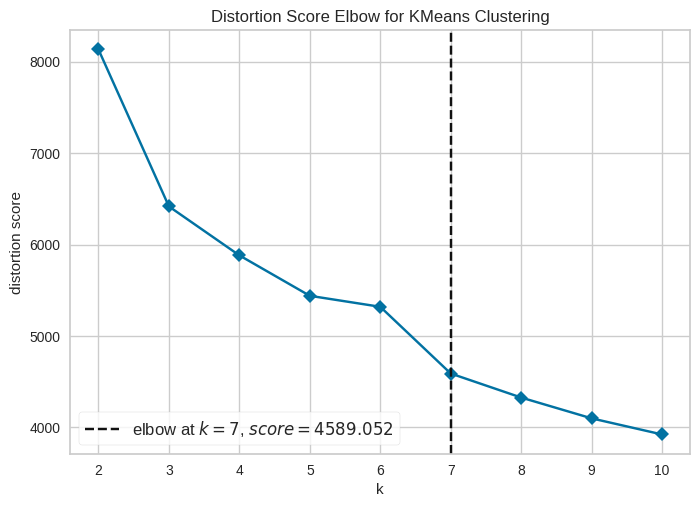

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [166]:
# Plotando o gráfico do Cotovelo pra descobrir o K
kelbow_visualizer(KMeans(), X_scaled_dl, k=10, timings=False)

In [168]:
# Chamando a função para avaliar as métricas do Kmeans
resultados_kmeans = avaliar_modelos_clusterizacao(X_scaled_dl, KMeans(random_state=42))
resultados_kmeans.style.background_gradient()

In [169]:
# Calcula médias das principais features por cluster
cluster_dl = dl_mean.groupby('cluster')[features_cluster_defesa].mean().round(2)

# Mostra o resumo
cluster_dl

solo_tackle  assist_tackle  tackle_with_assist   sack  qb_hit  \
cluster                                                                  
0               6.82           5.52                1.76   2.01    2.81   
1              23.12          16.01                5.27   9.97   13.33   
2              47.90          23.18                7.79  27.72   35.51   

         interception  fumble_forced  safety  def_touchdown  defense_snaps  \
cluster                                                                      
0                0.07           0.37    0.01           0.02         125.70   
1                0.32           1.58    0.08           0.08         405.14   
2                0.74           4.98    0.25           0.32         671.52   

         tackles_total  sack_rate  tackles_per_game  fantasy_points_ppr  \
cluster                                                                   
0                12.34       0.02              1.98                 0.0   
1                39.13       0.03              3.18                 0.0   
2                71.08       0.04              4.75                 0.0   

         defense_pct  impact_plays  
cluster                             
0               0.30          2.48  
1               0.49         12.03  
2               0.69         34.02

In [170]:
df_defesa_limpo.columns

Index(['player_id', 'player_name', 'position', 'team', 'season', 'age',
       'games_played_season', 'height', 'weight', 'college', 'draft_year',
       'draft_round', 'draft_pick', 'seasons_played', 'solo_tackle',
       'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit', 'interception',
       'fumble_forced', 'safety', 'def_touchdown', 'defense_snaps',
       'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard',
       'tackles_total', 'sack_rate', 'tackles_per_game', 'impact_plays'],
      dtype='object')

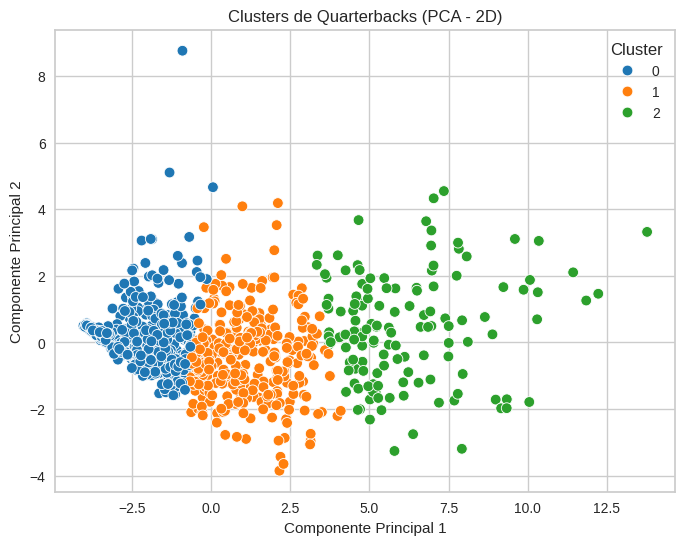

In [171]:
# Rodar o modelo final com k=3
kmeans_dl = KMeans(n_clusters=3, random_state=42)
dl_mean['cluster'] = kmeans_dl.fit_predict(X_scaled_dl)

# Criar o resumo médio por cluster
df_summary_defense = dl_mean.groupby('cluster')[[
    'solo_tackle', 'assist_tackle', 'tackles_total',
    'sack', 'qb_hit', 'fumble_forced', 'def_touchdown'
]].mean()


# Reduzindo para 2 dimensões com PCA
pca = PCA(n_components=2)
dl_pca = pca.fit_transform(X_scaled_dl)

# Adicionando os componentes principais ao dataframe
dl_mean['pca1'] = dl_pca[:, 0]
dl_mean['pca2'] = dl_pca[:, 1]

# Plotando os clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=dl_mean, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters de Quarterbacks (PCA - 2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

In [172]:
dl_mean['cluster'].value_counts()

cluster
0    539
1    308
2    136
Name: count, dtype: int64

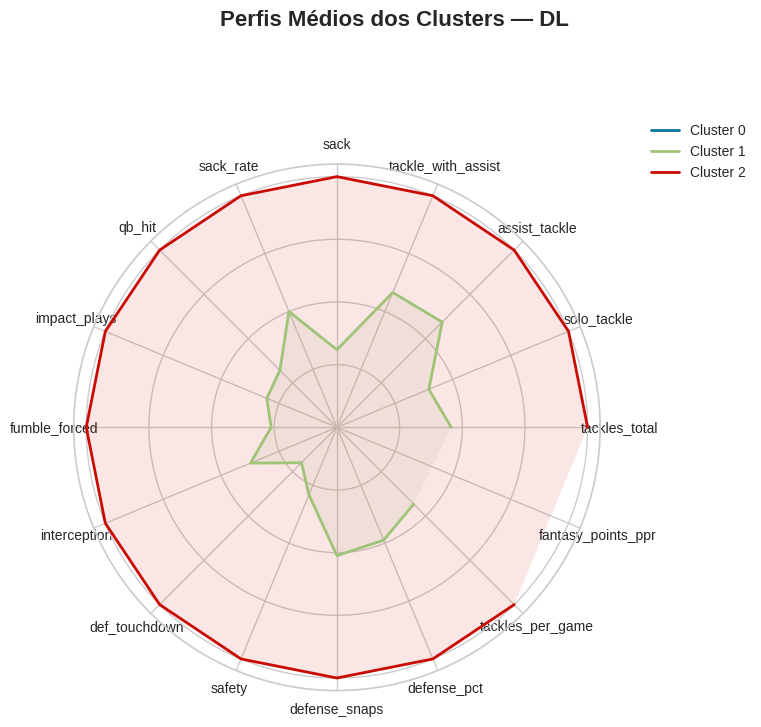

In [173]:
plot_radar_clusters_defense(dl_mean, posicao='DL')

In [174]:
def interpretar_clusters_defesa(df_or_mean, posicao='DL', features=None):
    """
    Interpreta clusters de Defensive Linemen (DL) classificando em:
    - Run Stopper
    - Pass Rusher
    - DL Equilibrado
    """

    # Detectar se é um dataframe com 'cluster' ou já agrupado
    if isinstance(df_or_mean, pd.DataFrame) and 'cluster' in df_or_mean.columns:
        df_summary = make_df_summary_defense(df_or_mean, features)
    else:
        df_summary = df_or_mean.copy()
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Features relevantes
    if features is None:
        features = [
            'tackles_total', 'solo_tackle', 'assist_tackle', 'sack', 'qb_hit',
            'impact_plays', 'fumble_forced', 'defense_snaps', 'defense_pct'
        ]
    features = [f for f in features if f in df_summary.columns]

    if len(features) == 0:
        return "Nenhuma feature defensiva válida encontrada para interpretação."

    # Percentis
    percentis = {
        f: {'p25': np.percentile(df_summary[f].dropna(), 25),
            'p50': np.percentile(df_summary[f].dropna(), 50),
            'p75': np.percentile(df_summary[f].dropna(), 75)}
        for f in features
    }

    interpretacoes = []
    clusters_sorted = sorted(df_summary.index.tolist())

    for cluster_id in clusters_sorted:
        row = df_summary.loc[cluster_id]
        texto = f"### Cluster {cluster_id} — {posicao}\n"

        # 🔹 Métricas principais
        tackles = row.get('tackles_total', 0)
        sacks = row.get('sack', 0)
        qb_hits = row.get('qb_hit', 0)
        snaps = row.get('defense_snaps', 0)

        # 📊 Razões auxiliares
        sack_tackle_ratio = sacks / tackles if tackles > 0 else 0
        qb_hit_tackle_ratio = qb_hits / tackles if tackles > 0 else 0

        # 🧱 Classificação do tipo de DL (mais sensível)
        if sack_tackle_ratio > 0.5 or sacks > percentis['sack']['p75']:
            tipo = "⚡ **Pass Rusher Explosivo** — especialista em gerar pressão e sacks."
        elif sack_tackle_ratio < 0.2 and tackles > percentis['tackles_total']['p75']:
            tipo = "🧱 **Run Stopper Clássico** — âncora da linha, domina o jogo corrido."
        else:
            tipo = "🔁 **DL Equilibrado** — contribui tanto no pass rush quanto contra o jogo terrestre."

        # 🔹 Descrições complementares
        if tackles > percentis['tackles_total']['p75']:
            texto += "- **Alto volume de tackles**: presença forte na contenção do jogo corrido.\n"
        elif tackles < percentis['tackles_total']['p25']:
            texto += "- **Baixo volume de tackles**: menos envolvido nas jogadas de corrida.\n"

        if sacks > percentis['sack']['p75'] or qb_hits > percentis['qb_hit']['p75']:
            texto += "- **Alta pressão ao QB**: destaque como pass rusher.\n"
        elif sacks < percentis['sack']['p25'] and qb_hits < percentis['qb_hit']['p25']:
            texto += "- **Baixa produção de pressão**: foca mais na defesa terrestre.\n"

        if row.get('impact_plays', 0) > percentis['impact_plays']['p75']:
            texto += "- **Cria jogadas de impacto** (fumbles, sacks decisivos, TFLs).\n"

        if row.get('fumble_forced', 0) > percentis['fumble_forced']['p75']:
            texto += "- **Força turnovers** com frequência.\n"

        if row.get('defense_pct', 0) > percentis['defense_pct']['p75']:
            texto += "- **Alta participação nos snaps defensivos**: peça essencial na linha.\n"

        texto += f"\n➡️ Perfil geral: {tipo}\n"

        # 📊 Estatísticas médias
        resumo_stats = ", ".join([f"{f}: {row[f]:.1f}" for f in features])
        texto += f"\n📊 Estatísticas médias (por cluster): {resumo_stats}\n\n---\n"

        interpretacoes.append(texto)

    return "\n".join(interpretacoes)



interpretacao_dl = interpretar_clusters_defesa(dl_mean, posicao='DL')
print(interpretacao_dl)



### Cluster 0 — DL
- **Baixo volume de tackles**: menos envolvido nas jogadas de corrida.
- **Baixa produção de pressão**: foca mais na defesa terrestre.

➡️ Perfil geral: 🔁 **DL Equilibrado** — contribui tanto no pass rush quanto contra o jogo terrestre.

📊 Estatísticas médias (por cluster): tackles_total: 12.3, solo_tackle: 6.8, assist_tackle: 5.5, sack: 2.0, qb_hit: 2.8, impact_plays: 2.5, fumble_forced: 0.4, defense_snaps: 125.7, defense_pct: 0.3

---

### Cluster 1 — DL

➡️ Perfil geral: 🔁 **DL Equilibrado** — contribui tanto no pass rush quanto contra o jogo terrestre.

📊 Estatísticas médias (por cluster): tackles_total: 39.1, solo_tackle: 23.1, assist_tackle: 16.0, sack: 10.0, qb_hit: 13.3, impact_plays: 12.0, fumble_forced: 1.6, defense_snaps: 405.1, defense_pct: 0.5

---

### Cluster 2 — DL
- **Alto volume de tackles**: presença forte na contenção do jogo corrido.
- **Alta pressão ao QB**: destaque como pass rusher.
- **Cria jogadas de impacto** (fumbles, sacks decisivos, TFLs

In [175]:
# Dicionário com nomes para cada cluster de DL (ajuste conforme seu resultado real)
cluster_names_dl = {
    0: "DL pouco expressivos",
    1: "DLs Equilibrados / Versáteis",
    2: "Pass Rushers e Run Stoppers"
}

# Loop mostrando exemplos de cada cluster
for c in sorted(dl_mean['cluster'].unique()):
    cluster_name = cluster_names_dl.get(c, "Cluster Sem Nome")
    print(f"\n🔹 Cluster {c} — {cluster_name}:")
    display(dl_mean[dl_mean['cluster'] == c][['player_name', 'position']].head(5))



🔹 Cluster 0 — DL pouco expressivos:


player_name position
0   Vonnie Holliday       DE
2       Ron Edwards       NT
5      Andre Carter       DE
7      Shaun Rogers       DT
10    Justin Bannan       DT


🔹 Cluster 1 — DLs Equilibrados / Versáteis:


player_name position
1      Juqua Parker       DE
4     Casey Hampton       NT
6      Ryan Pickett       DT
9   Ma'ake Kemoeatu       NT
12   Dwight Freeney       DE


🔹 Cluster 2 — Pass Rushers e Run Stoppers:


player_name position
3   Kyle Vanden Bosch       DE
8        Justin Smith       DE
11     Julius Peppers       DE
16      Chris Clemons       DE
21      Osi Umenyiora       DE

####**Linebackers**

In [176]:
# Agrupar por jogador e calcular a média de suas estatísticas ao longo dos anos
lb_mean = (
    lbs.groupby(['player_id', 'player_name', 'position'])
    [features_cluster_defesa]
    .mean()
    .reset_index()
)

# Preencher valores nulos com 0
X_lb = lb_mean[features_cluster_defesa].fillna(0)

# Padronizar os dados
X_scaled_lb = scaler.fit_transform(X_lb)

# Rodar o KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
lb_mean["cluster"] = kmeans.fit_predict(X_scaled_lb)

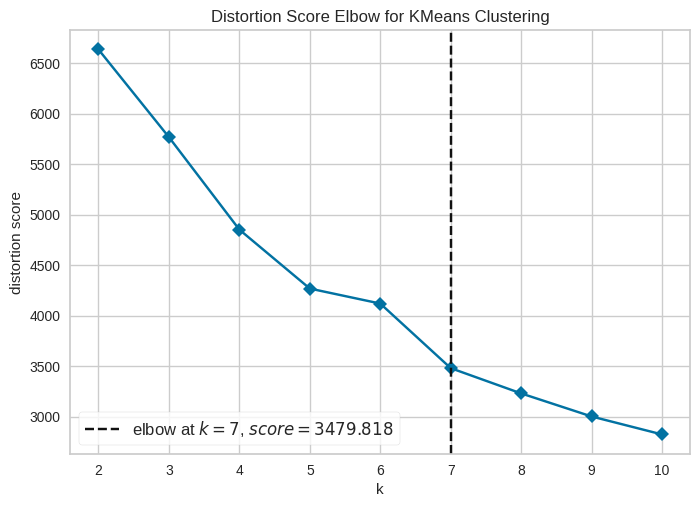

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [177]:
# Plotando o gráfico do Cotovelo pra descobrir o K
kelbow_visualizer(KMeans(), X_scaled_lb, k=10, timings=False)

In [179]:
# Chamando a função para avaliar as métricas do Kmeans
resultados_kmeans = avaliar_modelos_clusterizacao(X_scaled_lb, KMeans(random_state=42))
resultados_kmeans.style.background_gradient()

In [180]:
# Calcula médias das principais features por cluster
cluster_lb = lb_mean.groupby('cluster')[features_cluster_defesa].mean().round(2)

# Mostra o resumo
cluster_dl

solo_tackle  assist_tackle  tackle_with_assist   sack  qb_hit  \
cluster                                                                  
0               6.82           5.52                1.76   2.01    2.81   
1              23.12          16.01                5.27   9.97   13.33   
2              47.90          23.18                7.79  27.72   35.51   

         interception  fumble_forced  safety  def_touchdown  defense_snaps  \
cluster                                                                      
0                0.07           0.37    0.01           0.02         125.70   
1                0.32           1.58    0.08           0.08         405.14   
2                0.74           4.98    0.25           0.32         671.52   

         tackles_total  sack_rate  tackles_per_game  fantasy_points_ppr  \
cluster                                                                   
0                12.34       0.02              1.98                 0.0   
1                39.13       0.03              3.18                 0.0   
2                71.08       0.04              4.75                 0.0   

         defense_pct  impact_plays  
cluster                             
0               0.30          2.48  
1               0.49         12.03  
2               0.69         34.02

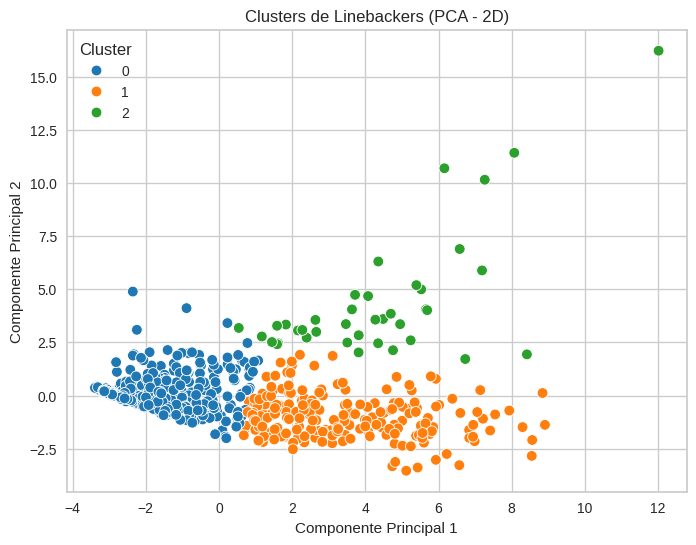

In [181]:
# Rodar o modelo final com k=3
kmeans_lb = KMeans(n_clusters=3, random_state=42)
lb_mean['cluster'] = kmeans_lb.fit_predict(X_scaled_lb)

# Criar o resumo médio por cluster
df_summary_defense = lb_mean.groupby('cluster')[[
    'solo_tackle', 'assist_tackle', 'tackles_total',
    'sack', 'qb_hit', 'fumble_forced', 'def_touchdown'
]].mean()


# Reduzindo para 2 dimensões com PCA
pca = PCA(n_components=2)
lb_pca = pca.fit_transform(X_scaled_lb)

# Adicionando os componentes principais ao dataframe
lb_mean['pca1'] = lb_pca[:, 0]
lb_mean['pca2'] = lb_pca[:, 1]

# Plotando os clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=lb_mean, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters de Linebackers (PCA - 2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

In [182]:
dl_mean['cluster'].value_counts()

cluster
0    539
1    308
2    136
Name: count, dtype: int64

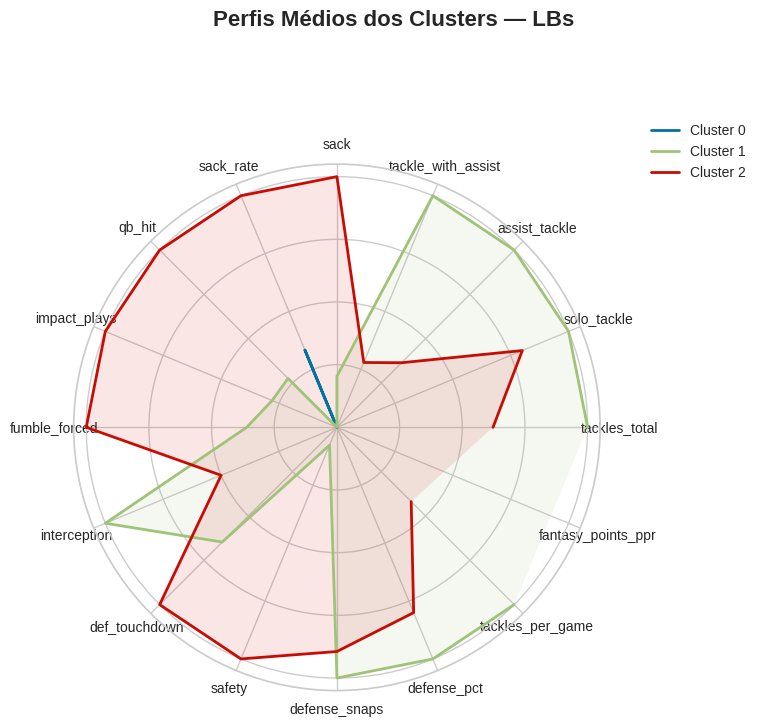

In [183]:
plot_radar_clusters_defense(lb_mean, posicao='LBs')

In [184]:
def interpretar_clusters_lbs(df_or_mean, features=None):
    """
    Interpreta clusters de Linebackers (LB) classificando em:
    - Coverage LB (especialista em marcação e leitura de jogo)
    - Run Stopper (forte contra o jogo terrestre)
    - Blitz/Playmaker (atua com pressão e jogadas de impacto)
    """

    # Detectar se é um dataframe com 'cluster' ou já agrupado
    if isinstance(df_or_mean, pd.DataFrame) and 'cluster' in df_or_mean.columns:
        df_summary = make_df_summary_defense(df_or_mean, features)
    else:
        df_summary = df_or_mean.copy()
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Features padrão relevantes para LBs
    if features is None:
        features = [
            'tackles_total', 'solo_tackle', 'assist_tackle',
            'sack', 'qb_hit', 'impact_play', 'fumble_forced',
            'interception', 'defense_snaps', 'defense_pct'
        ]
    features = [f for f in features if f in df_summary.columns]

    if len(features) == 0:
        return "Nenhuma feature defensiva válida encontrada para interpretação."

    # Cálculo de percentis (para comparação relativa)
    percentis = {
        f: {'p25': np.percentile(df_summary[f].dropna(), 25),
            'p50': np.percentile(df_summary[f].dropna(), 50),
            'p75': np.percentile(df_summary[f].dropna(), 75)}
        for f in features
    }

    interpretacoes = []
    clusters_sorted = sorted(df_summary.index.tolist())

    for cluster_id in clusters_sorted:
        row = df_summary.loc[cluster_id]
        texto = f"### Cluster {cluster_id} — Linebackers\n"

        tackles = row.get('tackles_total', 0)
        sacks = row.get('sack', 0)
        qb_hits = row.get('qb_hit', 0)
        interceptions = row.get('interception', 0)
        snaps = row.get('defense_snaps', 0)
        impact = row.get('impact_play', 0)

        # Razões auxiliares
        sack_tackle_ratio = sacks / tackles if tackles > 0 else 0
        impact_tackle_ratio = impact / tackles if tackles > 0 else 0

        # 🔹 Classificação do tipo de LB
        if sacks > percentis['sack']['p75'] or qb_hits > percentis['qb_hit']['p75']:
            tipo = "⚡ **Blitz / Playmaker LB** — agressivo, gera pressão e turnovers."
        elif interceptions > percentis['interception']['p75'] or row.get('assist_tackle', 0) > percentis['assist_tackle']['p75']:
            tipo = "🧠 **Coverage LB** — atua em cobertura de passe, boa leitura de jogo e apoio em tackles secundários."
        elif tackles > percentis['tackles_total']['p75'] and sacks < percentis['sack']['p50']:
            tipo = "🧱 **Run Stopper LB** — foco em parar corridas, presença física constante."
        else:
            tipo = "🔁 **LB Equilibrado** — contribui de forma balanceada em corrida e passe."

        # 🔹 Complementos descritivos
        if tackles > percentis['tackles_total']['p75']:
            texto += "- **Alta produção de tackles**: presença forte em todas as jogadas defensivas.\n"
        elif tackles < percentis['tackles_total']['p25']:
            texto += "- **Baixo volume de tackles**: possivelmente jogador de rotação ou situacional.\n"

        if sacks > percentis['sack']['p75']:
            texto += "- **Alta taxa de sacks**: excelente desempenho em blitzes.\n"

        if interceptions > percentis['interception']['p75']:
            texto += "- **Alta taxa de interceptações**: destaque em cobertura de passes.\n"

        if row.get('fumble_forced', 0) > percentis['fumble_forced']['p75']:
            texto += "- **Cria turnovers** com frequência (fumbles forçados).\n"

        if impact > percentis['impact_play']['p75']:
            texto += "- **Grande número de jogadas de impacto** (TFLs, sacks decisivos, turnovers).\n"

        if row.get('defense_pct', 0) > percentis['defense_pct']['p75']:
            texto += "- **Alta participação nos snaps defensivos**: peça essencial no sistema.\n"

        texto += f"\n➡️ **Perfil geral:** {tipo}\n"

        # 📊 Estatísticas médias resumidas
        resumo_stats = ", ".join([f"{f}: {row[f]:.1f}" for f in features])
        texto += f"\n📊 Estatísticas médias (por cluster): {resumo_stats}\n\n---\n"

        interpretacoes.append(texto)

    return "\n".join(interpretacoes)

interpretacao_lb = interpretar_clusters_defesa(lb_mean, posicao='LB')
print(interpretacao_lb)


### Cluster 0 — LB
- **Baixo volume de tackles**: menos envolvido nas jogadas de corrida.
- **Baixa produção de pressão**: foca mais na defesa terrestre.

➡️ Perfil geral: 🔁 **DL Equilibrado** — contribui tanto no pass rush quanto contra o jogo terrestre.

📊 Estatísticas médias (por cluster): tackles_total: 14.8, solo_tackle: 8.9, assist_tackle: 5.9, sack: 1.5, qb_hit: 2.1, impact_plays: 2.0, fumble_forced: 0.4, defense_snaps: 110.8, defense_pct: 0.3

---

### Cluster 1 — LB
- **Alto volume de tackles**: presença forte na contenção do jogo corrido.
- **Alta participação nos snaps defensivos**: peça essencial na linha.

➡️ Perfil geral: 🧱 **Run Stopper Clássico** — âncora da linha, domina o jogo corrido.

📊 Estatísticas médias (por cluster): tackles_total: 86.4, solo_tackle: 51.3, assist_tackle: 35.1, sack: 5.5, qb_hit: 8.8, impact_plays: 9.0, fumble_forced: 1.9, defense_snaps: 618.8, defense_pct: 0.7

---

### Cluster 2 — LB
- **Alta pressão ao QB**: destaque como pass rusher.
- **Cria

In [185]:
# Dicionário com nomes para cada cluster de DL (ajuste conforme seu resultado real)
cluster_names_lb = {
    0: "Linebackers Equilibrados",
    1: "Linebarckers de Cobertura / Run Stopper",
    2: "Blitz / Playmaker LB"
}

# Loop mostrando exemplos de cada cluster
for c in sorted(lb_mean['cluster'].unique()):
    cluster_name = cluster_names_lb.get(c, "Cluster Sem Nome")
    print(f"\n🔹 Cluster {c} — {cluster_name}:")
    display(lb_mean[lb_mean['cluster'] == c][['player_name', 'position']].head(5))


🔹 Cluster 0 — Linebackers Equilibrados:


player_name position
0   Brendon Ayanbadejo      ILB
4        Mike Peterson      OLB
7        Clark Haggans      OLB
11        Bryan Thomas      OLB
14        Scott Fujita      OLB


🔹 Cluster 1 — Linebarckers de Cobertura / Run Stopper:


player_name position
1   Keith Brooking      OLB
2  London Fletcher      ILB
3        Ray Lewis      ILB
5      Paris Lenon      MLB
6   Brian Urlacher      MLB


🔹 Cluster 2 — Blitz / Playmaker LB:


player_name position
8     John Abraham      OLB
9   James Harrison      OLB
19   Robert Mathis      OLB
20     Calvin Pace      OLB
23   Terrell Suggs       LB

####**Cornerbacks**

In [186]:
# Agrupar por jogador e calcular a média de suas estatísticas ao longo dos anos
cb_mean = (
    cbs.groupby(['player_id', 'player_name', 'position'])
    [features_cluster_defesa]
    .mean()
    .reset_index()
)

# Preencher valores nulos com 0
X_cb = cb_mean[features_cluster_defesa].fillna(0)

# Padronizar os dados
X_scaled_cb = scaler.fit_transform(X_cb)

# Rodar o KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
cb_mean["cluster"] = kmeans.fit_predict(X_scaled_cb)

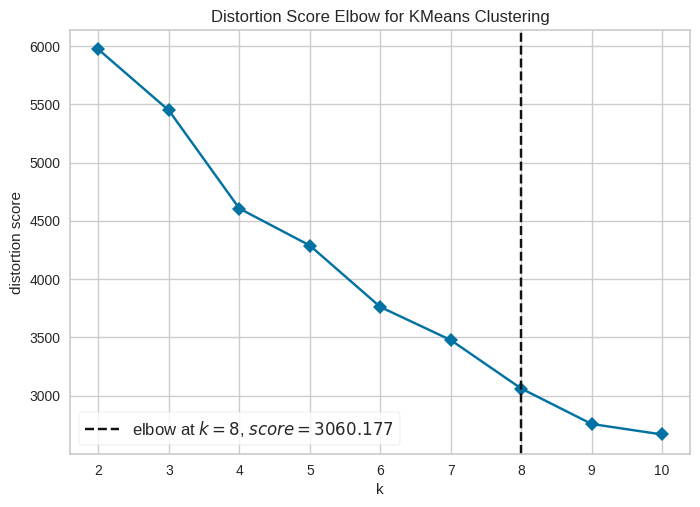

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [187]:
# Plotando o gráfico do Cotovelo pra descobrir o K
kelbow_visualizer(KMeans(), X_scaled_cb, k=10, timings=False)

In [189]:
# Chamando a função para avaliar as métricas do Kmeans
resultados_kmeans = avaliar_modelos_clusterizacao(X_scaled_cb, KMeans(random_state=42))
resultados_kmeans.style.background_gradient()

In [190]:
# Calcula médias das principais features por cluster
cluster_cb = cb_mean.groupby('cluster')[features_cluster_defesa].mean().round(2)

# Mostra o resumo
cluster_cb

solo_tackle  assist_tackle  tackle_with_assist  sack  qb_hit  \
cluster                                                                 
0              11.09           3.64                1.30  0.18    0.99   
1              39.86          13.38                5.03  1.29    4.41   

         interception  fumble_forced  safety  def_touchdown  defense_snaps  \
cluster                                                                      
0                0.55           0.23    0.01           0.04         173.14   
1                3.14           1.39    0.03           0.37         670.41   

         tackles_total  sack_rate  tackles_per_game  fantasy_points_ppr  \
cluster                                                                   
0                14.74        0.0              2.72                 0.0   
1                53.24        0.0              4.14                 0.0   

         defense_pct  impact_plays  
cluster                             
0               0.45          1.02  
1               0.78          6.22

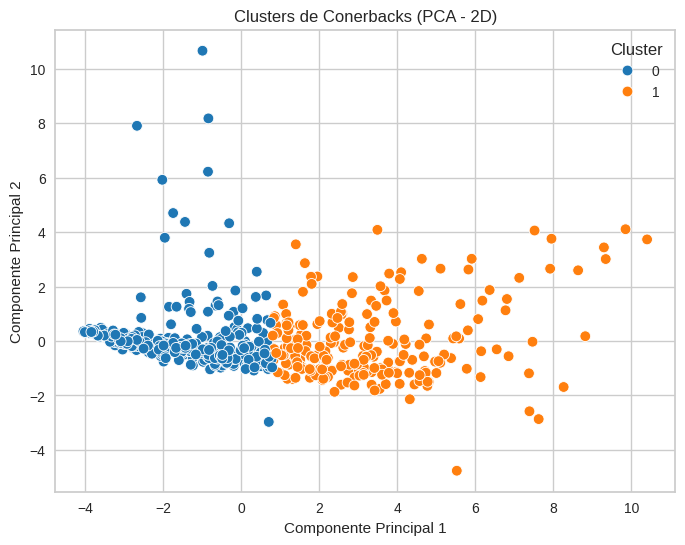

In [205]:
# Rodar o modelo final com k=2
kmeans_cb = KMeans(n_clusters=2, random_state=42)
cb_mean['cluster'] = kmeans_cb.fit_predict(X_scaled_cb)

# Criar o resumo médio por cluster
df_summary_defense = cb_mean.groupby('cluster')[[
    'solo_tackle', 'assist_tackle', 'tackles_total',
    'sack', 'qb_hit', 'fumble_forced', 'def_touchdown', 'interception'
]].mean()


# Reduzindo para 2 dimensões com PCA
pca = PCA(n_components=2)
cb_pca = pca.fit_transform(X_scaled_cb)

# Adicionando os componentes principais ao dataframe
cb_mean['pca1'] = cb_pca[:, 0]
cb_mean['pca2'] = cb_pca[:, 1]

# Plotando os clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=cb_mean, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters de Conerbacks (PCA - 2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

In [206]:
cb_mean['cluster'].value_counts()

cluster
0    427
1    229
Name: count, dtype: int64

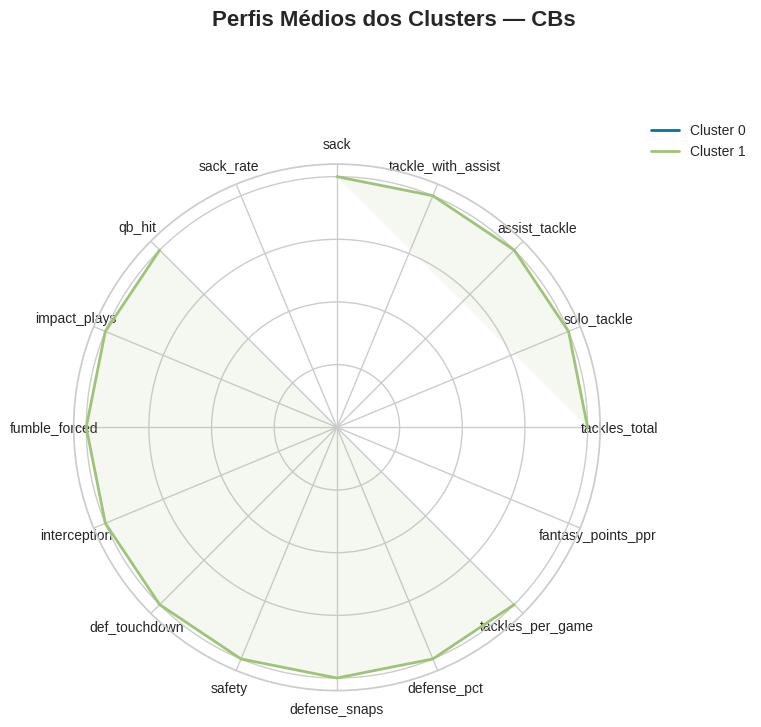

In [207]:
plot_radar_clusters_defense(cb_mean, posicao='CBs')

In [208]:
def interpretar_clusters_cbs(df_or_mean, features=None):
    """
    Interpreta clusters de Cornerbacks (CB) classificando em:
    - Coverage CB (especialista em cobertura de passes, evita alvos e tackles)
    - Run Support / Physical CB (foco em tackles, blitz e suporte contra corridas)
    """

    # Detectar se é um dataframe com 'cluster' ou já agrupado
    if isinstance(df_or_mean, pd.DataFrame) and 'cluster' in df_or_mean.columns:
        df_summary = make_df_summary_defense(df_or_mean, features)
    else:
        df_summary = df_or_mean.copy()
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Features padrão relevantes para CBs
    if features is None:
        features = [
            'solo_tackle', 'assist_tackle', 'tackles_total',
            'sack', 'qb_hit', 'interception', 'fumble_forced',
            'defense_snaps', 'impact_plays', 'defense_pct'
        ]
    features = [f for f in features if f in df_summary.columns]

    if len(features) == 0:
        return "Nenhuma feature defensiva válida encontrada para interpretação."

    # Cálculo de percentis (para referência comparativa)
    percentis = {
        f: {'p25': np.percentile(df_summary[f].dropna(), 25),
            'p50': np.percentile(df_summary[f].dropna(), 50),
            'p75': np.percentile(df_summary[f].dropna(), 75)}
        for f in features
    }

    interpretacoes = []
    clusters_sorted = sorted(df_summary.index.tolist())

    for cluster_id in clusters_sorted:
        row = df_summary.loc[cluster_id]
        texto = f"### Cluster {cluster_id} — Cornerbacks\n"

        tackles = row.get('tackles_total', 0)
        sacks = row.get('sack', 0)
        interceptions = row.get('interception', 0)
        fumbles = row.get('fumble_forced', 0)
        impact = row.get('impact_plays', 0)
        qb_hits = row.get('qb_hit', 0)

        # Razões auxiliares
        impact_tackle_ratio = impact / tackles if tackles > 0 else 0

        # 🔹 Classificação do tipo de CB
        if tackles > percentis['tackles_total']['p75'] or impact > percentis['impact_plays']['p75']:
            tipo = "🟥 **Run Support / Physical CB** — atua no slot ou próximo do box, alta produção de tackles e jogadas de impacto."
        elif interceptions > percentis['interception']['p75'] or sacks < percentis['sack']['p25']:
            tipo = "🟦 **Coverage CB** — especialista em marcação e leitura, evita passes e raramente é acionado em blitz."
        else:
            tipo = "🟩 **CB Equilibrado** — contribui tanto em cobertura quanto no suporte à corrida."

        # 🔹 Complementos descritivos
        if tackles > percentis['tackles_total']['p75']:
            texto += "- **Alta produção de tackles**: atua no box e apoia o jogo terrestre.\n"
        elif tackles < percentis['tackles_total']['p25']:
            texto += "- **Baixo volume de tackles**: tende a ser um CB de cobertura em profundidade.\n"

        if interceptions > percentis['interception']['p75']:
            texto += "- **Alta taxa de interceptações**: leitura apurada e ball skills acima da média.\n"

        if sacks > percentis['sack']['p75'] or qb_hits > percentis['qb_hit']['p75']:
            texto += "- **Presença em blitzes**: usado agressivamente em pacotes de pressão.\n"

        if fumbles > percentis['fumble_forced']['p75']:
            texto += "- **Gera turnovers** com frequência (fumbles forçados / jogadas físicas).\n"

        if impact > percentis['impact_plays']['p75']:
            texto += "- **Alto impacto por jogo**: presença marcante em turnovers e tackles decisivos.\n"

        if row.get('defense_pct', 0) > percentis['defense_pct']['p75']:
            texto += "- **Alta participação nos snaps defensivos**: titular em pacotes base e nickel.\n"

        texto += f"\n➡️ **Perfil geral:** {tipo}\n"

        # 📊 Estatísticas médias resumidas
        resumo_stats = ", ".join([f"{f}: {row[f]:.1f}" for f in features])
        texto += f"\n📊 Estatísticas médias (por cluster): {resumo_stats}\n\n---\n"

        interpretacoes.append(texto)

    return "\n".join(interpretacoes)

interpretacao_cb = interpretar_clusters_cbs(cb_mean)
print(interpretacao_cb)


### Cluster 0 — Cornerbacks
- **Baixo volume de tackles**: tende a ser um CB de cobertura em profundidade.

➡️ **Perfil geral:** 🟦 **Coverage CB** — especialista em marcação e leitura, evita passes e raramente é acionado em blitz.

📊 Estatísticas médias (por cluster): solo_tackle: 11.1, assist_tackle: 3.6, tackles_total: 14.7, sack: 0.2, qb_hit: 1.0, interception: 0.6, fumble_forced: 0.2, defense_snaps: 173.1, impact_plays: 1.0, defense_pct: 0.5

---

### Cluster 1 — Cornerbacks
- **Alta produção de tackles**: atua no box e apoia o jogo terrestre.
- **Alta taxa de interceptações**: leitura apurada e ball skills acima da média.
- **Presença em blitzes**: usado agressivamente em pacotes de pressão.
- **Gera turnovers** com frequência (fumbles forçados / jogadas físicas).
- **Alto impacto por jogo**: presença marcante em turnovers e tackles decisivos.
- **Alta participação nos snaps defensivos**: titular em pacotes base e nickel.

➡️ **Perfil geral:** 🟥 **Run Support / Physical CB** — atu

In [209]:
# Dicionário com nomes para cada cluster de DL (ajuste conforme seu resultado real)
cluster_names_cb = {
    0: "Conerbacks de rotação",
    1: "Conerbacks de cobertura e run support",
}

# Loop mostrando exemplos de cada cluster
for c in sorted(cb_mean['cluster'].unique()):
    cluster_name = cluster_names_cb.get(c, "Cluster Sem Nome")
    print(f"\n🔹 Cluster {c} — {cluster_name}:")
    display(cb_mean[cb_mean['cluster'] == c][['player_name', 'position']].head(5))


🔹 Cluster 0 — Conerbacks de rotação:


player_name position
4     Quentin Jammer       CB
5      Chris Johnson       CB
7   Drayton Florence       CB
8     Terrence McGee       CB
10    Marcus Trufant       CB


🔹 Cluster 1 — Conerbacks de cobertura e run support:


player_name position
0      Champ Bailey       CB
1  Antoine Winfield       CB
2     Nate Clements       CB
3     Sheldon Brown       CB
6     Asante Samuel       CB

####**Safeties**

In [201]:
# Agrupar por jogador e calcular a média de suas estatísticas ao longo dos anos
ss_mean = (
    safeties.groupby(['player_id', 'player_name', 'position'])
    [features_cluster_defesa]
    .mean()
    .reset_index()
)

# Preencher valores nulos com 0
X_ss = ss_mean[features_cluster_defesa].fillna(0)

# Padronizar os dados
X_scaled_ss = scaler.fit_transform(X_ss)

# Rodar o KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
ss_mean["cluster"] = kmeans.fit_predict(X_scaled_ss)

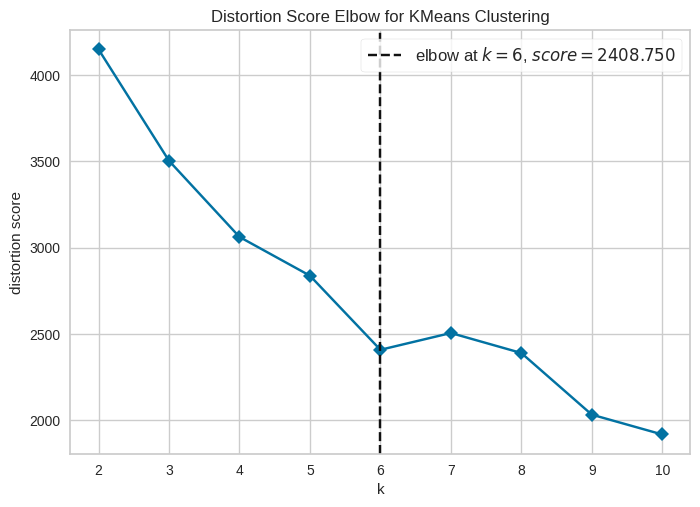

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [202]:
# Plotando o gráfico do Cotovelo pra descobrir o K
kelbow_visualizer(KMeans(), X_scaled_ss, k=10, timings=False)

In [203]:
# Chamando a função para avaliar as métricas do Kmeans
resultados_kmeans = avaliar_modelos_clusterizacao(X_scaled_ss, KMeans(random_state=42))
resultados_kmeans.style.background_gradient()

In [204]:
# Calcula médias das principais features por cluster
cluster_ss = ss_mean.groupby('cluster')[features_cluster_defesa].mean().round(2)

# Mostra o resumo
cluster_ss

solo_tackle  assist_tackle  tackle_with_assist  sack  qb_hit  \
cluster                                                                 
0               9.60           4.78                1.68  0.41    1.09   
1              37.15          18.79                6.71  1.33    3.99   
2              57.28          28.41               10.90  3.88    7.96   
3               6.25           1.00                0.00  5.00    5.50   

         interception  fumble_forced  safety  def_touchdown  defense_snaps  \
cluster                                                                      
0                0.47           0.24    0.00           0.03         144.82   
1                2.59           1.12    0.00           0.19         606.93   
2                4.07           2.48    0.03           0.54         843.08   
3                0.00           0.00    0.00           0.00          26.25   

         tackles_total  sack_rate  tackles_per_game  fantasy_points_ppr  \
cluster                                                                   
0                14.37       0.00              2.70                 0.0   
1                55.94       0.00              4.53                 0.0   
2                85.69       0.00              5.83                 0.0   
3                 7.25       0.22              3.92                 0.0   

         defense_pct  impact_plays  
cluster                             
0               0.39          1.14  
1               0.73          5.24  
2               0.86         10.99  
3               0.24          5.00

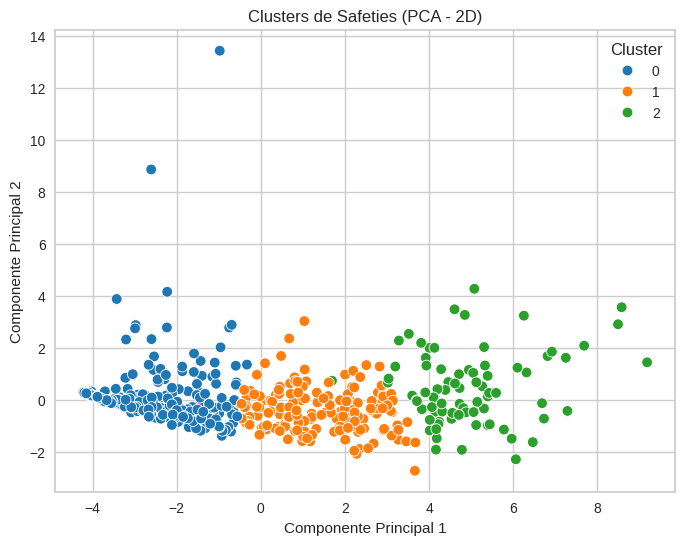

In [219]:
# Rodar o modelo final com k=3
kmeans_ss = KMeans(n_clusters=3, random_state=42)
ss_mean['cluster'] = kmeans_ss.fit_predict(X_scaled_ss)

# Criar o resumo médio por cluster
df_summary_defense = ss_mean.groupby('cluster')[[
    'solo_tackle', 'assist_tackle', 'tackles_total',
    'sack', 'qb_hit', 'fumble_forced', 'def_touchdown', 'interception'
]].mean()


# Reduzindo para 2 dimensões com PCA
pca = PCA(n_components=2)
ss_pca = pca.fit_transform(X_scaled_ss)

# Adicionando os componentes principais ao dataframe
ss_mean['pca1'] = ss_pca[:, 0]
ss_mean['pca2'] = ss_pca[:, 1]

# Plotando os clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=ss_mean, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters de Safeties (PCA - 2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

In [220]:
ss_mean['cluster'].value_counts()

cluster
0    253
1    165
2     79
Name: count, dtype: int64

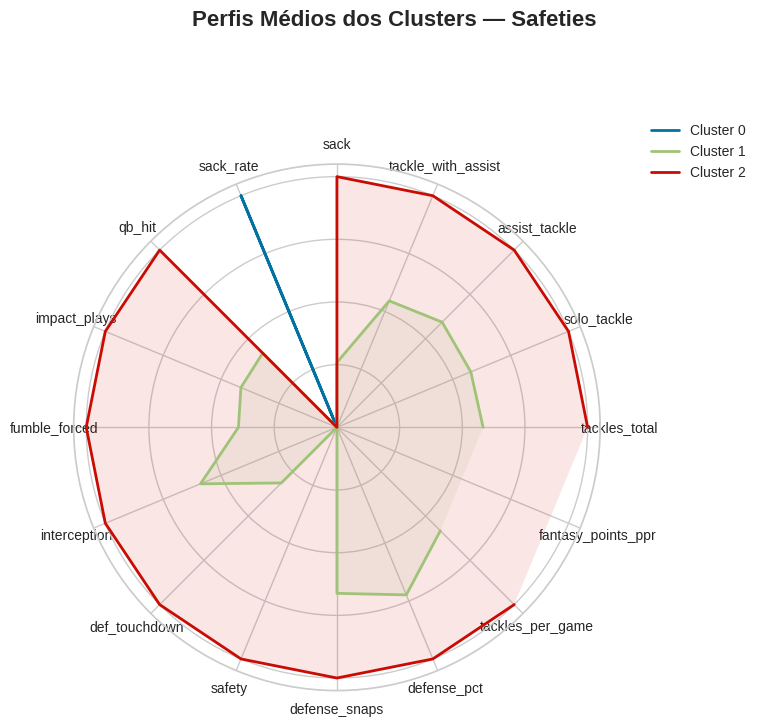

In [221]:
plot_radar_clusters_defense(ss_mean, posicao='Safeties')

In [222]:
def interpretar_clusters_safeties(df_or_mean, features=None):
    """
    Interpreta clusters de Safeties (S) classificando em:
    - Free Safety (FS): especialista em cobertura, interceptações e leitura de passes
    - Strong Safety (SS): físico, bom contra o jogo terrestre
    - Hybrid / Nickel Safety: atua no slot ou no box, misto entre cobertura e blitz
    - Ball Hawk / Playmaker: foco em gerar turnovers e jogadas de impacto
    """

    # Detectar se é um dataframe com 'cluster' ou já agrupado
    if isinstance(df_or_mean, pd.DataFrame) and 'cluster' in df_or_mean.columns:
        df_summary = make_df_summary_defense(df_or_mean, features)
    else:
        df_summary = df_or_mean.copy()
        if 'cluster' in df_summary.columns:
            df_summary = df_summary.set_index('cluster')

    # Features padrão relevantes para Safeties
    if features is None:
        features = [
            'tackles_total', 'solo_tackle', 'assist_tackle',
            'sack', 'qb_hit', 'interception', 'fumble_forced',
            'impact_plays', 'defense_snaps', 'defense_pct'
        ]
    features = [f for f in features if f in df_summary.columns]

    if len(features) == 0:
        return "Nenhuma feature defensiva válida encontrada para interpretação."

    # Cálculo de percentis para referência
    percentis = {
        f: {'p25': np.percentile(df_summary[f].dropna(), 25),
            'p50': np.percentile(df_summary[f].dropna(), 50),
            'p75': np.percentile(df_summary[f].dropna(), 75)}
        for f in features
    }

    interpretacoes = []
    clusters_sorted = sorted(df_summary.index.tolist())

    for cluster_id in clusters_sorted:
        row = df_summary.loc[cluster_id]
        texto = f"### Cluster {cluster_id} — Safeties\n"

        tackles = row.get('tackles_total', 0)
        sacks = row.get('sack', 0)
        qb_hits = row.get('qb_hit', 0)
        interceptions = row.get('interception', 0)
        fumbles = row.get('fumble_forced', 0)
        impact = row.get('impact_plays', 0)
        snaps = row.get('defense_snaps', 0)

        # 🔹 Classificação principal
        if interceptions > percentis['interception']['p75'] and tackles < percentis['tackles_total']['p50']:
            tipo = "🟦 **Free Safety (Cobertura Profunda)** — foca em interceptações e controle aéreo."
        elif tackles > percentis['tackles_total']['p75'] and sacks < percentis['sack']['p50']:
            tipo = "🟥 **Strong Safety (Suporte ao Jogo Terrestre)** — físico, envolvido em tackles próximos à linha."
        elif sacks > percentis['sack']['p75'] or qb_hits > percentis['qb_hit']['p75']:
            tipo = "🟨 **Hybrid / Nickel Safety** — atua em blitz e cobertura intermediária, versátil."
        elif impact > percentis['impact_plays']['p75'] or fumbles > percentis['fumble_forced']['p75']:
            tipo = "🟪 **Playmaker Safety** — cria turnovers e desequilibra o jogo."
        else:
            tipo = "🟩 **Safety Equilibrado** — contribui de forma balanceada entre cobertura e tackles."

        # 🔹 Complementos descritivos
        if tackles > percentis['tackles_total']['p75']:
            texto += "- **Alta produção de tackles**: presença constante contra o jogo corrido.\n"
        elif tackles < percentis['tackles_total']['p25']:
            texto += "- **Baixo volume de tackles**: tende a atuar mais em profundidade.\n"

        if interceptions > percentis['interception']['p75']:
            texto += "- **Alta taxa de interceptações**: leitura apurada e ótima cobertura.\n"

        if sacks > percentis['sack']['p75'] or qb_hits > percentis['qb_hit']['p75']:
            texto += "- **Presença em blitzes e pressões ao QB**.\n"

        if fumbles > percentis['fumble_forced']['p75']:
            texto += "- **Força turnovers com frequência (fumbles forçados)**.\n"

        if impact > percentis['impact_plays']['p75']:
            texto += "- **Jogadas de alto impacto e explosão defensiva**.\n"

        if row.get('defense_pct', 0) > percentis['defense_pct']['p75']:
            texto += "- **Alta participação em snaps defensivos**: titular consistente.\n"

        texto += f"\n➡️ **Perfil geral:** {tipo}\n"

        # 📊 Estatísticas médias resumidas
        resumo_stats = ", ".join([f"{f}: {row[f]:.1f}" for f in features])
        texto += f"\n📊 Estatísticas médias (por cluster): {resumo_stats}\n\n---\n"

        interpretacoes.append(texto)

    return "\n".join(interpretacoes)

interpretacao_s = interpretar_clusters_safeties(ss_mean)
print(interpretacao_s)

### Cluster 0 — Safeties
- **Baixo volume de tackles**: tende a atuar mais em profundidade.

➡️ **Perfil geral:** 🟩 **Safety Equilibrado** — contribui de forma balanceada entre cobertura e tackles.

📊 Estatísticas médias (por cluster): tackles_total: 14.3, solo_tackle: 9.6, assist_tackle: 4.8, sack: 0.4, qb_hit: 1.1, interception: 0.5, fumble_forced: 0.2, impact_plays: 1.2, defense_snaps: 143.9, defense_pct: 0.4

---

### Cluster 1 — Safeties

➡️ **Perfil geral:** 🟩 **Safety Equilibrado** — contribui de forma balanceada entre cobertura e tackles.

📊 Estatísticas médias (por cluster): tackles_total: 55.9, solo_tackle: 37.1, assist_tackle: 18.8, sack: 1.3, qb_hit: 4.0, interception: 2.6, fumble_forced: 1.1, impact_plays: 5.2, defense_snaps: 606.9, defense_pct: 0.7

---

### Cluster 2 — Safeties
- **Alta produção de tackles**: presença constante contra o jogo corrido.
- **Alta taxa de interceptações**: leitura apurada e ótima cobertura.
- **Presença em blitzes e pressões ao QB**.
- **Forç

In [223]:
# Dicionário com nomes para cada cluster de DL (ajuste conforme seu resultado real)
cluster_names_ss = {
    0: "Backup / Special Teams Safety",
    1: "Strong Safety (Run Stopper)",
    2: "Playmaker / Hybrid Safety",
}

# Loop mostrando exemplos de cada cluster
for c in sorted(ss_mean['cluster'].unique()):
    cluster_name = cluster_names_ss.get(c, "Cluster Sem Nome")
    print(f"\n🔹 Cluster {c} — {cluster_name}:")
    display(ss_mean[ss_mean['cluster'] == c][['player_name', 'position']].head(5))


🔹 Cluster 0 — Backup / Special Teams Safety:


player_name position
4       Chris Hope       SS
18      Abram Elam       SS
20  Sean Considine       SS
21  Travis Daniels       FS
23   James Sanders       FS


🔹 Cluster 1 — Strong Safety (Run Stopper):


player_name position
5            Ed Reed       FS
10      Erik Coleman       SS
12     George Wilson       FS
13  Jordan Babineaux       SS
15        Will Allen       SS


🔹 Cluster 2 — Playmaker / Hybrid Safety:


player_name position
0     Ronde Barber       FS
1  Charles Woodson       FS
2    Adrian Wilson       SS
3       Ryan Clark       FS
6   Quintin Mikell       FS